Messing around with GAN's- tutorial from [Diego Gomez Mosquera's blog ](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f)

In [1]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install tensorboardX
!pip install --no-cache-dir -I pillow

You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 2.0MB 14.0MB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        var_class = torch.autograd.variable.Variable
        if type(d_error)==var_class:
            d_error = d_error.data.cpu().numpy()
        if type(g_error)==var_class:
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        var_class = torch.autograd.variable.Variable
        if type(d_error)==var_class:
            d_error = d_error.data.cpu().numpy()[0]
        if type(g_error)==var_class:
            g_error = g_error.data.cpu().numpy()[0]
        if type(d_pred_real)==var_class:
            d_pred_real = d_pred_real.data
        if type(d_pred_fake)==var_class:
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [0]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
discriminator = DiscriminatorNet()

In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [0]:
loss = nn.BCELoss()

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

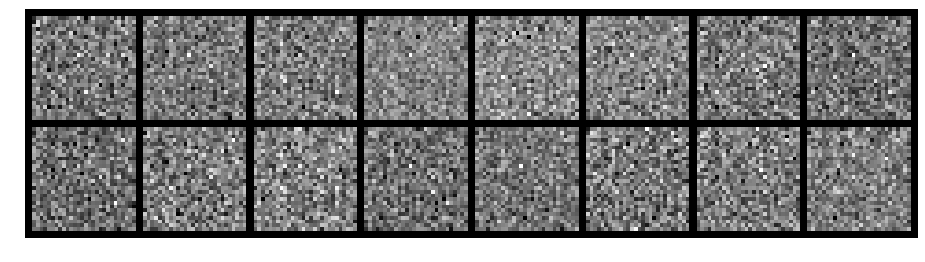

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.4162, Generator Loss: 0.7137
D(x): 0.4761, D(G(z)): 0.4901


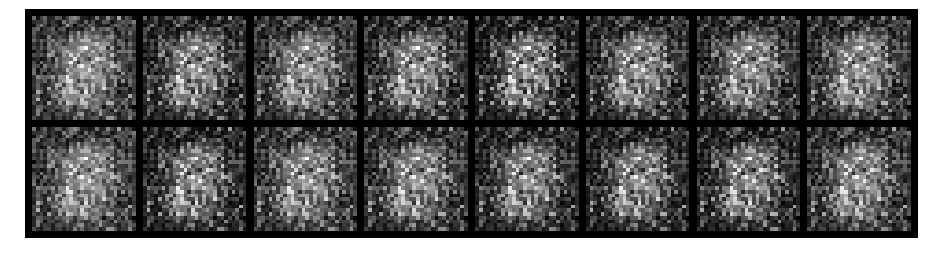

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.6372, Generator Loss: 1.5439
D(x): 0.4868, D(G(z)): 0.4814


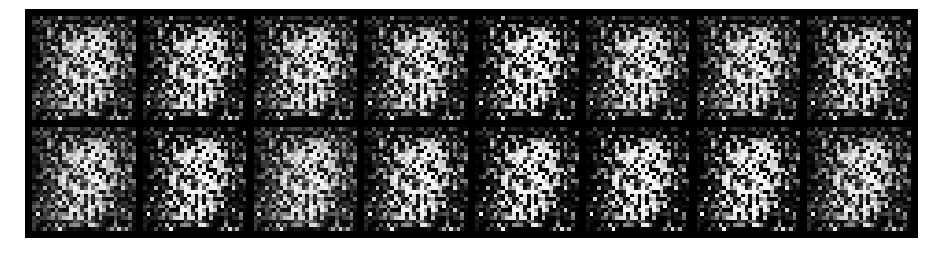

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.5276, Generator Loss: 3.8328
D(x): 0.7885, D(G(z)): 0.1903


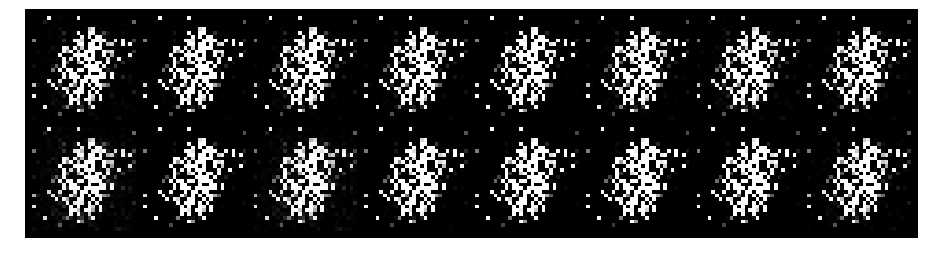

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.0174, Generator Loss: 8.2152
D(x): 0.9894, D(G(z)): 0.0060


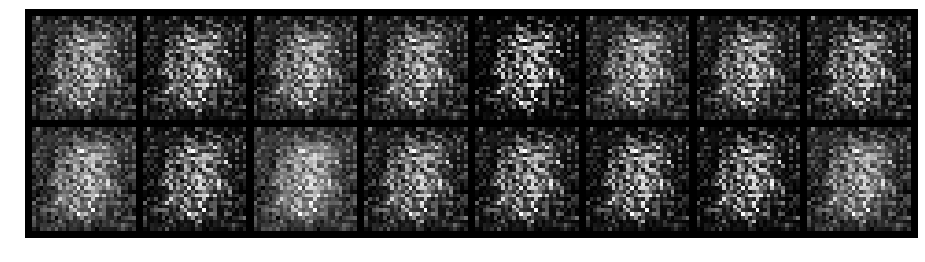

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.5614, Generator Loss: 5.0412
D(x): 0.7431, D(G(z)): 0.0977


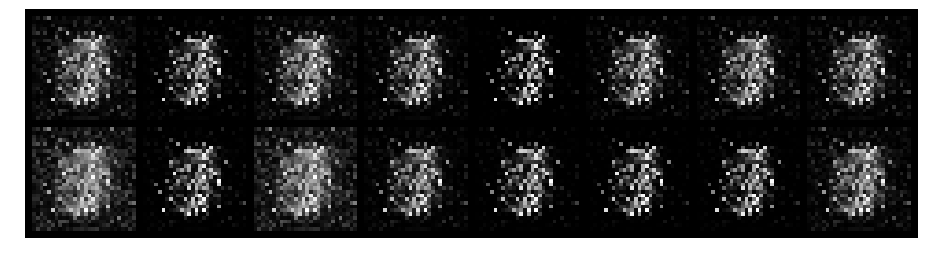

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 1.4393, Generator Loss: 0.8113
D(x): 0.5234, D(G(z)): 0.4880


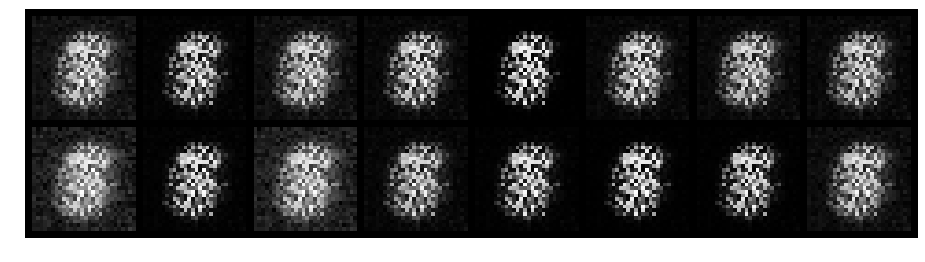

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.5757, Generator Loss: 2.6125
D(x): 0.8437, D(G(z)): 0.2546


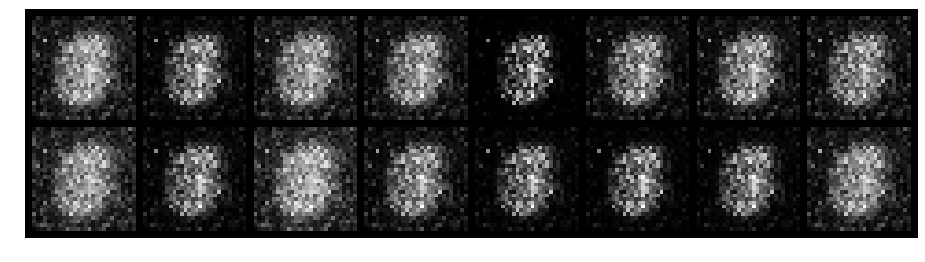

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 1.4107, Generator Loss: 1.5778
D(x): 0.5425, D(G(z)): 0.4087


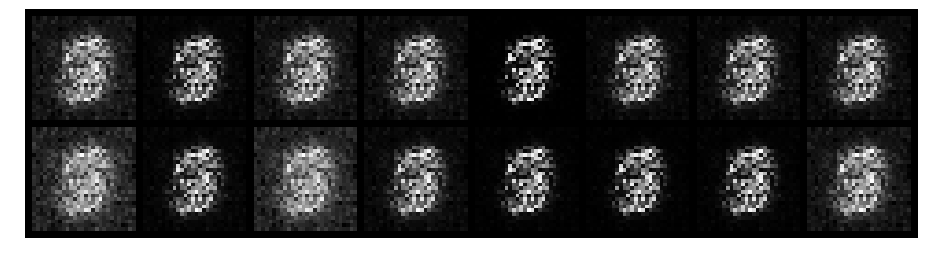

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.6913, Generator Loss: 2.0673
D(x): 0.7562, D(G(z)): 0.2602


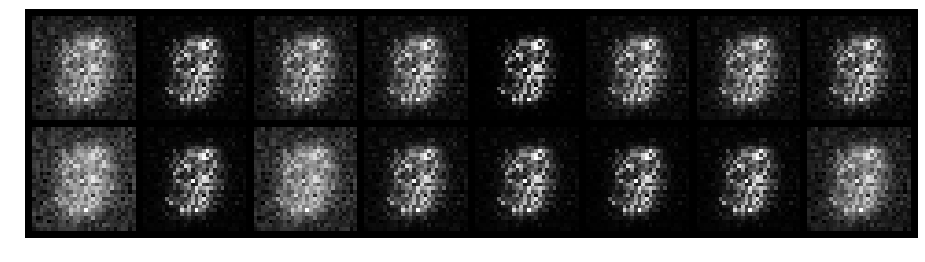

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 1.6242, Generator Loss: 1.6321
D(x): 0.4852, D(G(z)): 0.3581


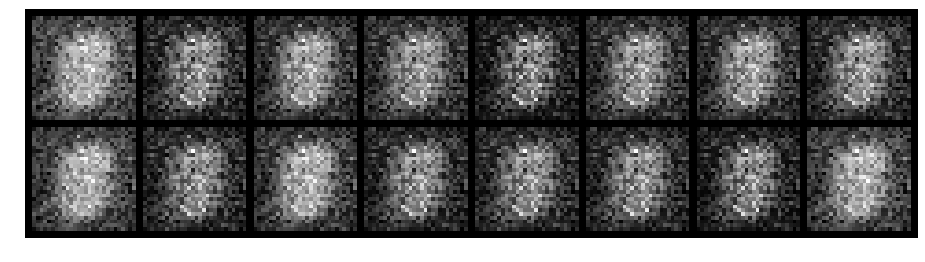

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.8434, Generator Loss: 1.2586
D(x): 0.7460, D(G(z)): 0.3543


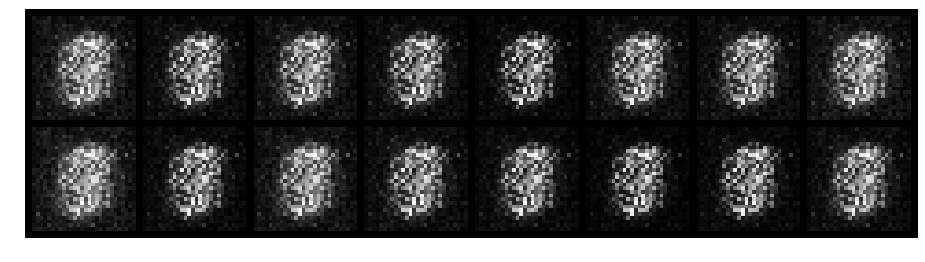

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.7025, Generator Loss: 2.4015
D(x): 0.7692, D(G(z)): 0.2671


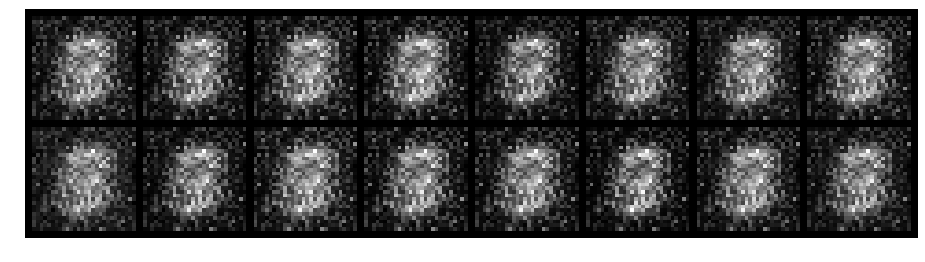

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 1.4320, Generator Loss: 1.9481
D(x): 0.6030, D(G(z)): 0.3501


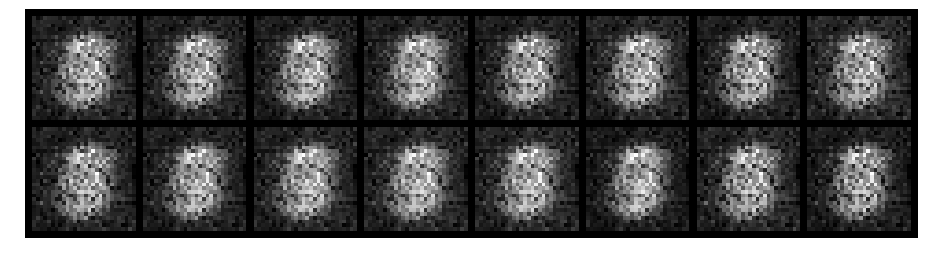

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 1.3761, Generator Loss: 0.6853
D(x): 0.5847, D(G(z)): 0.5219


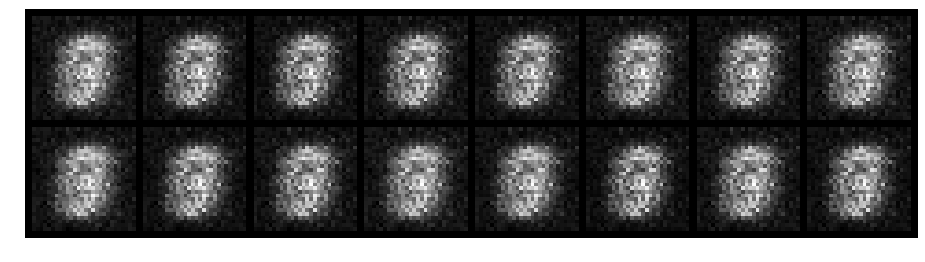

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.9411, Generator Loss: 1.2778
D(x): 0.6620, D(G(z)): 0.3362


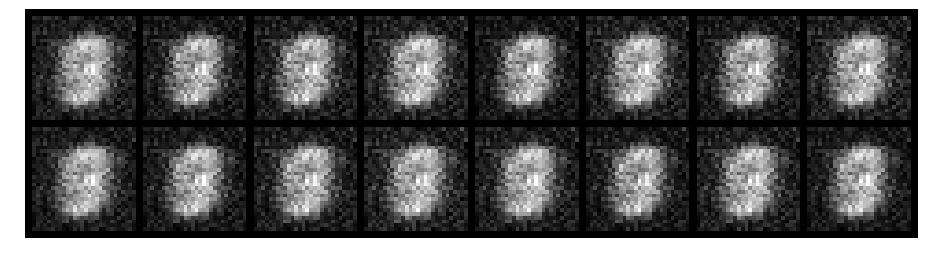

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 1.4823, Generator Loss: 1.0773
D(x): 0.6753, D(G(z)): 0.4915


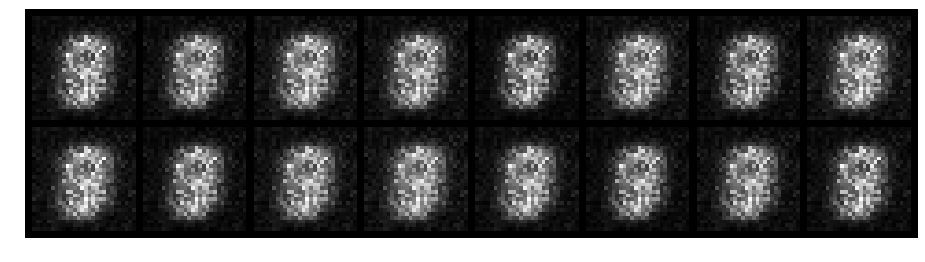

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 0.4111, Generator Loss: 2.5148
D(x): 0.8008, D(G(z)): 0.1275


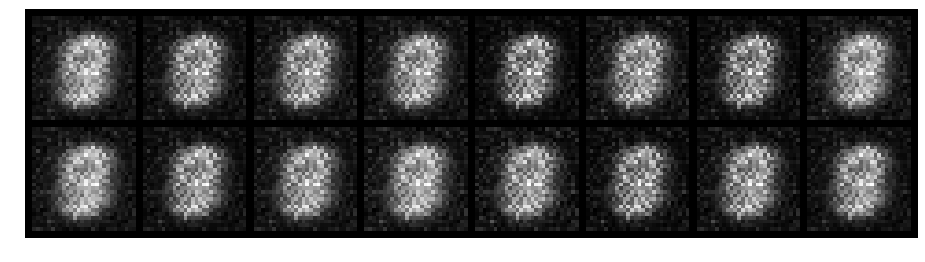

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.8460, Generator Loss: 1.9382
D(x): 0.8046, D(G(z)): 0.3359


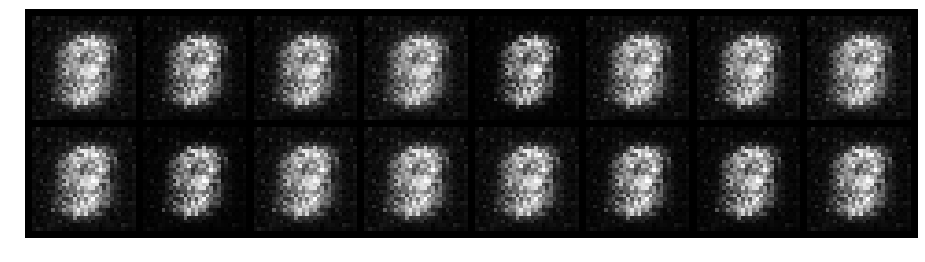

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.4317, Generator Loss: 2.3060
D(x): 0.8019, D(G(z)): 0.1602


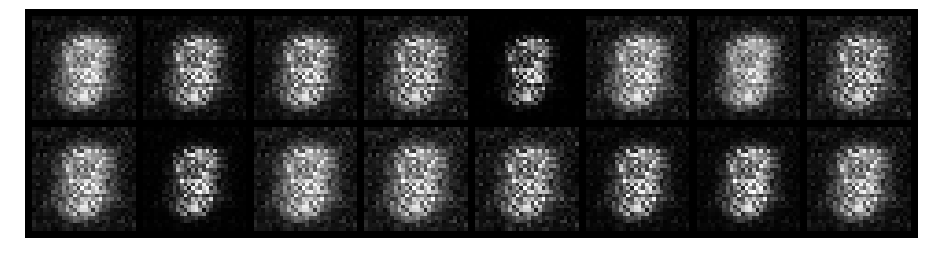

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.3872, Generator Loss: 2.4495
D(x): 0.8406, D(G(z)): 0.1609


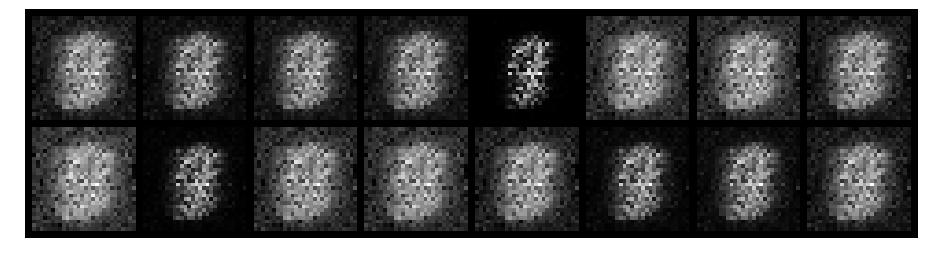

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.5297, Generator Loss: 1.6512
D(x): 0.8907, D(G(z)): 0.2692


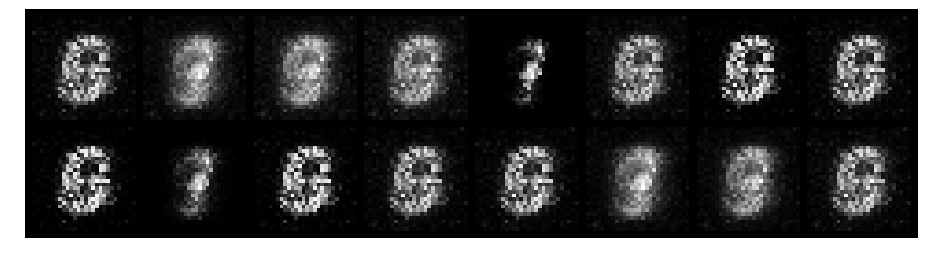

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 1.2256, Generator Loss: 1.8602
D(x): 0.5620, D(G(z)): 0.1566


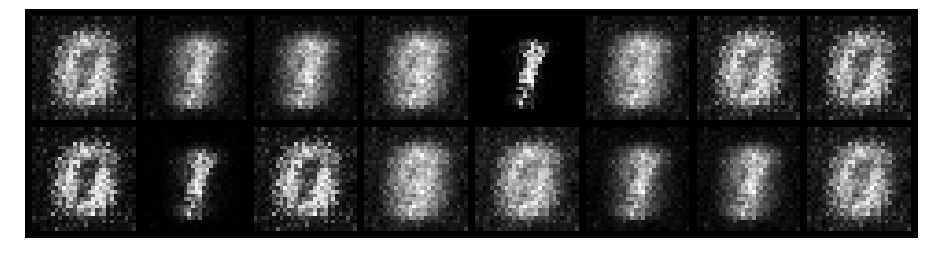

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.4077, Generator Loss: 3.0392
D(x): 0.8807, D(G(z)): 0.1707


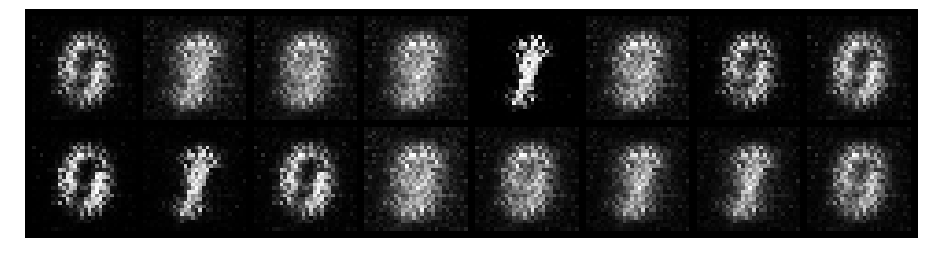

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.1622, Generator Loss: 4.7824
D(x): 0.9259, D(G(z)): 0.0531


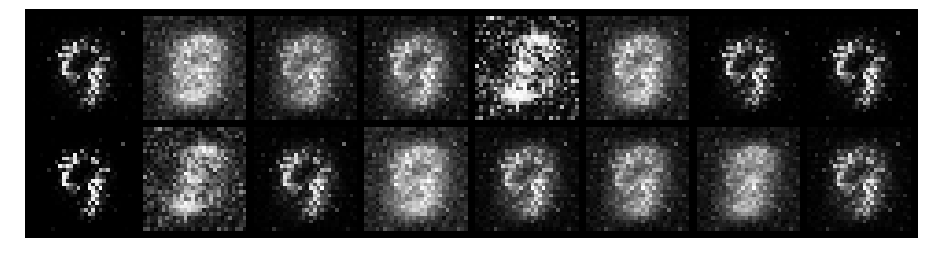

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.5698, Generator Loss: 3.4112
D(x): 0.8385, D(G(z)): 0.1562


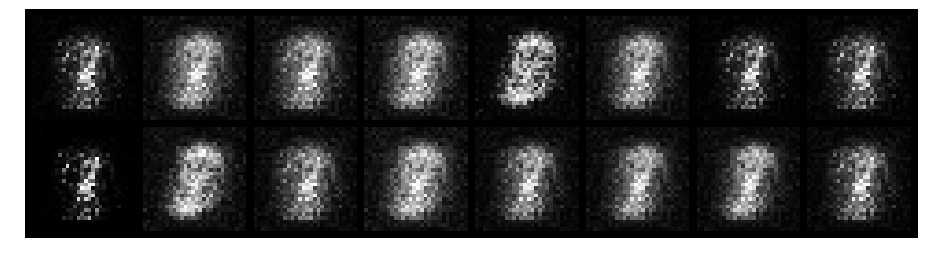

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.6804, Generator Loss: 2.2074
D(x): 0.8304, D(G(z)): 0.2278


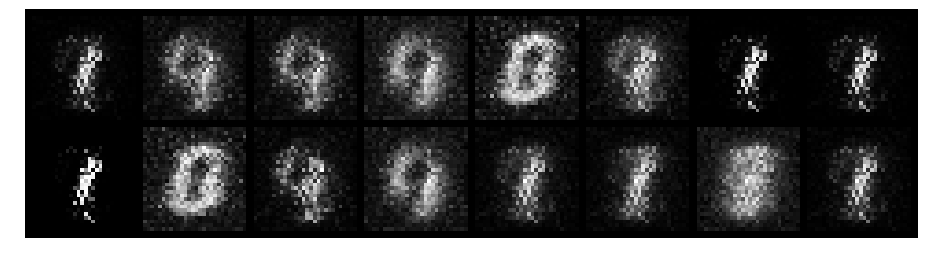

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.5479, Generator Loss: 2.2547
D(x): 0.8525, D(G(z)): 0.1553


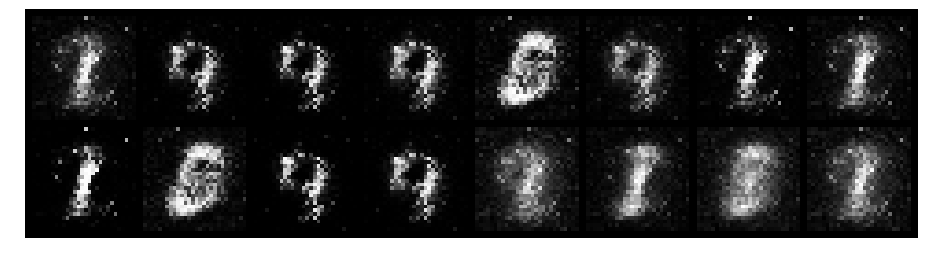

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.4926, Generator Loss: 2.4333
D(x): 0.8415, D(G(z)): 0.1564


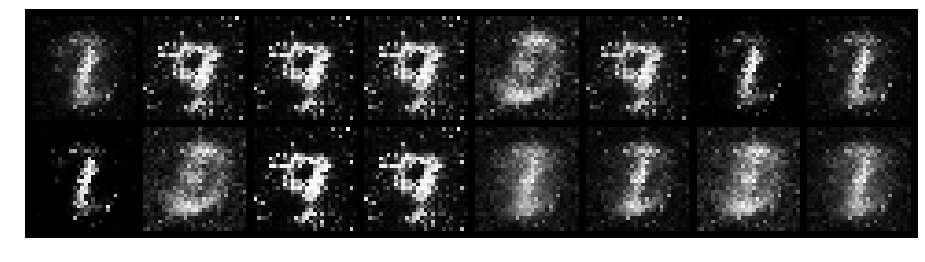

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.7105, Generator Loss: 3.0029
D(x): 0.7458, D(G(z)): 0.0874


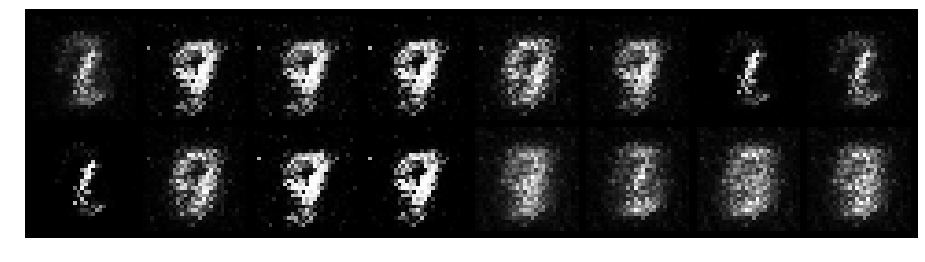

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.6801, Generator Loss: 2.0742
D(x): 0.8537, D(G(z)): 0.2470


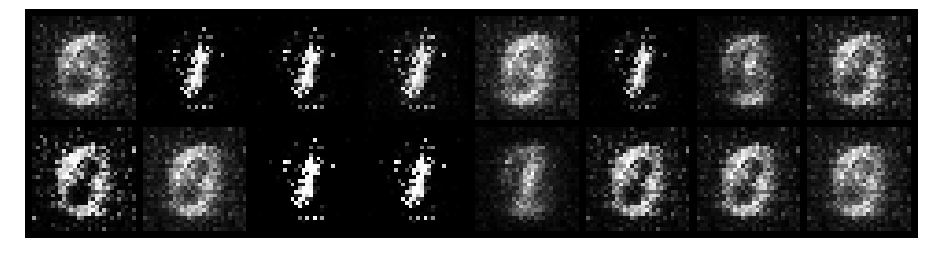

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.6305, Generator Loss: 1.9554
D(x): 0.8471, D(G(z)): 0.2407


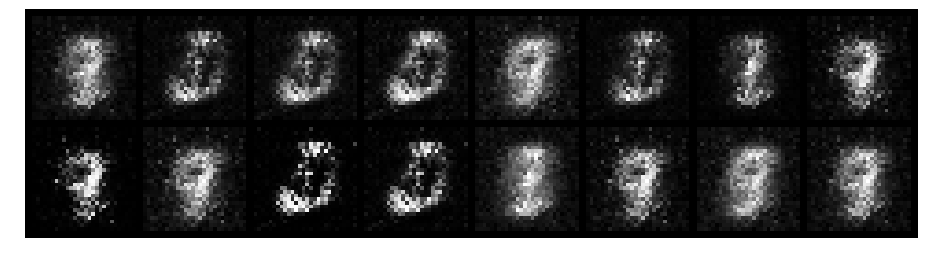

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.9172, Generator Loss: 2.1080
D(x): 0.6705, D(G(z)): 0.2213


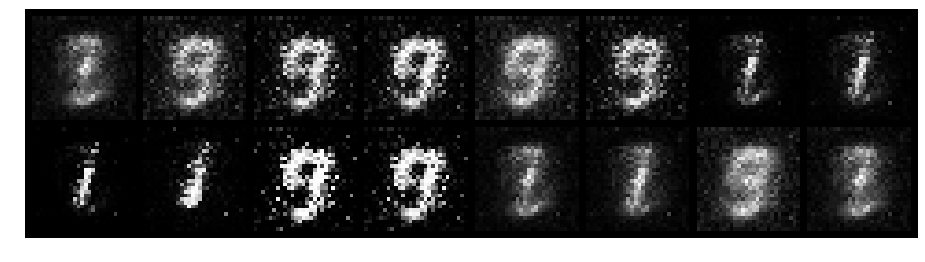

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.6225, Generator Loss: 2.6817
D(x): 0.8888, D(G(z)): 0.2298


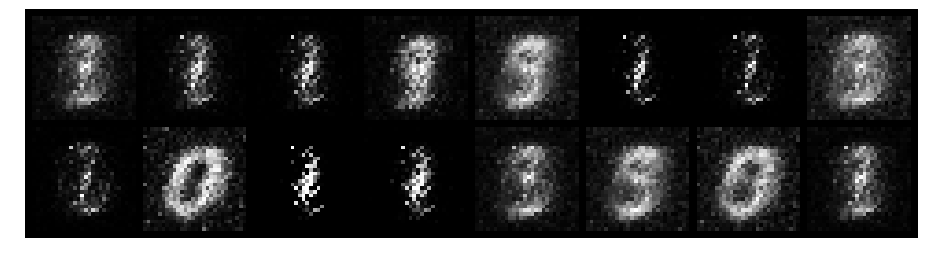

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.5062, Generator Loss: 2.6460
D(x): 0.8526, D(G(z)): 0.1813


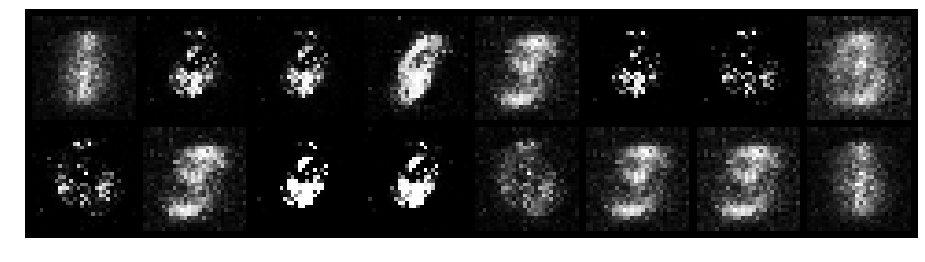

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.6393, Generator Loss: 2.1084
D(x): 0.8575, D(G(z)): 0.2571


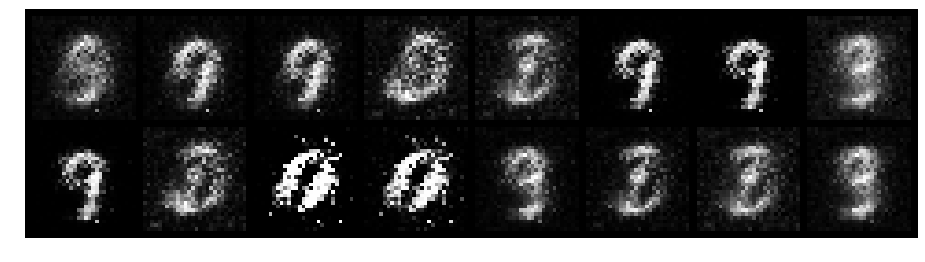

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 1.0881, Generator Loss: 2.9157
D(x): 0.6388, D(G(z)): 0.1298


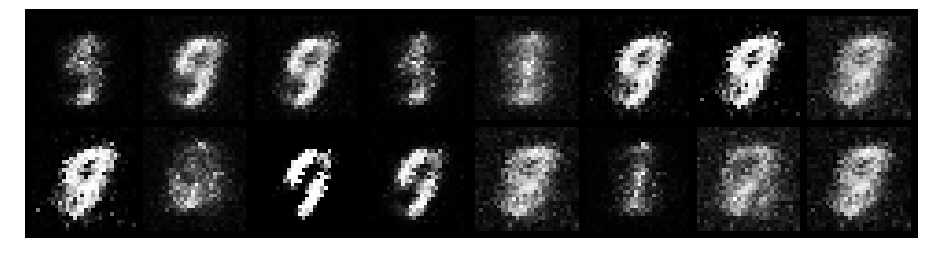

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.6438, Generator Loss: 2.8262
D(x): 0.8024, D(G(z)): 0.1891


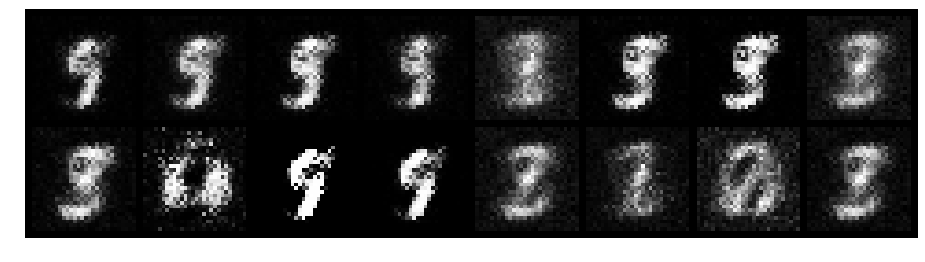

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 1.0107, Generator Loss: 2.0055
D(x): 0.7518, D(G(z)): 0.3290


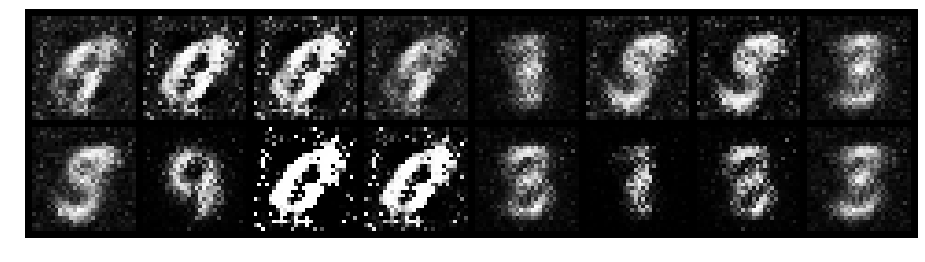

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.6427, Generator Loss: 1.9048
D(x): 0.8090, D(G(z)): 0.1933


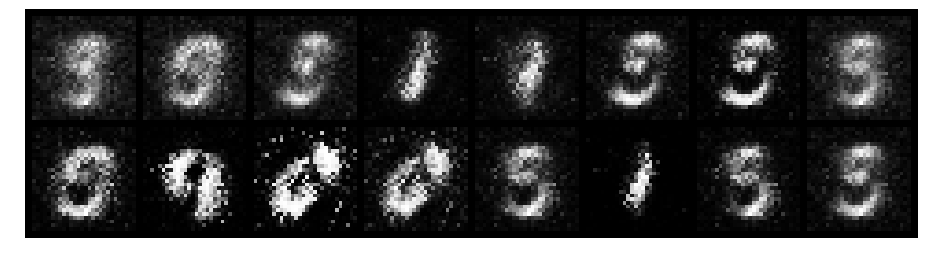

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.5260, Generator Loss: 2.2429
D(x): 0.8478, D(G(z)): 0.1862


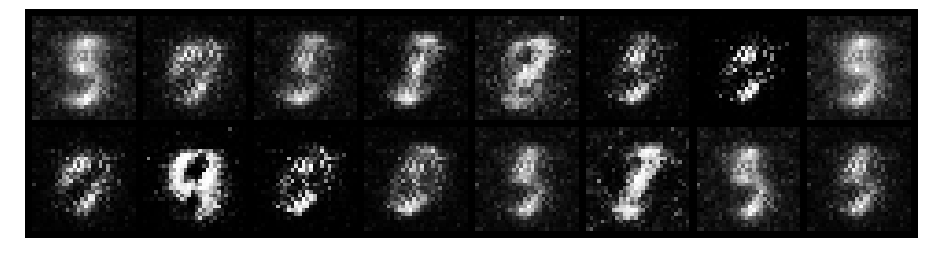

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.4706, Generator Loss: 2.3308
D(x): 0.8482, D(G(z)): 0.1519


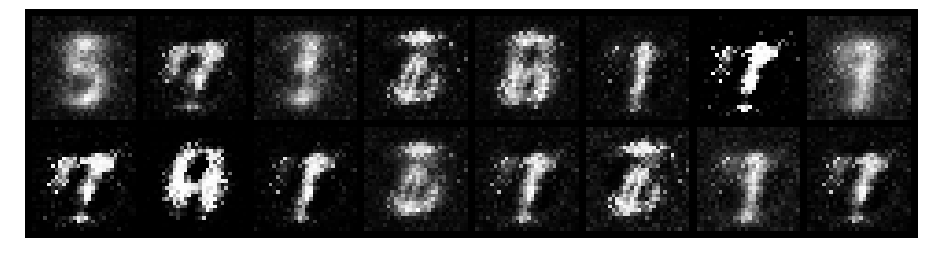

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.6006, Generator Loss: 2.6936
D(x): 0.8404, D(G(z)): 0.2172


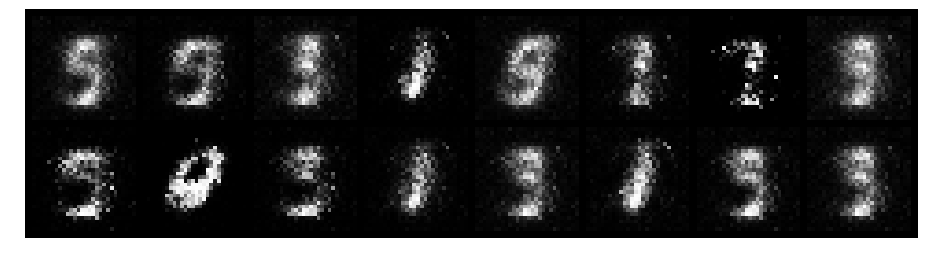

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.4690, Generator Loss: 2.8062
D(x): 0.8298, D(G(z)): 0.1262


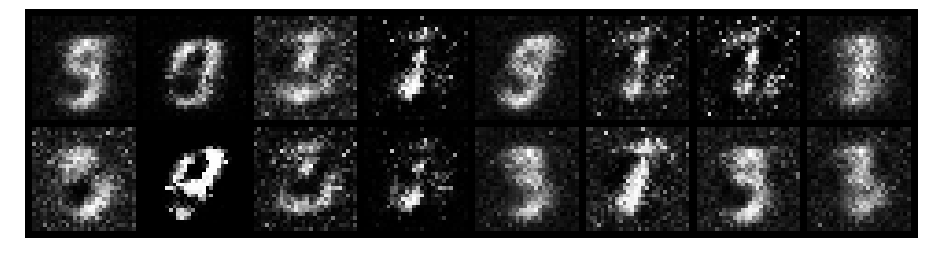

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.5921, Generator Loss: 2.4228
D(x): 0.8004, D(G(z)): 0.1809


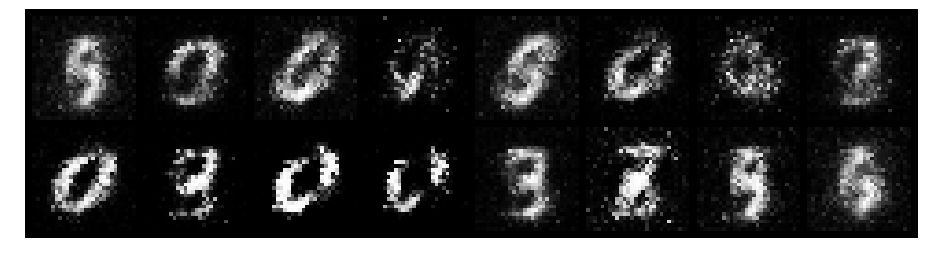

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 1.0770, Generator Loss: 2.3730
D(x): 0.6986, D(G(z)): 0.2199


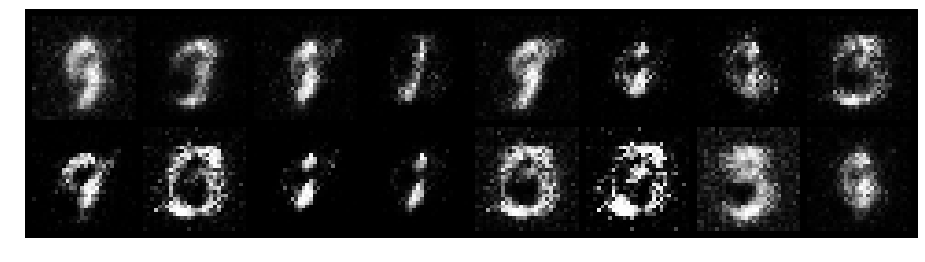

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.7411, Generator Loss: 1.9607
D(x): 0.8040, D(G(z)): 0.2565


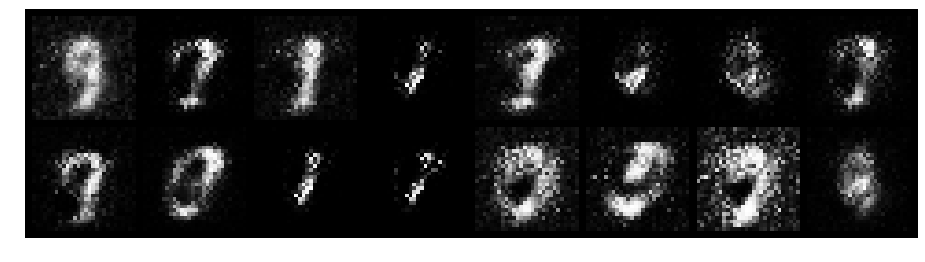

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.8092, Generator Loss: 2.7434
D(x): 0.7111, D(G(z)): 0.1558


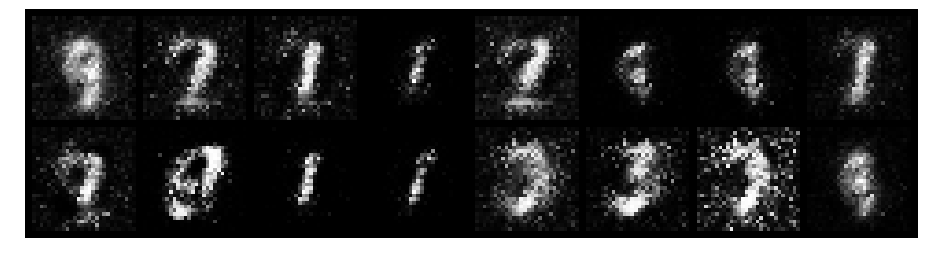

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.8429, Generator Loss: 2.2524
D(x): 0.7767, D(G(z)): 0.2078


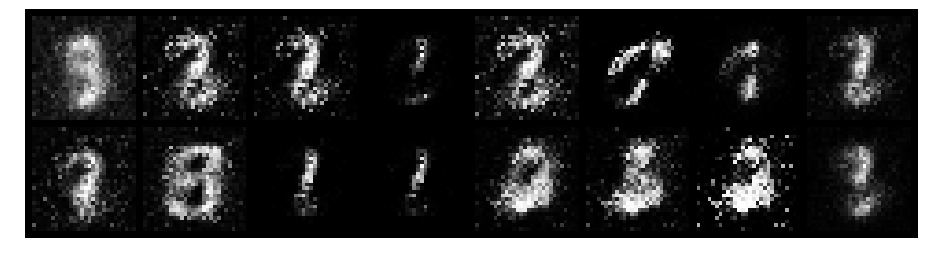

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.6068, Generator Loss: 2.4537
D(x): 0.8048, D(G(z)): 0.1592


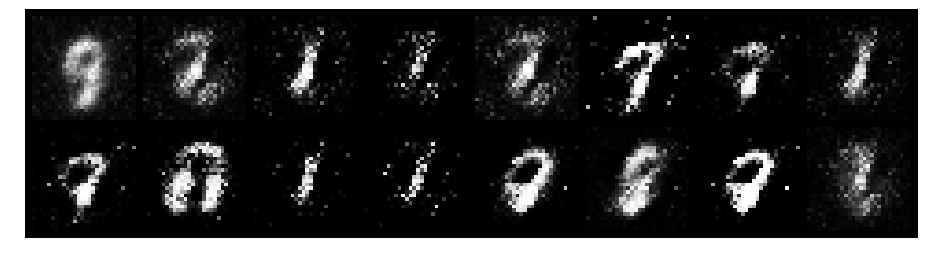

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.7359, Generator Loss: 2.6151
D(x): 0.7223, D(G(z)): 0.1457


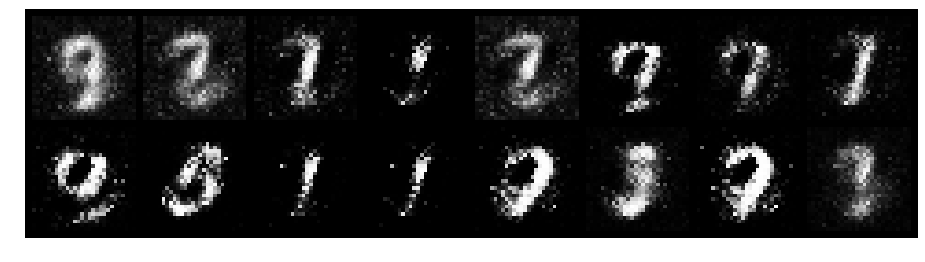

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 0.3964, Generator Loss: 2.8038
D(x): 0.8307, D(G(z)): 0.0992


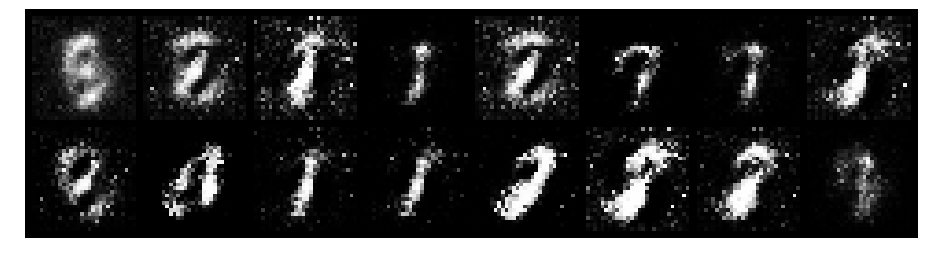

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.4164, Generator Loss: 3.2700
D(x): 0.8656, D(G(z)): 0.1291


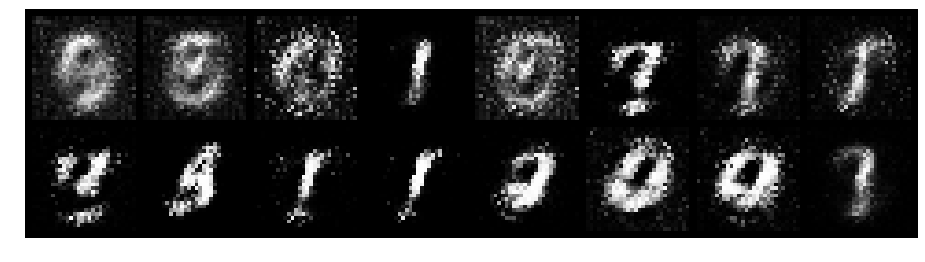

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.3756, Generator Loss: 2.7121
D(x): 0.8917, D(G(z)): 0.1542


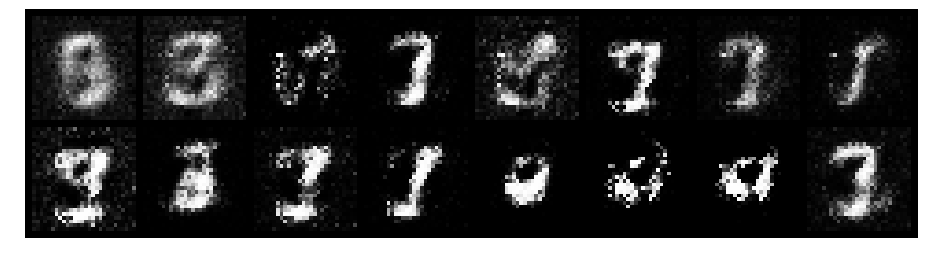

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.8596, Generator Loss: 2.0292
D(x): 0.7939, D(G(z)): 0.2875


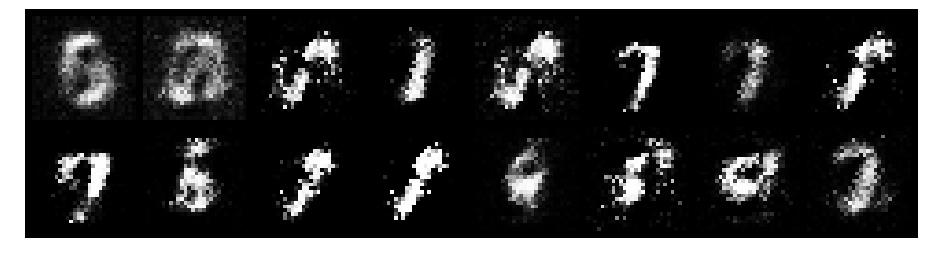

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.4167, Generator Loss: 3.4919
D(x): 0.8518, D(G(z)): 0.1127


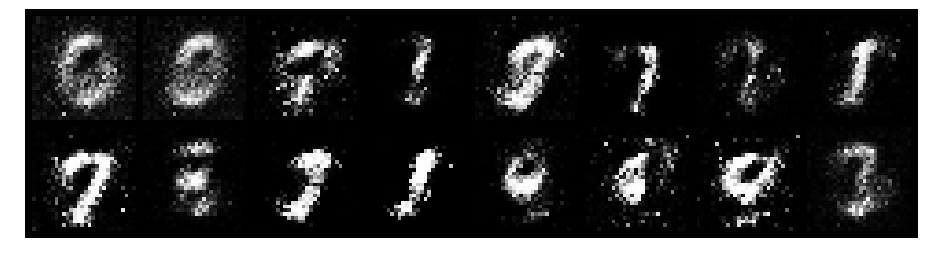

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.5086, Generator Loss: 2.4985
D(x): 0.8313, D(G(z)): 0.1359


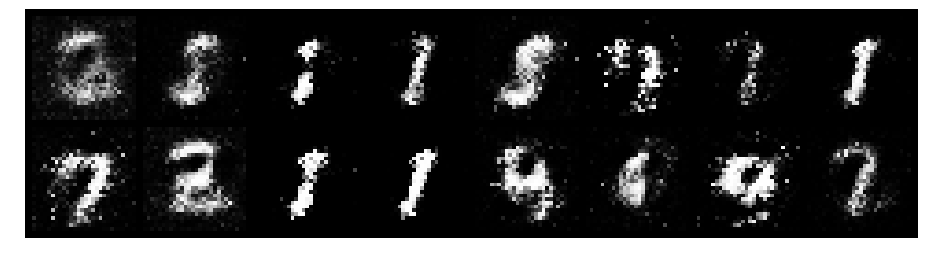

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.3585, Generator Loss: 3.2276
D(x): 0.8576, D(G(z)): 0.1001


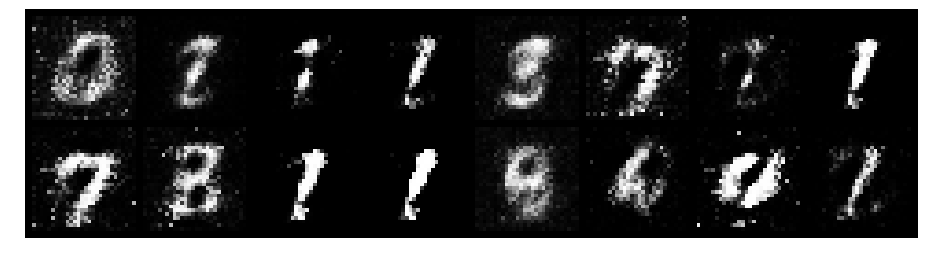

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.8414, Generator Loss: 1.7072
D(x): 0.8113, D(G(z)): 0.3043


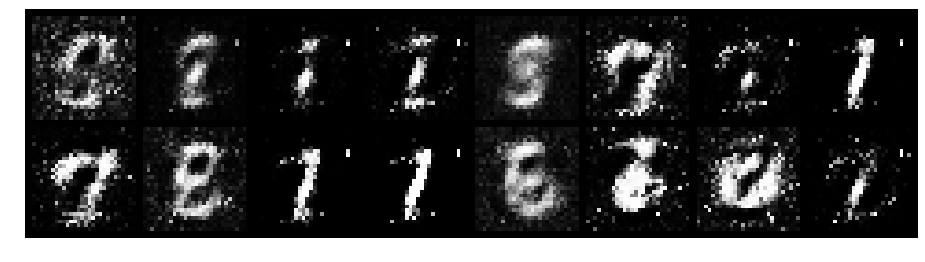

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.7918, Generator Loss: 2.0381
D(x): 0.7751, D(G(z)): 0.2714


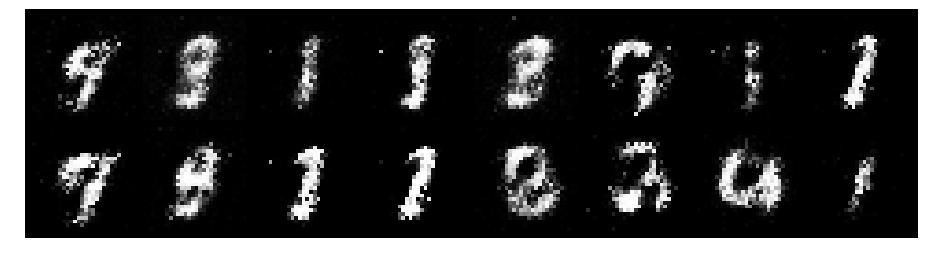

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.3262, Generator Loss: 2.6842
D(x): 0.9118, D(G(z)): 0.1434


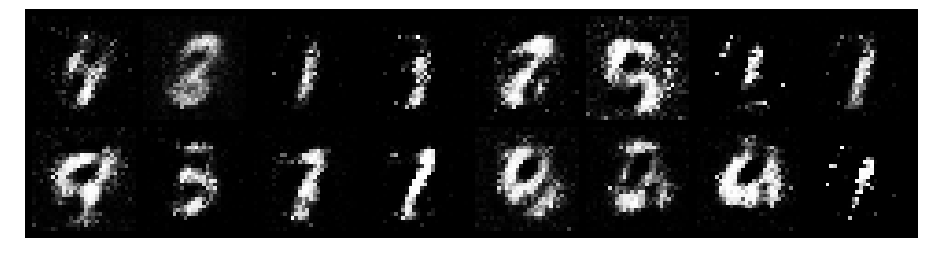

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.4338, Generator Loss: 2.6997
D(x): 0.8553, D(G(z)): 0.1658


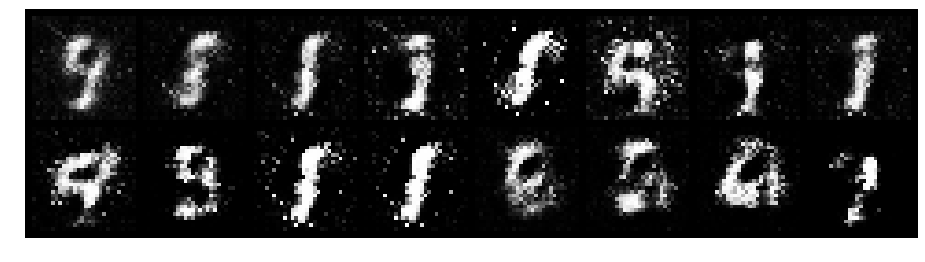

Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.6917, Generator Loss: 2.4375
D(x): 0.8194, D(G(z)): 0.2335


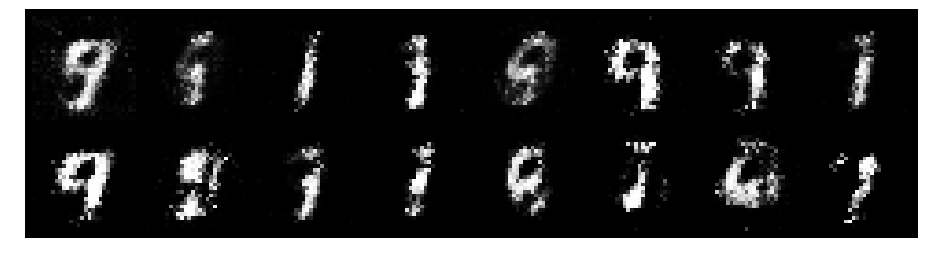

Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 0.7806, Generator Loss: 1.4914
D(x): 0.7794, D(G(z)): 0.3007


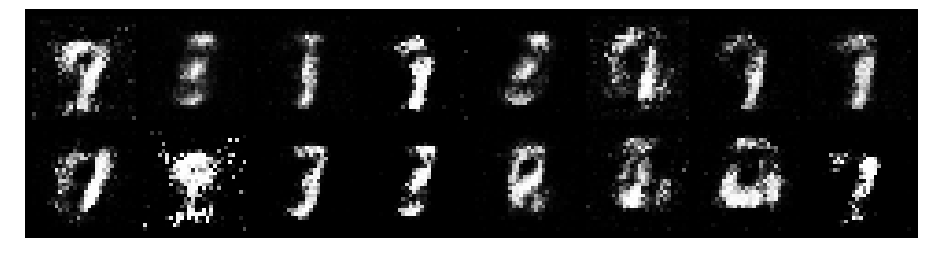

Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 0.7179, Generator Loss: 1.7703
D(x): 0.7661, D(G(z)): 0.2383


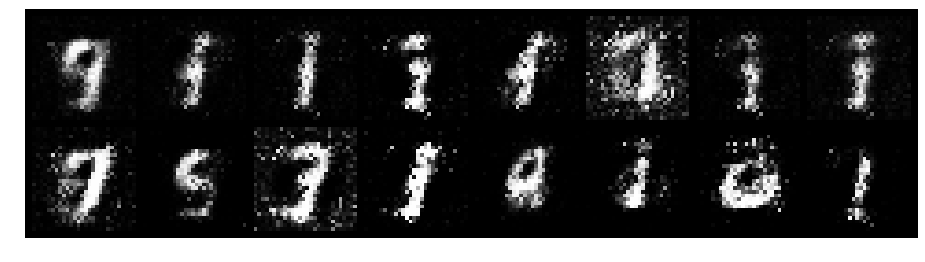

Epoch: [10/200], Batch Num: [400/600]
Discriminator Loss: 0.3463, Generator Loss: 2.7952
D(x): 0.8968, D(G(z)): 0.1664


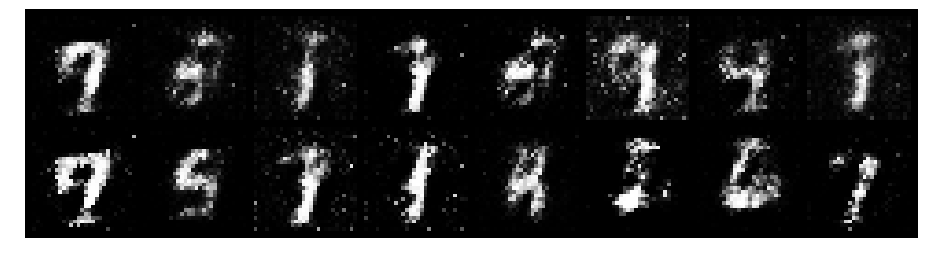

Epoch: [10/200], Batch Num: [500/600]
Discriminator Loss: 0.5010, Generator Loss: 2.7647
D(x): 0.8312, D(G(z)): 0.1704


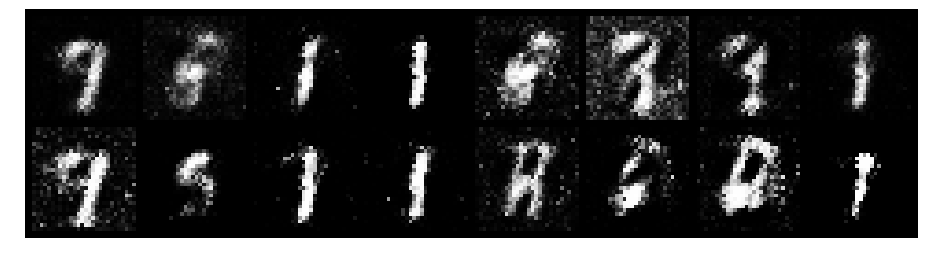

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.7427, Generator Loss: 1.9091
D(x): 0.7973, D(G(z)): 0.2305


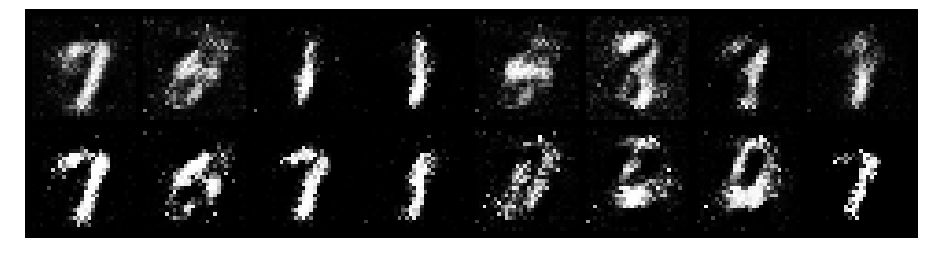

Epoch: [11/200], Batch Num: [100/600]
Discriminator Loss: 0.5202, Generator Loss: 2.5344
D(x): 0.8857, D(G(z)): 0.2313


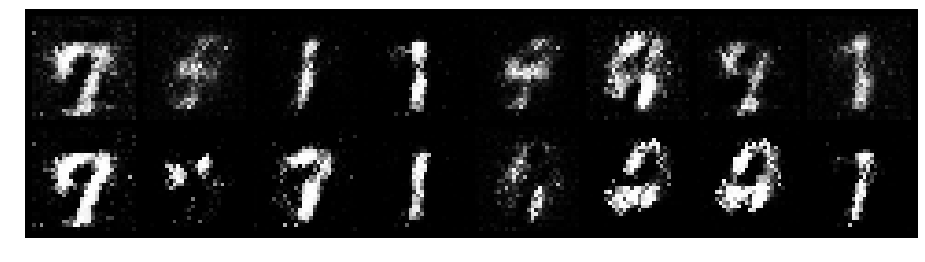

Epoch: [11/200], Batch Num: [200/600]
Discriminator Loss: 0.7759, Generator Loss: 2.0788
D(x): 0.7252, D(G(z)): 0.2217


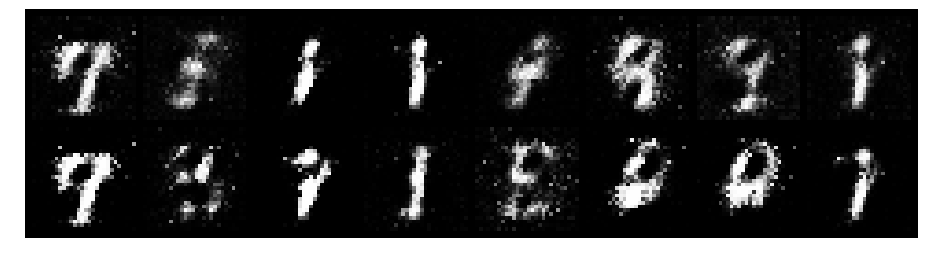

Epoch: [11/200], Batch Num: [300/600]
Discriminator Loss: 0.7184, Generator Loss: 2.1607
D(x): 0.7510, D(G(z)): 0.1977


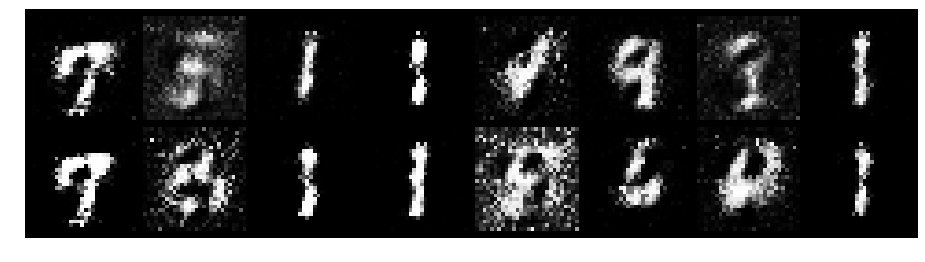

Epoch: [11/200], Batch Num: [400/600]
Discriminator Loss: 0.9064, Generator Loss: 2.0484
D(x): 0.7152, D(G(z)): 0.2176


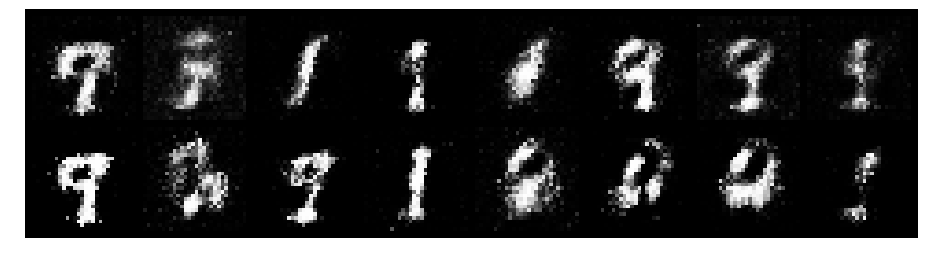

Epoch: [11/200], Batch Num: [500/600]
Discriminator Loss: 0.8222, Generator Loss: 1.7212
D(x): 0.6866, D(G(z)): 0.2439


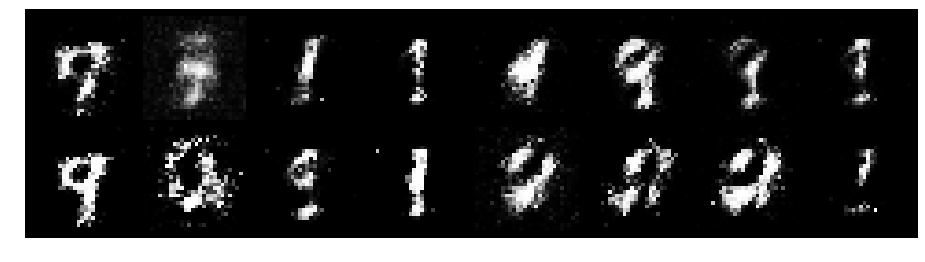

Epoch: [12/200], Batch Num: [0/600]
Discriminator Loss: 0.9841, Generator Loss: 1.8339
D(x): 0.7347, D(G(z)): 0.2970


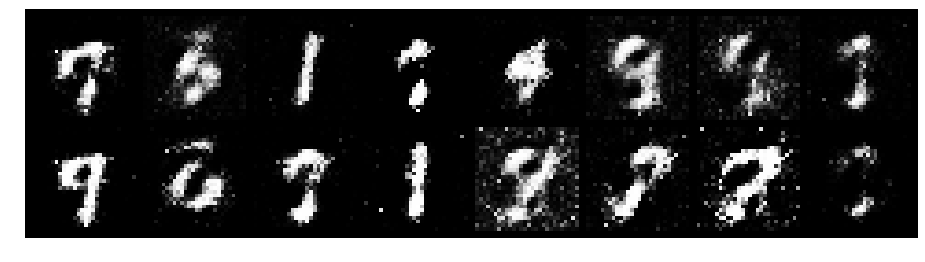

Epoch: [12/200], Batch Num: [100/600]
Discriminator Loss: 0.8602, Generator Loss: 1.6462
D(x): 0.8387, D(G(z)): 0.3685


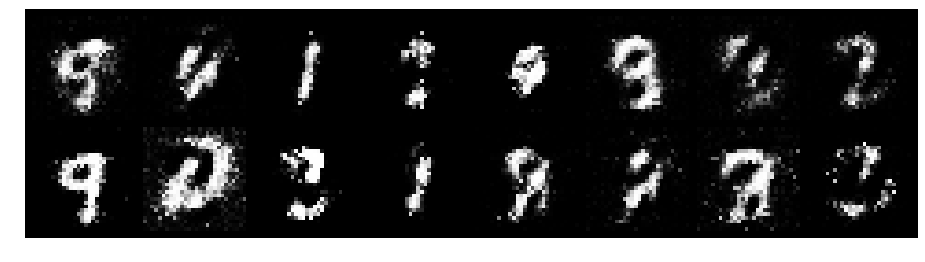

Epoch: [12/200], Batch Num: [200/600]
Discriminator Loss: 0.6851, Generator Loss: 1.7965
D(x): 0.8080, D(G(z)): 0.2261


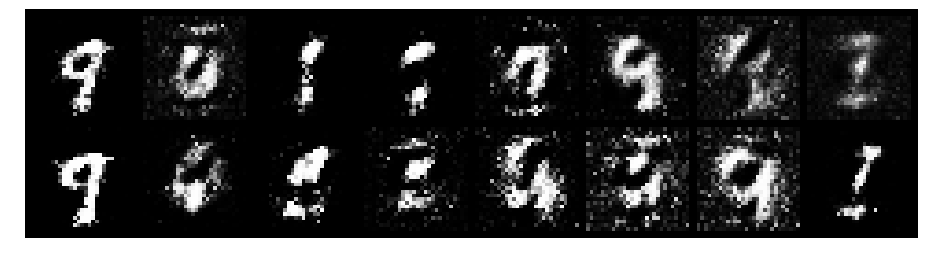

Epoch: [12/200], Batch Num: [300/600]
Discriminator Loss: 0.9683, Generator Loss: 1.9167
D(x): 0.7437, D(G(z)): 0.2896


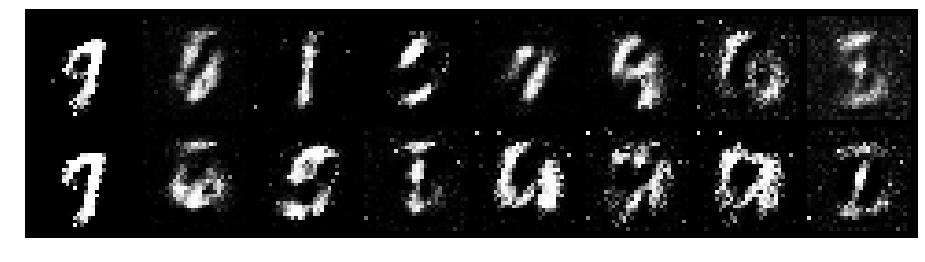

Epoch: [12/200], Batch Num: [400/600]
Discriminator Loss: 0.7451, Generator Loss: 1.8575
D(x): 0.7911, D(G(z)): 0.2776


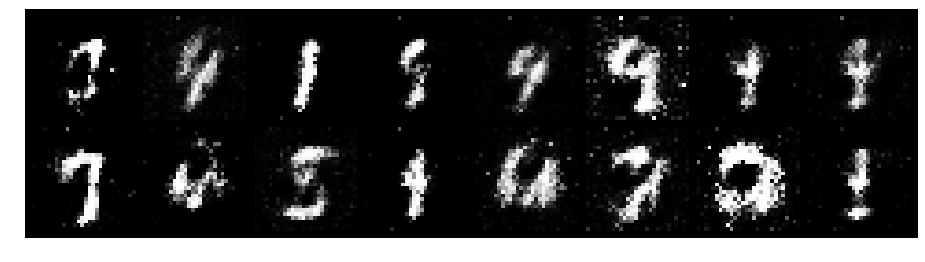

Epoch: [12/200], Batch Num: [500/600]
Discriminator Loss: 1.0120, Generator Loss: 1.9466
D(x): 0.7989, D(G(z)): 0.4038


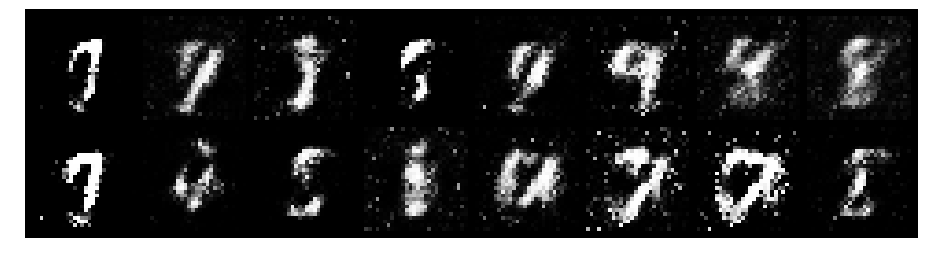

Epoch: [13/200], Batch Num: [0/600]
Discriminator Loss: 0.7722, Generator Loss: 1.5343
D(x): 0.8449, D(G(z)): 0.3502


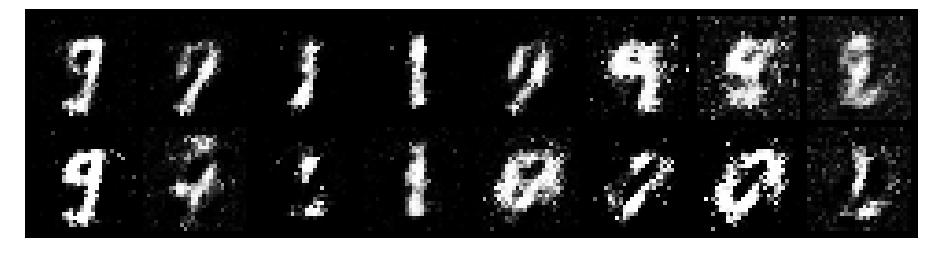

Epoch: [13/200], Batch Num: [100/600]
Discriminator Loss: 0.8968, Generator Loss: 1.5267
D(x): 0.7656, D(G(z)): 0.3154


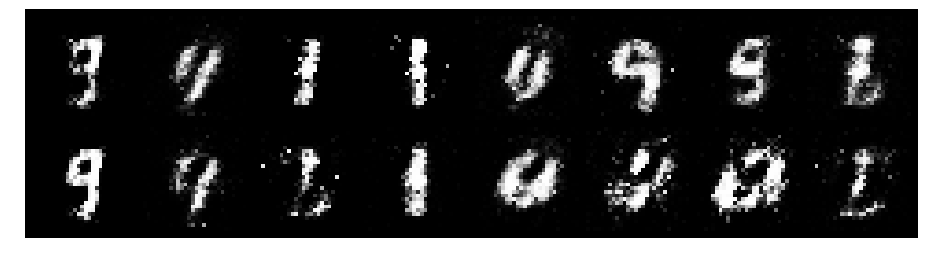

Epoch: [13/200], Batch Num: [200/600]
Discriminator Loss: 0.6423, Generator Loss: 2.7450
D(x): 0.7488, D(G(z)): 0.1452


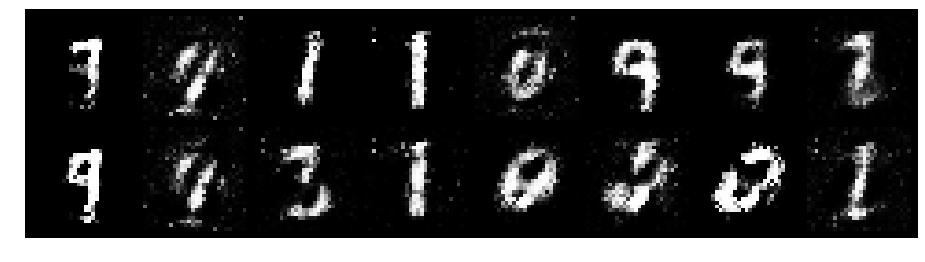

Epoch: [13/200], Batch Num: [300/600]
Discriminator Loss: 0.6053, Generator Loss: 2.9981
D(x): 0.8090, D(G(z)): 0.1610


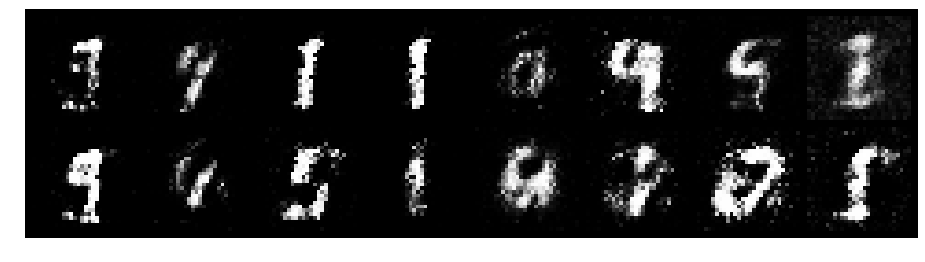

Epoch: [13/200], Batch Num: [400/600]
Discriminator Loss: 0.9487, Generator Loss: 2.0807
D(x): 0.6902, D(G(z)): 0.2496


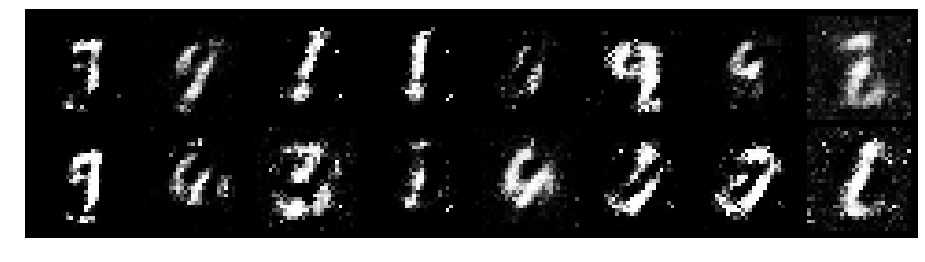

Epoch: [13/200], Batch Num: [500/600]
Discriminator Loss: 0.6225, Generator Loss: 2.5157
D(x): 0.8306, D(G(z)): 0.2158


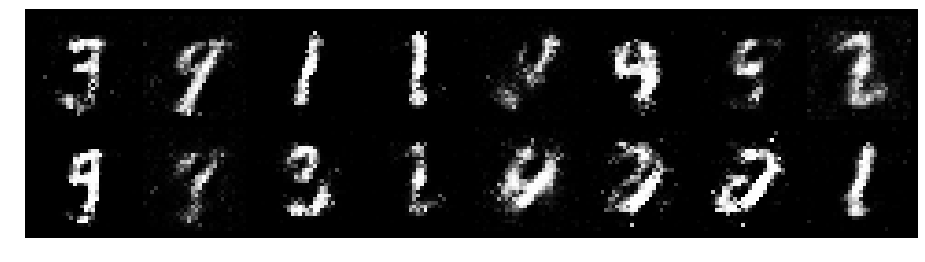

Epoch: [14/200], Batch Num: [0/600]
Discriminator Loss: 0.8894, Generator Loss: 2.7164
D(x): 0.6866, D(G(z)): 0.1421


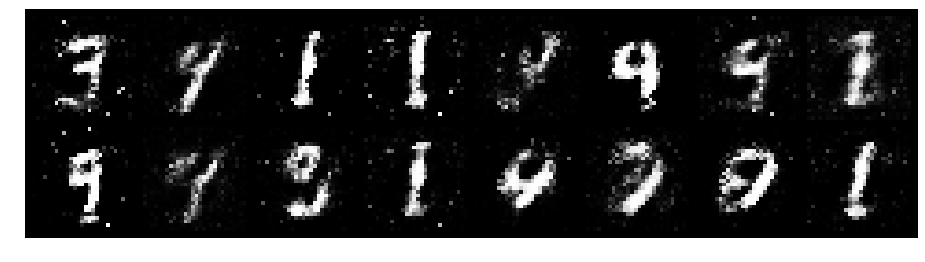

Epoch: [14/200], Batch Num: [100/600]
Discriminator Loss: 0.8965, Generator Loss: 1.8655
D(x): 0.6778, D(G(z)): 0.1969


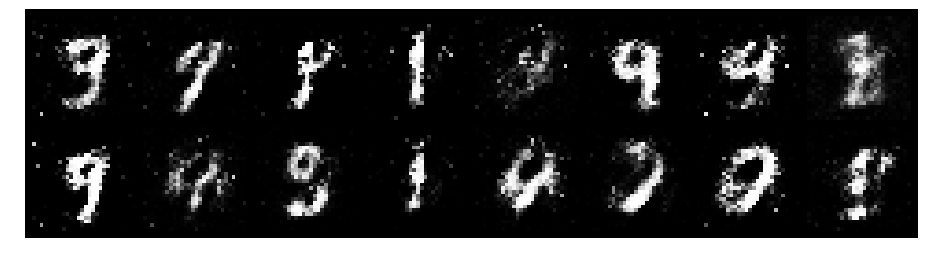

Epoch: [14/200], Batch Num: [200/600]
Discriminator Loss: 0.7664, Generator Loss: 1.9098
D(x): 0.7246, D(G(z)): 0.2042


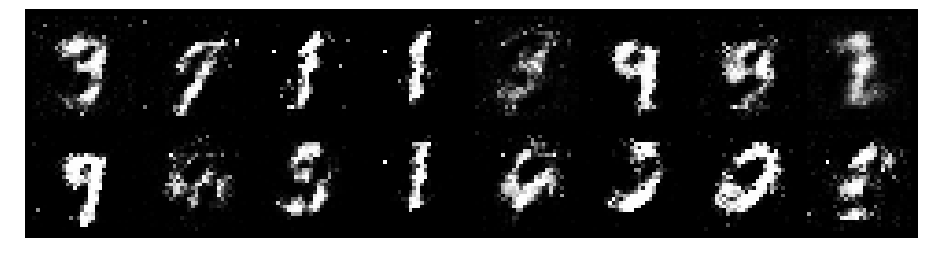

Epoch: [14/200], Batch Num: [300/600]
Discriminator Loss: 0.6753, Generator Loss: 1.8413
D(x): 0.7155, D(G(z)): 0.1943


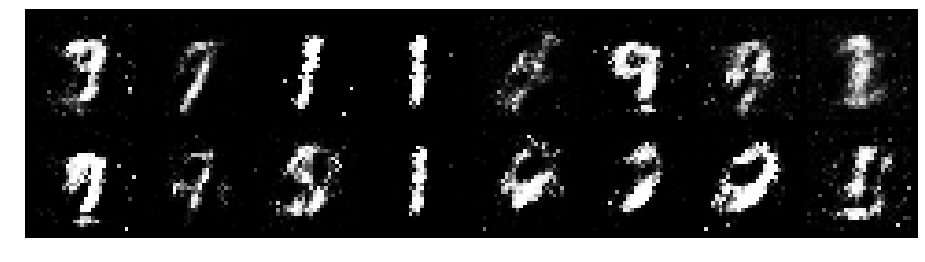

Epoch: [14/200], Batch Num: [400/600]
Discriminator Loss: 0.7255, Generator Loss: 1.6974
D(x): 0.7496, D(G(z)): 0.2515


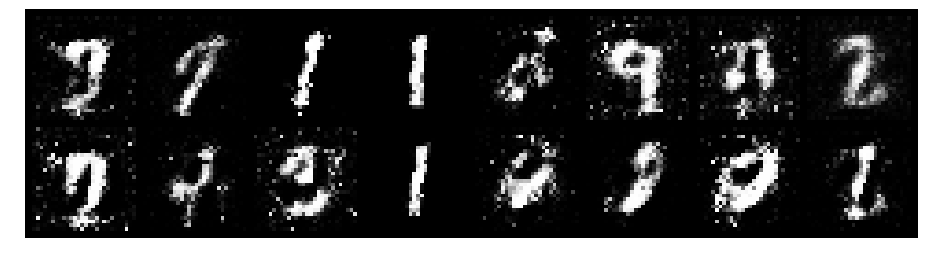

Epoch: [14/200], Batch Num: [500/600]
Discriminator Loss: 0.7721, Generator Loss: 1.8646
D(x): 0.7409, D(G(z)): 0.2737


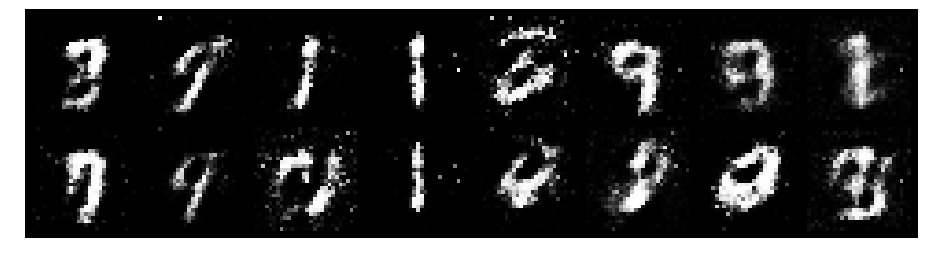

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.9716, Generator Loss: 1.8121
D(x): 0.6367, D(G(z)): 0.2221


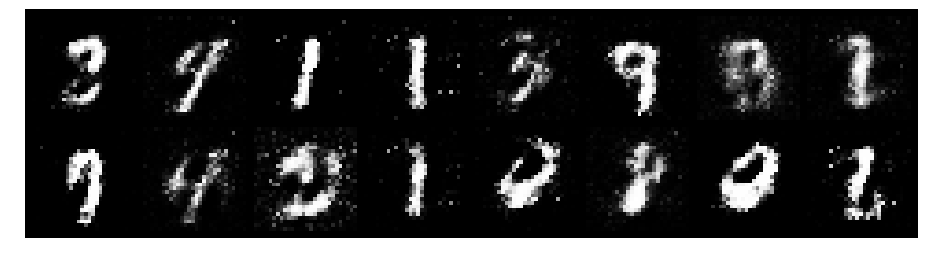

Epoch: [15/200], Batch Num: [100/600]
Discriminator Loss: 0.6683, Generator Loss: 2.5274
D(x): 0.7675, D(G(z)): 0.1980


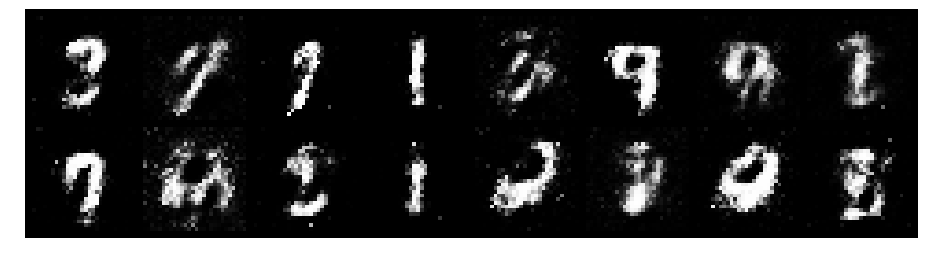

Epoch: [15/200], Batch Num: [200/600]
Discriminator Loss: 0.7074, Generator Loss: 1.8318
D(x): 0.7783, D(G(z)): 0.2752


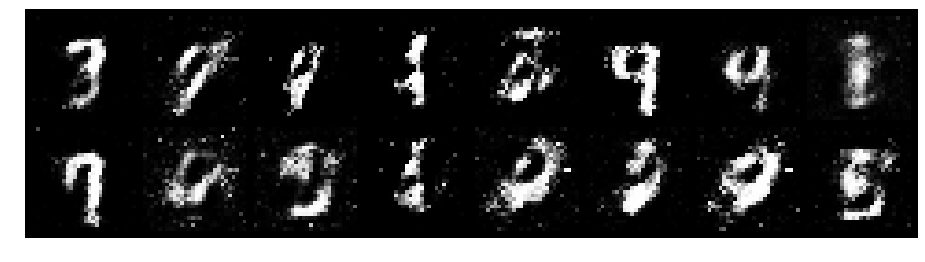

Epoch: [15/200], Batch Num: [300/600]
Discriminator Loss: 0.7916, Generator Loss: 1.6026
D(x): 0.7644, D(G(z)): 0.2856


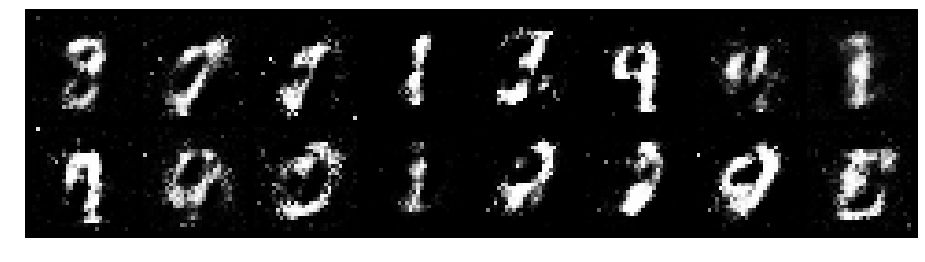

Epoch: [15/200], Batch Num: [400/600]
Discriminator Loss: 0.8472, Generator Loss: 1.7835
D(x): 0.6586, D(G(z)): 0.2099


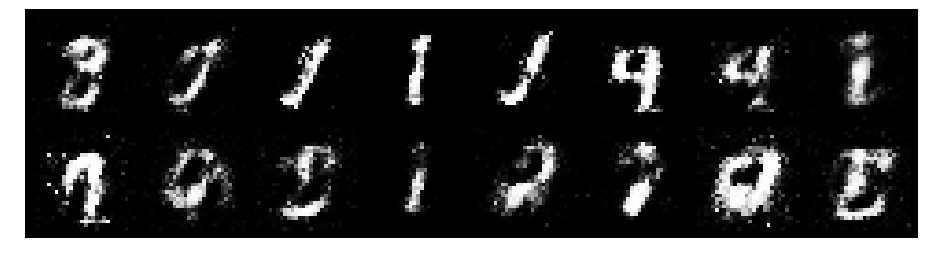

Epoch: [15/200], Batch Num: [500/600]
Discriminator Loss: 0.7093, Generator Loss: 1.7369
D(x): 0.7381, D(G(z)): 0.2212


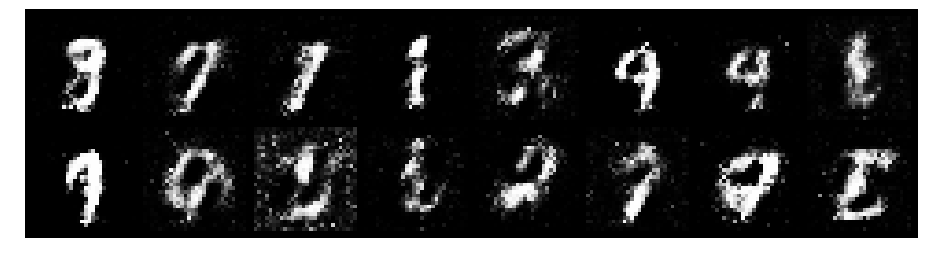

Epoch: [16/200], Batch Num: [0/600]
Discriminator Loss: 0.8374, Generator Loss: 1.9607
D(x): 0.7677, D(G(z)): 0.2725


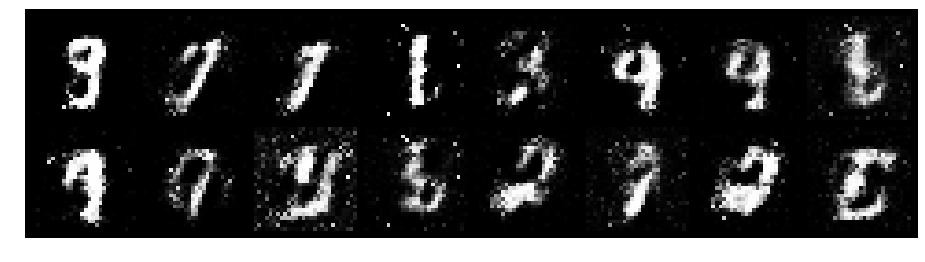

Epoch: [16/200], Batch Num: [100/600]
Discriminator Loss: 0.7257, Generator Loss: 2.2814
D(x): 0.7758, D(G(z)): 0.2245


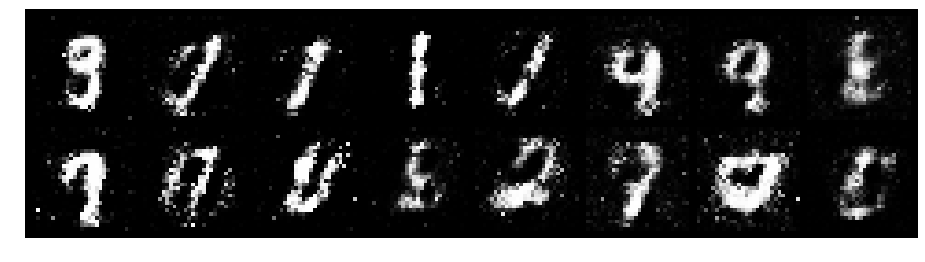

Epoch: [16/200], Batch Num: [200/600]
Discriminator Loss: 0.5537, Generator Loss: 2.1910
D(x): 0.8223, D(G(z)): 0.2110


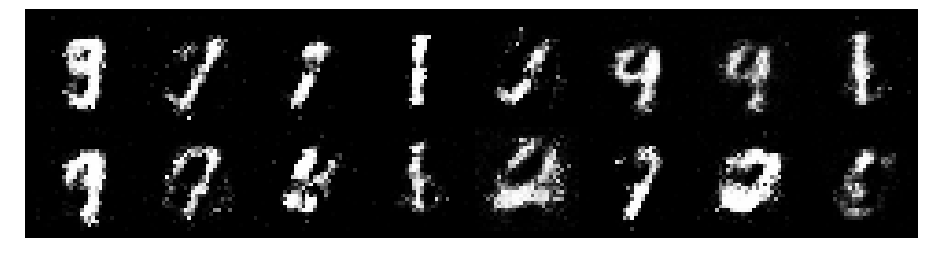

Epoch: [16/200], Batch Num: [300/600]
Discriminator Loss: 0.5993, Generator Loss: 2.2268
D(x): 0.8080, D(G(z)): 0.2139


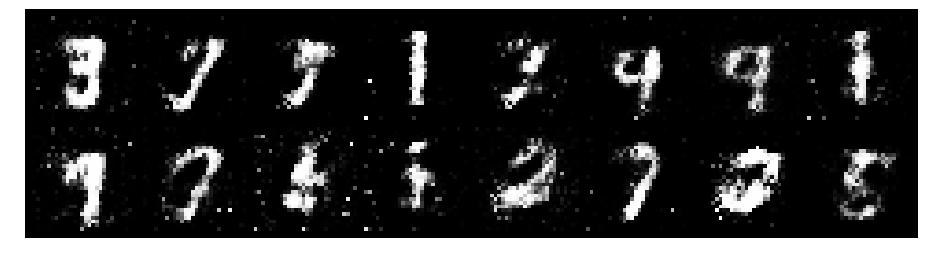

Epoch: [16/200], Batch Num: [400/600]
Discriminator Loss: 0.7819, Generator Loss: 1.8386
D(x): 0.7621, D(G(z)): 0.3021


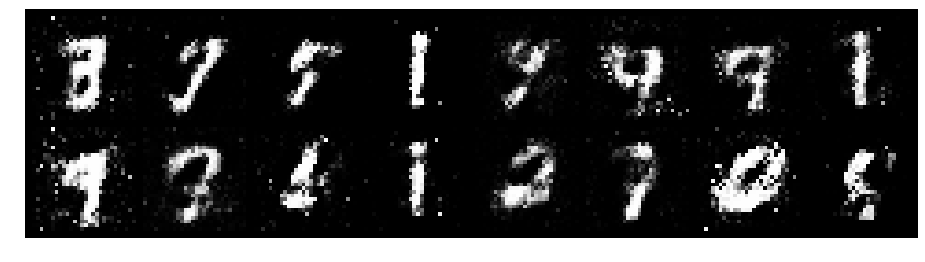

Epoch: [16/200], Batch Num: [500/600]
Discriminator Loss: 0.8076, Generator Loss: 1.5453
D(x): 0.7067, D(G(z)): 0.2765


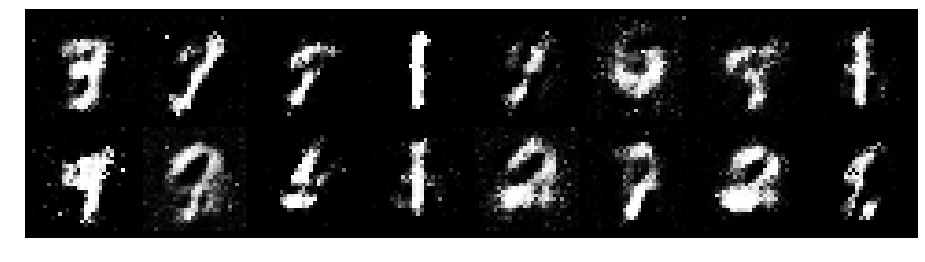

Epoch: [17/200], Batch Num: [0/600]
Discriminator Loss: 1.0800, Generator Loss: 1.6731
D(x): 0.6490, D(G(z)): 0.3186


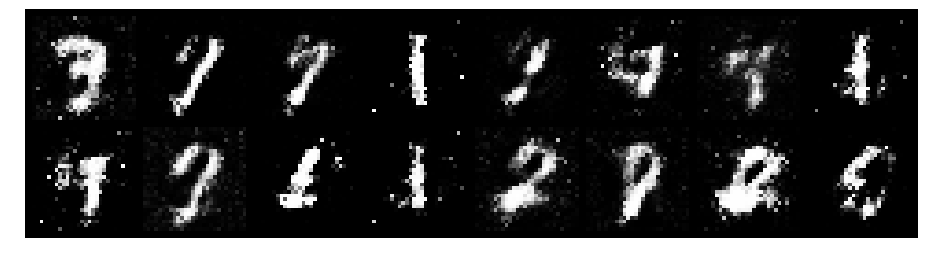

Epoch: [17/200], Batch Num: [100/600]
Discriminator Loss: 0.8229, Generator Loss: 2.0347
D(x): 0.8150, D(G(z)): 0.3291


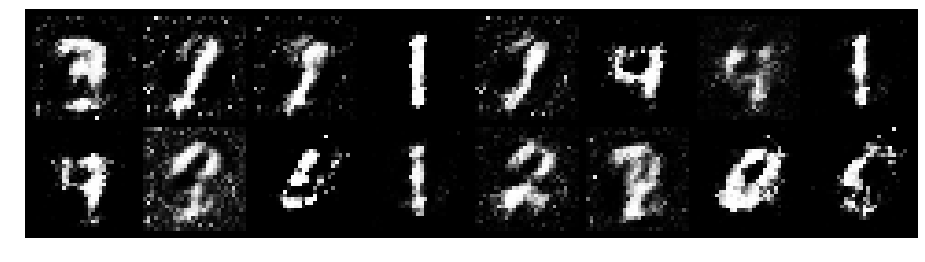

Epoch: [17/200], Batch Num: [200/600]
Discriminator Loss: 0.7435, Generator Loss: 1.7542
D(x): 0.7457, D(G(z)): 0.2489


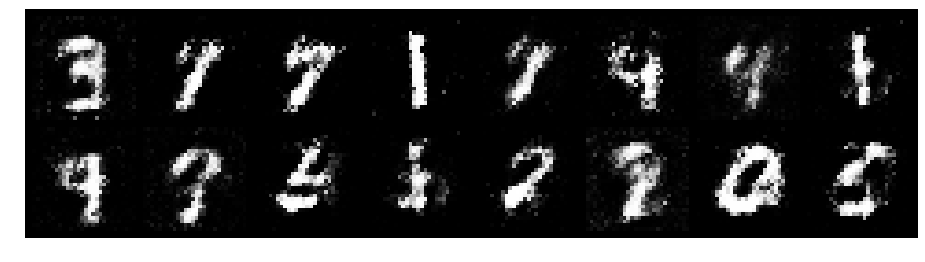

Epoch: [17/200], Batch Num: [300/600]
Discriminator Loss: 0.7693, Generator Loss: 1.9665
D(x): 0.6995, D(G(z)): 0.1868


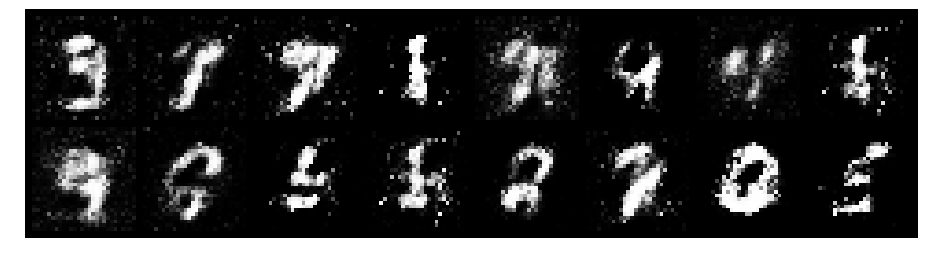

Epoch: [17/200], Batch Num: [400/600]
Discriminator Loss: 0.6808, Generator Loss: 2.4250
D(x): 0.7807, D(G(z)): 0.2354


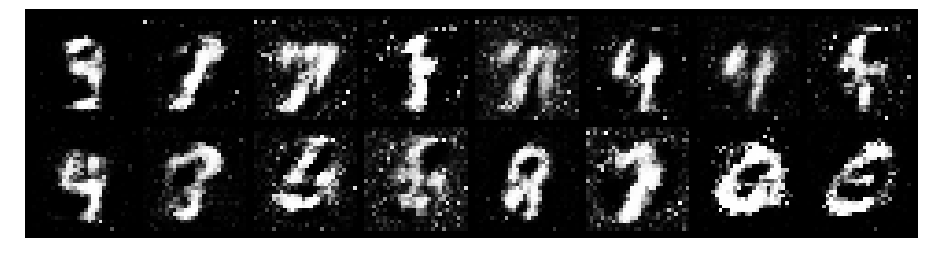

Epoch: [17/200], Batch Num: [500/600]
Discriminator Loss: 0.6776, Generator Loss: 1.7938
D(x): 0.8117, D(G(z)): 0.2477


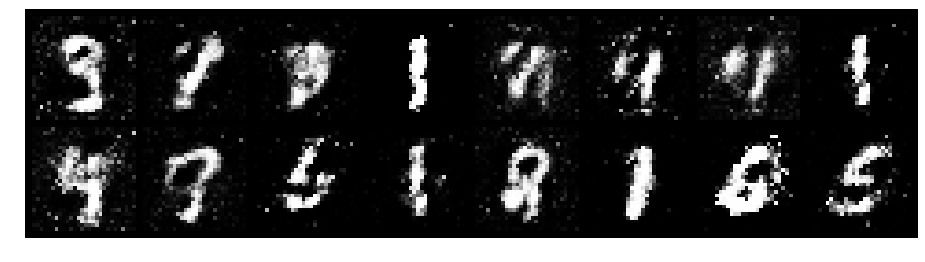

Epoch: [18/200], Batch Num: [0/600]
Discriminator Loss: 0.8013, Generator Loss: 1.9940
D(x): 0.7267, D(G(z)): 0.2398


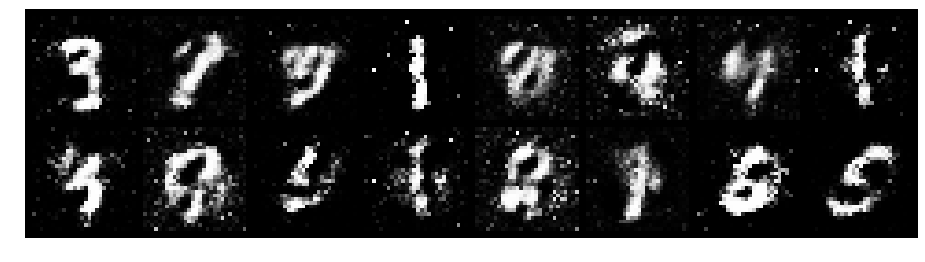

Epoch: [18/200], Batch Num: [100/600]
Discriminator Loss: 1.0009, Generator Loss: 1.5894
D(x): 0.6461, D(G(z)): 0.2613


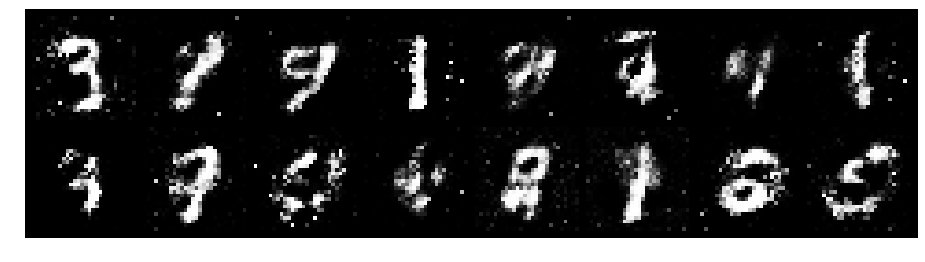

Epoch: [18/200], Batch Num: [200/600]
Discriminator Loss: 0.9585, Generator Loss: 1.8408
D(x): 0.7058, D(G(z)): 0.3249


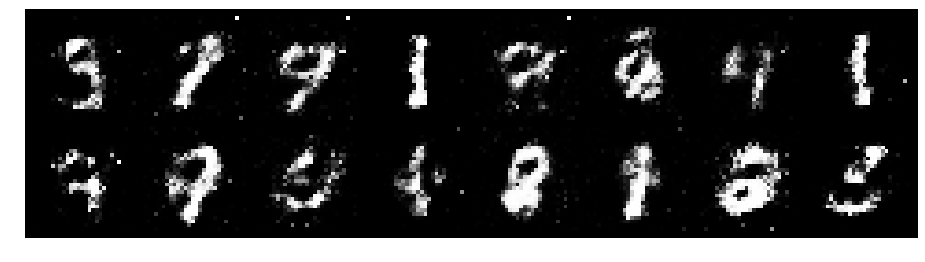

Epoch: [18/200], Batch Num: [300/600]
Discriminator Loss: 0.8816, Generator Loss: 1.5069
D(x): 0.6577, D(G(z)): 0.2313


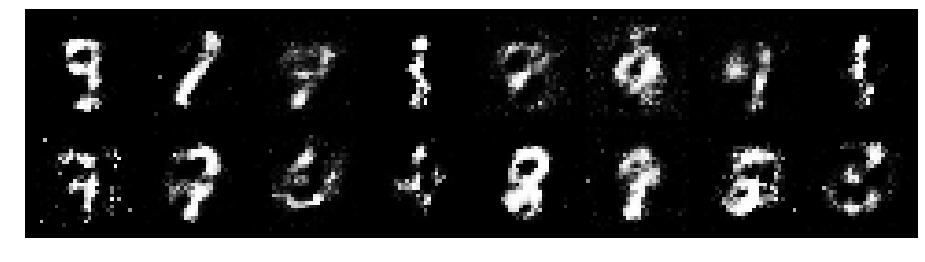

Epoch: [18/200], Batch Num: [400/600]
Discriminator Loss: 0.7904, Generator Loss: 1.8996
D(x): 0.7462, D(G(z)): 0.2813


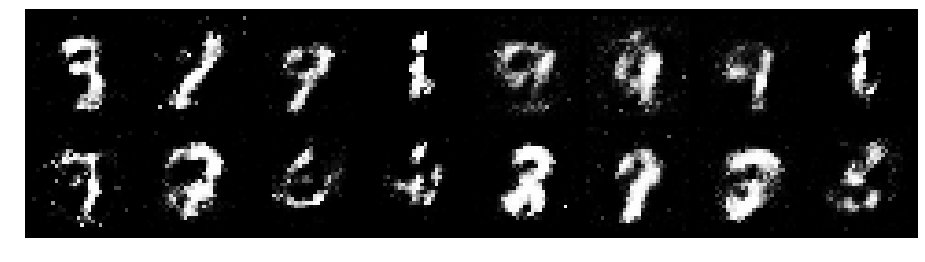

Epoch: [18/200], Batch Num: [500/600]
Discriminator Loss: 0.8540, Generator Loss: 1.6276
D(x): 0.7395, D(G(z)): 0.2938


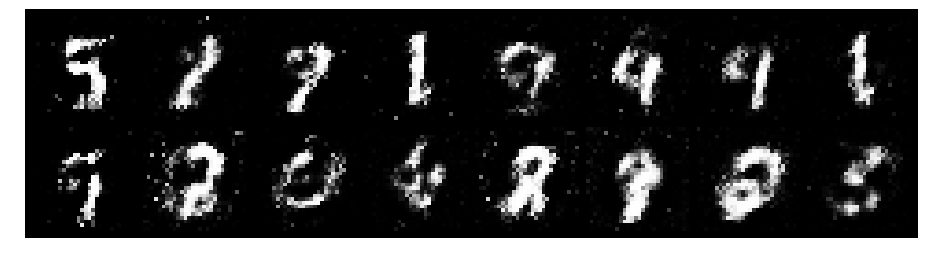

Epoch: [19/200], Batch Num: [0/600]
Discriminator Loss: 0.9036, Generator Loss: 1.5930
D(x): 0.7185, D(G(z)): 0.2873


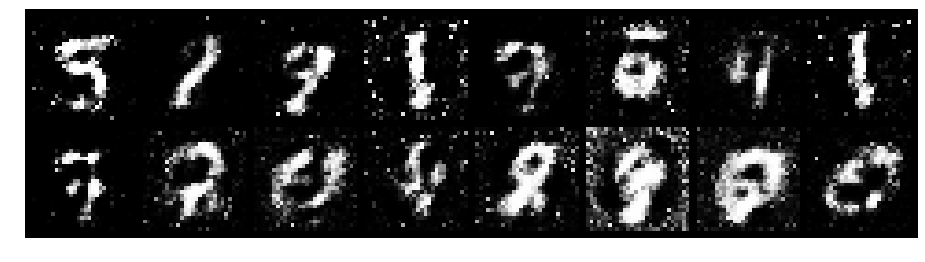

Epoch: [19/200], Batch Num: [100/600]
Discriminator Loss: 0.8528, Generator Loss: 1.9799
D(x): 0.7052, D(G(z)): 0.2621


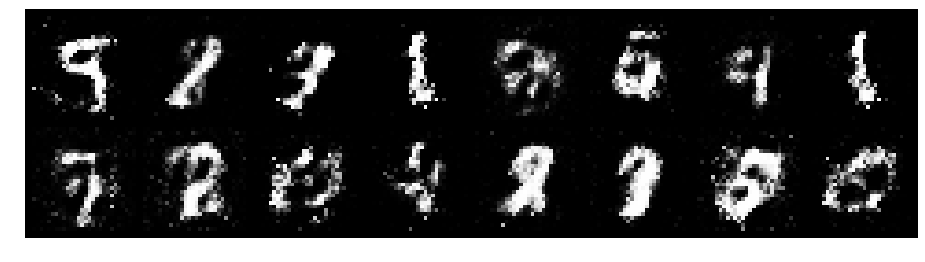

Epoch: [19/200], Batch Num: [200/600]
Discriminator Loss: 0.6667, Generator Loss: 2.2132
D(x): 0.7444, D(G(z)): 0.1990


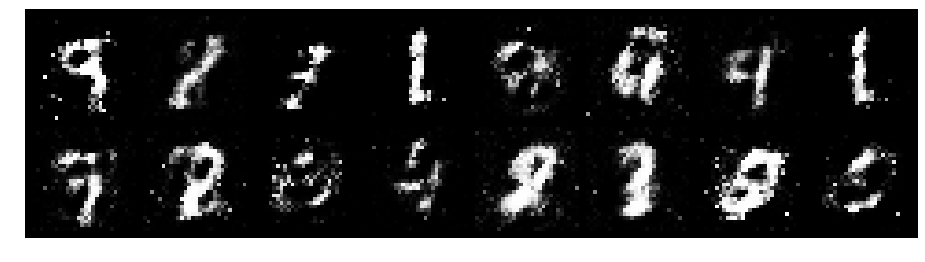

Epoch: [19/200], Batch Num: [300/600]
Discriminator Loss: 0.8028, Generator Loss: 1.5177
D(x): 0.7791, D(G(z)): 0.3395


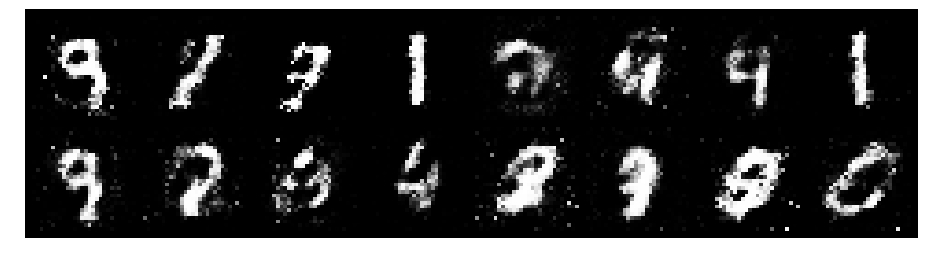

Epoch: [19/200], Batch Num: [400/600]
Discriminator Loss: 0.8481, Generator Loss: 1.9635
D(x): 0.7184, D(G(z)): 0.2656


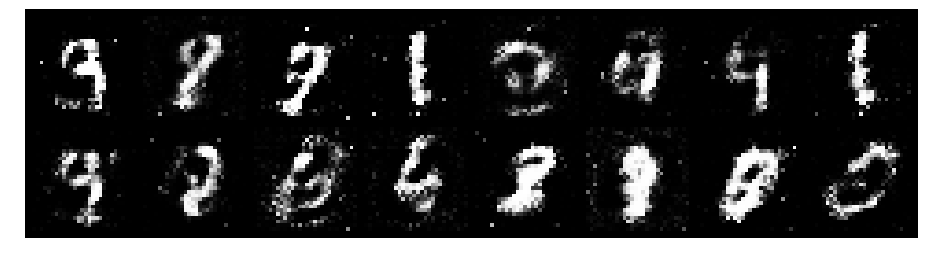

Epoch: [19/200], Batch Num: [500/600]
Discriminator Loss: 0.9951, Generator Loss: 2.0988
D(x): 0.6769, D(G(z)): 0.2243


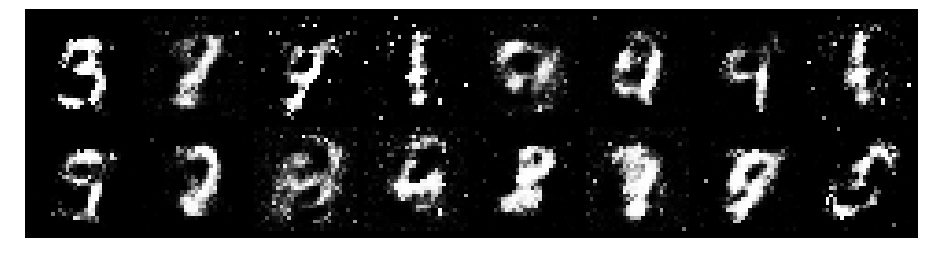

Epoch: [20/200], Batch Num: [0/600]
Discriminator Loss: 0.9913, Generator Loss: 1.3370
D(x): 0.7118, D(G(z)): 0.3439


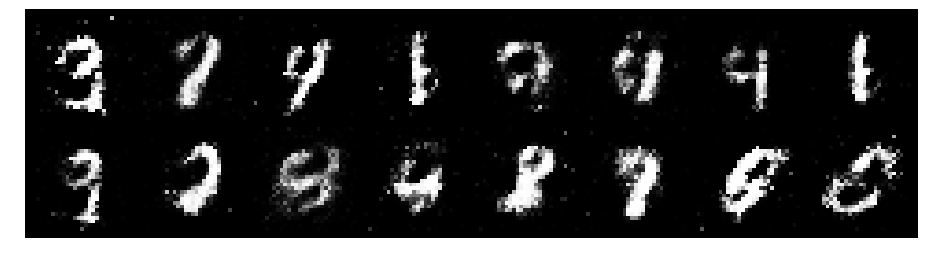

Epoch: [20/200], Batch Num: [100/600]
Discriminator Loss: 0.8663, Generator Loss: 1.4447
D(x): 0.7164, D(G(z)): 0.2910


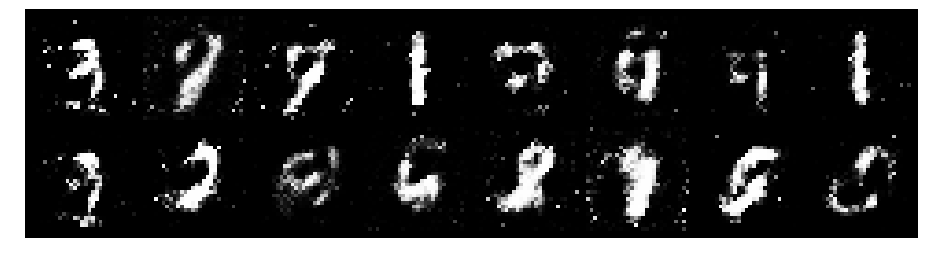

Epoch: [20/200], Batch Num: [200/600]
Discriminator Loss: 0.7519, Generator Loss: 1.6778
D(x): 0.7365, D(G(z)): 0.2330


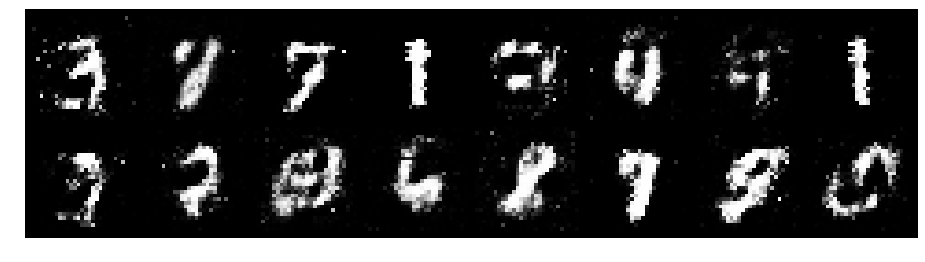

Epoch: [20/200], Batch Num: [300/600]
Discriminator Loss: 0.7616, Generator Loss: 2.0369
D(x): 0.7099, D(G(z)): 0.2315


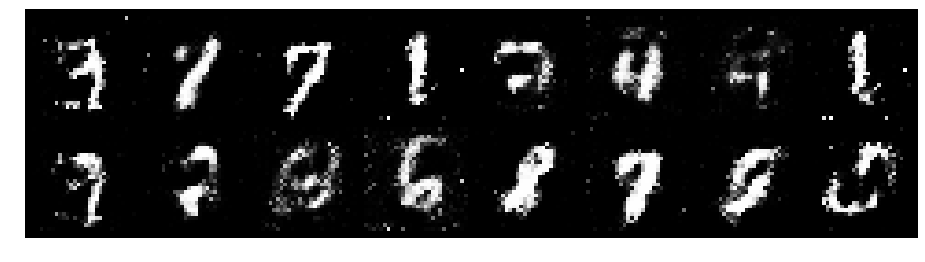

Epoch: [20/200], Batch Num: [400/600]
Discriminator Loss: 0.7761, Generator Loss: 2.0268
D(x): 0.7296, D(G(z)): 0.2391


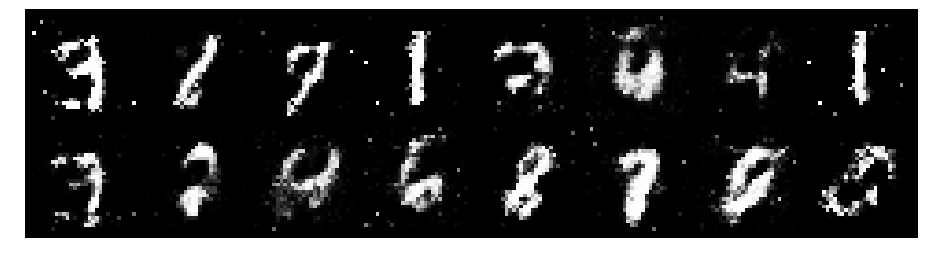

Epoch: [20/200], Batch Num: [500/600]
Discriminator Loss: 0.9281, Generator Loss: 1.7143
D(x): 0.7341, D(G(z)): 0.2868


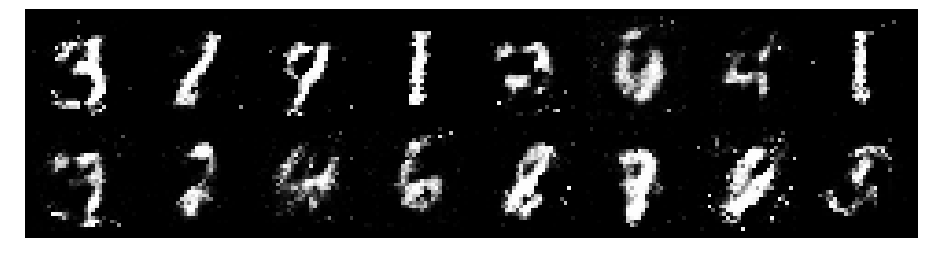

Epoch: [21/200], Batch Num: [0/600]
Discriminator Loss: 0.8657, Generator Loss: 1.7259
D(x): 0.7699, D(G(z)): 0.3410


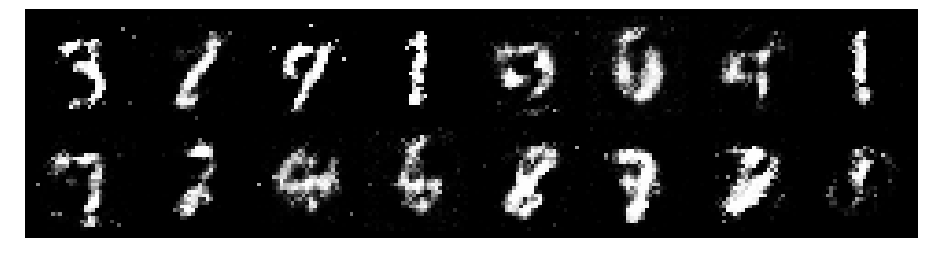

Epoch: [21/200], Batch Num: [100/600]
Discriminator Loss: 0.8267, Generator Loss: 1.6901
D(x): 0.6999, D(G(z)): 0.2328


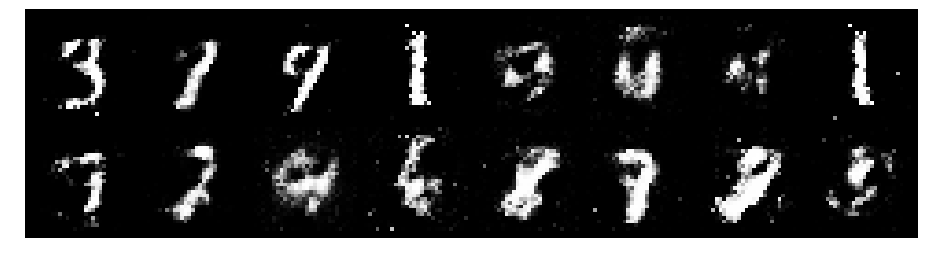

Epoch: [21/200], Batch Num: [200/600]
Discriminator Loss: 0.9800, Generator Loss: 1.3219
D(x): 0.7066, D(G(z)): 0.3204


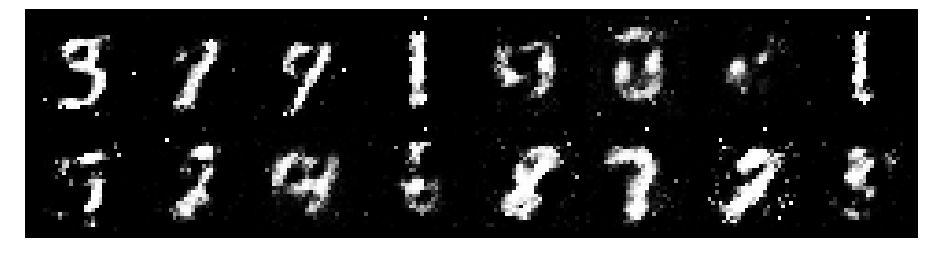

Epoch: [21/200], Batch Num: [300/600]
Discriminator Loss: 0.9930, Generator Loss: 1.1127
D(x): 0.7529, D(G(z)): 0.3904


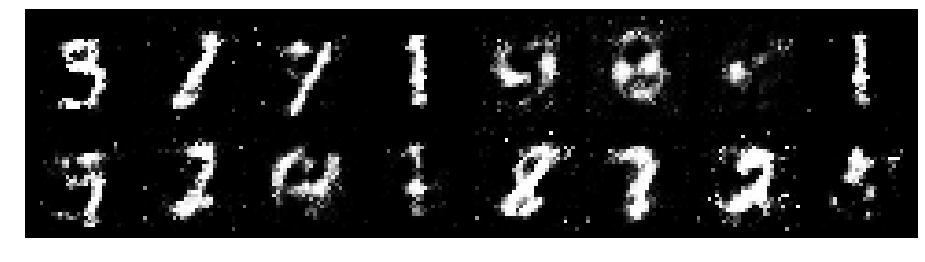

Epoch: [21/200], Batch Num: [400/600]
Discriminator Loss: 0.8488, Generator Loss: 1.1177
D(x): 0.7933, D(G(z)): 0.3687


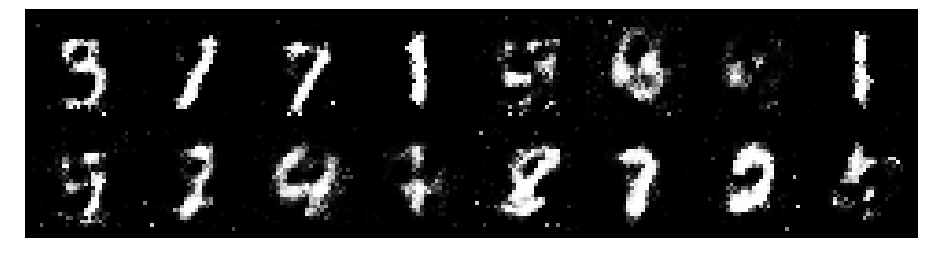

Epoch: [21/200], Batch Num: [500/600]
Discriminator Loss: 0.9913, Generator Loss: 1.3100
D(x): 0.6609, D(G(z)): 0.3175


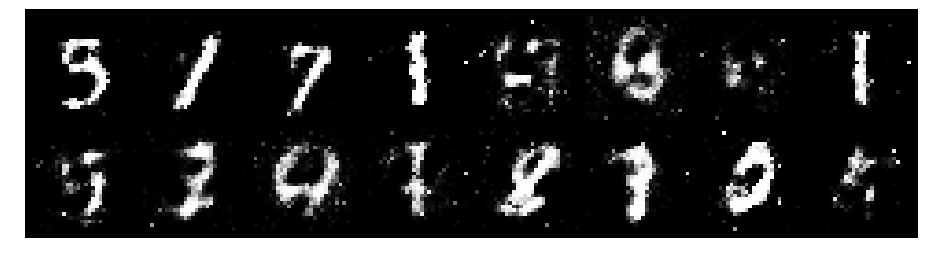

Epoch: [22/200], Batch Num: [0/600]
Discriminator Loss: 1.0636, Generator Loss: 1.1424
D(x): 0.6375, D(G(z)): 0.3510


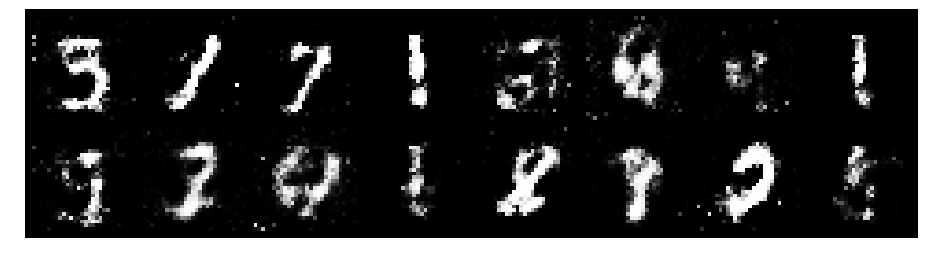

Epoch: [22/200], Batch Num: [100/600]
Discriminator Loss: 0.8107, Generator Loss: 1.5632
D(x): 0.6982, D(G(z)): 0.2521


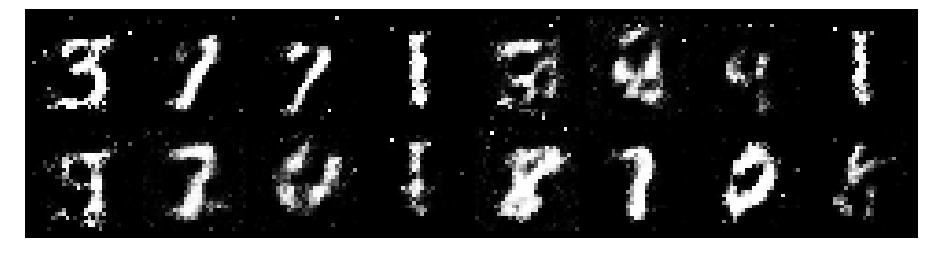

Epoch: [22/200], Batch Num: [200/600]
Discriminator Loss: 0.9314, Generator Loss: 1.5336
D(x): 0.6766, D(G(z)): 0.3222


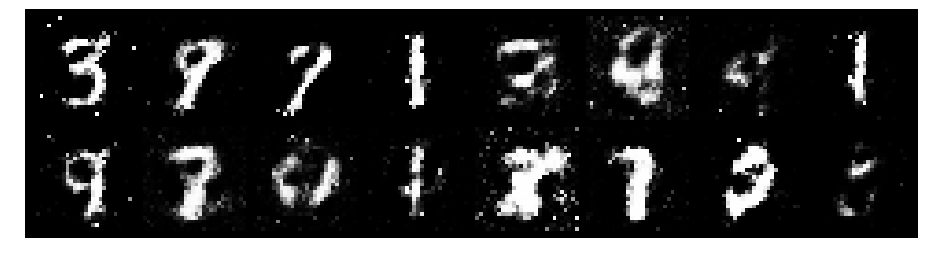

Epoch: [22/200], Batch Num: [300/600]
Discriminator Loss: 0.7995, Generator Loss: 1.3040
D(x): 0.7564, D(G(z)): 0.3088


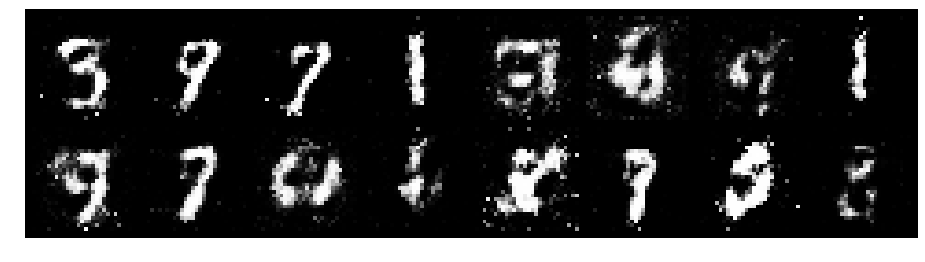

Epoch: [22/200], Batch Num: [400/600]
Discriminator Loss: 0.8269, Generator Loss: 1.5469
D(x): 0.7034, D(G(z)): 0.2925


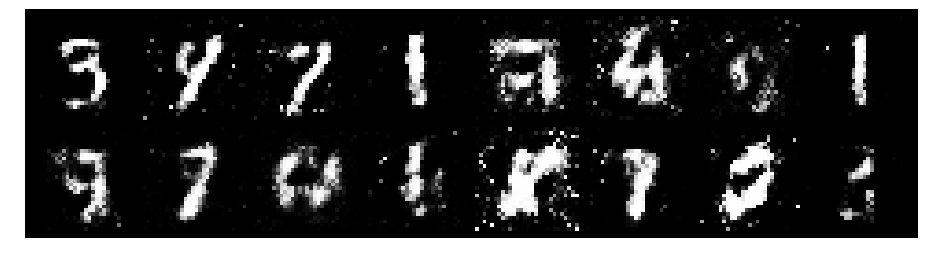

Epoch: [22/200], Batch Num: [500/600]
Discriminator Loss: 0.8462, Generator Loss: 2.0289
D(x): 0.6669, D(G(z)): 0.2123


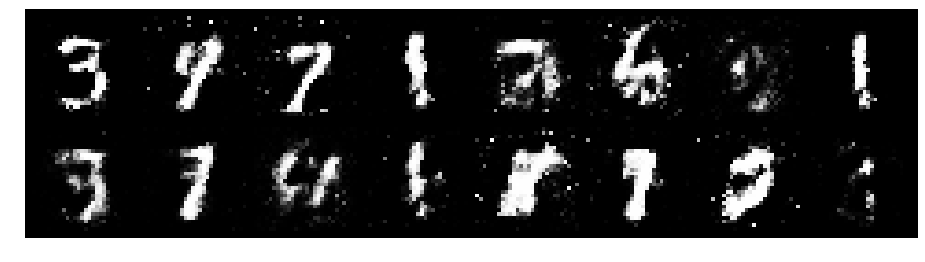

Epoch: [23/200], Batch Num: [0/600]
Discriminator Loss: 1.1157, Generator Loss: 1.4303
D(x): 0.6556, D(G(z)): 0.3334


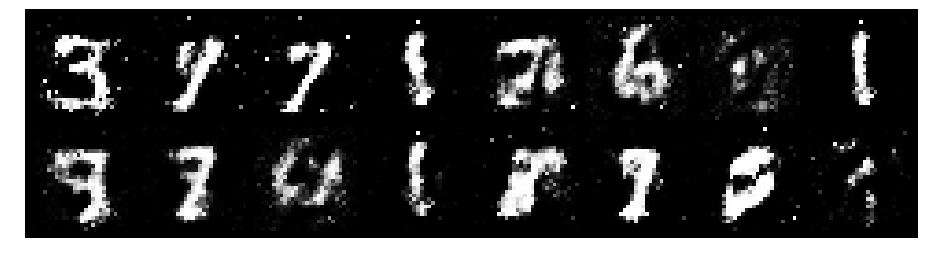

Epoch: [23/200], Batch Num: [100/600]
Discriminator Loss: 1.0861, Generator Loss: 1.5308
D(x): 0.8288, D(G(z)): 0.4615


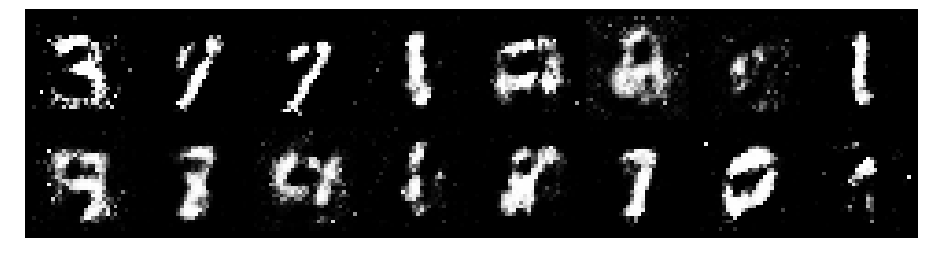

Epoch: [23/200], Batch Num: [200/600]
Discriminator Loss: 1.1571, Generator Loss: 1.1769
D(x): 0.7218, D(G(z)): 0.4181


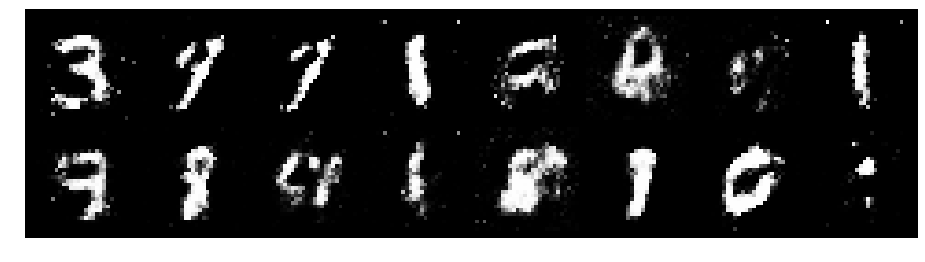

Epoch: [23/200], Batch Num: [300/600]
Discriminator Loss: 1.0489, Generator Loss: 1.6069
D(x): 0.6527, D(G(z)): 0.3289


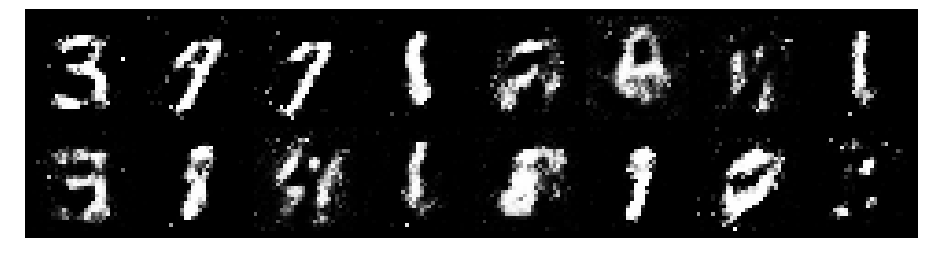

Epoch: [23/200], Batch Num: [400/600]
Discriminator Loss: 0.8362, Generator Loss: 1.5369
D(x): 0.7656, D(G(z)): 0.3401


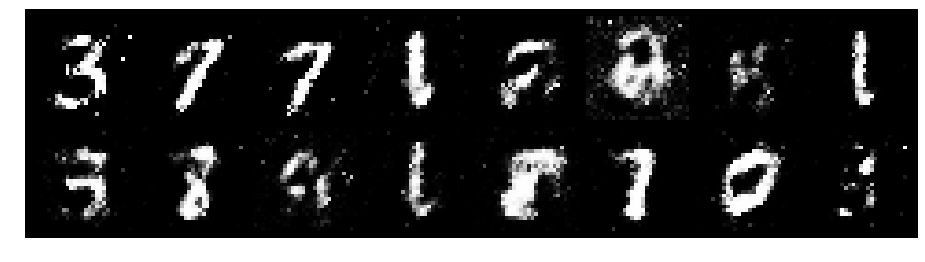

Epoch: [23/200], Batch Num: [500/600]
Discriminator Loss: 0.8016, Generator Loss: 2.1051
D(x): 0.6844, D(G(z)): 0.2094


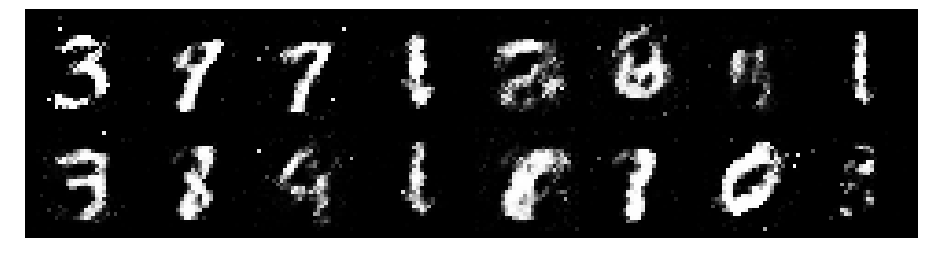

Epoch: [24/200], Batch Num: [0/600]
Discriminator Loss: 0.7798, Generator Loss: 2.1774
D(x): 0.6922, D(G(z)): 0.1897


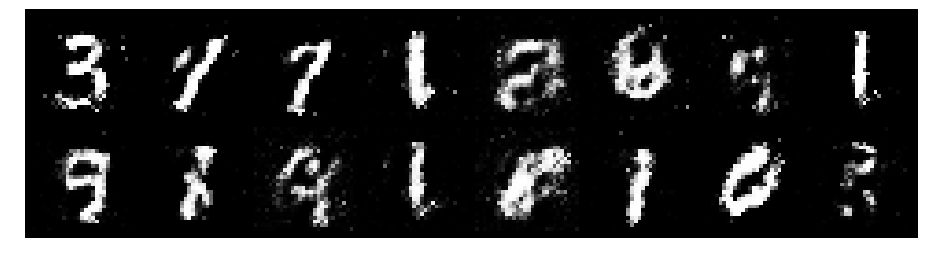

Epoch: [24/200], Batch Num: [100/600]
Discriminator Loss: 0.9363, Generator Loss: 1.4390
D(x): 0.6572, D(G(z)): 0.2795


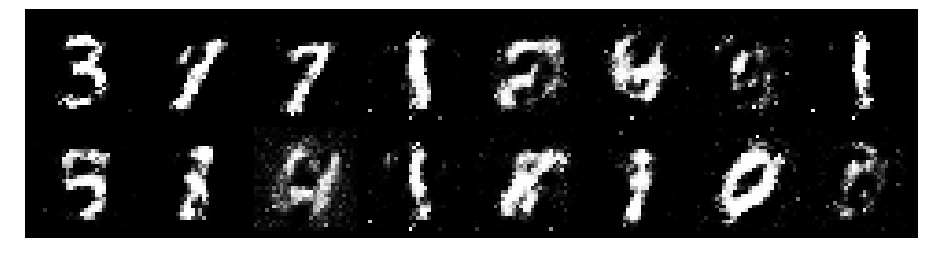

Epoch: [24/200], Batch Num: [200/600]
Discriminator Loss: 1.2413, Generator Loss: 1.1650
D(x): 0.6839, D(G(z)): 0.4445


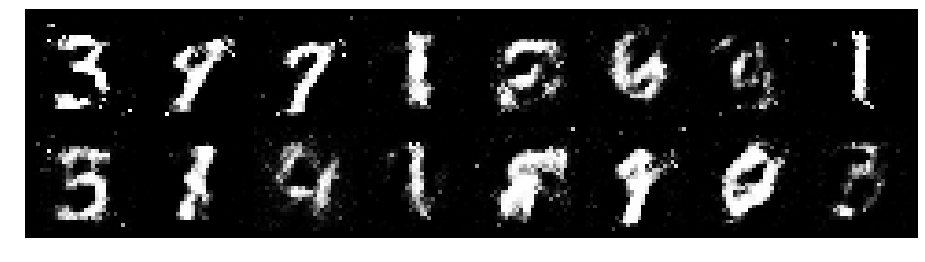

Epoch: [24/200], Batch Num: [300/600]
Discriminator Loss: 0.8180, Generator Loss: 1.7262
D(x): 0.7509, D(G(z)): 0.3194


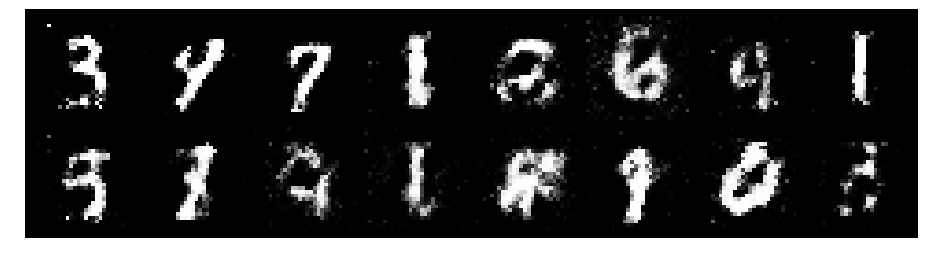

Epoch: [24/200], Batch Num: [400/600]
Discriminator Loss: 1.0531, Generator Loss: 1.6136
D(x): 0.6628, D(G(z)): 0.3123


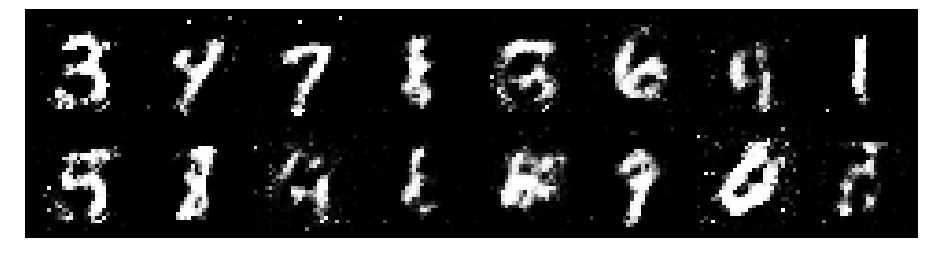

Epoch: [24/200], Batch Num: [500/600]
Discriminator Loss: 1.0784, Generator Loss: 1.4460
D(x): 0.7020, D(G(z)): 0.3797


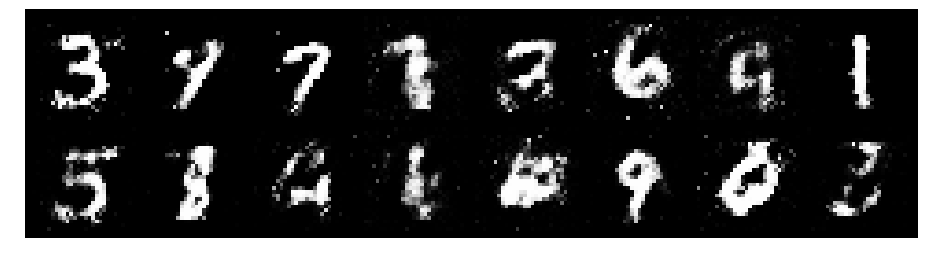

Epoch: [25/200], Batch Num: [0/600]
Discriminator Loss: 0.9374, Generator Loss: 1.4715
D(x): 0.7704, D(G(z)): 0.3795


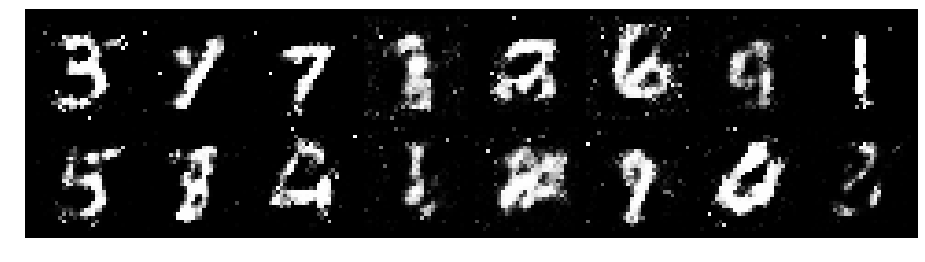

Epoch: [25/200], Batch Num: [100/600]
Discriminator Loss: 1.0438, Generator Loss: 1.2998
D(x): 0.7406, D(G(z)): 0.3804


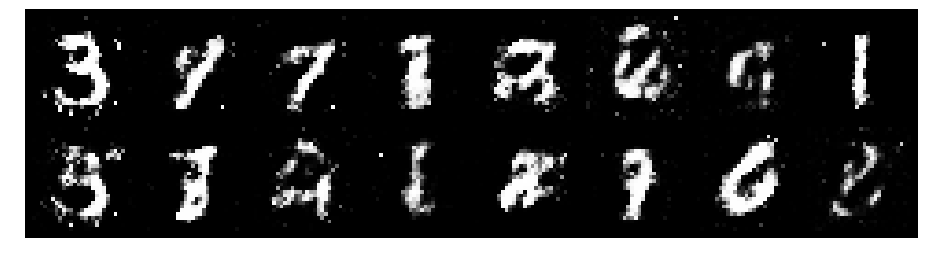

Epoch: [25/200], Batch Num: [200/600]
Discriminator Loss: 1.0959, Generator Loss: 1.0740
D(x): 0.6305, D(G(z)): 0.3592


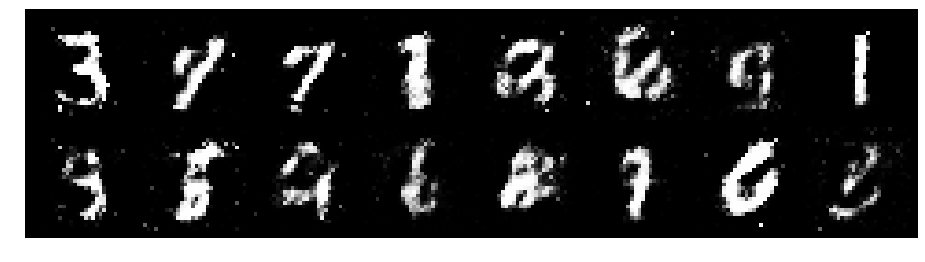

Epoch: [25/200], Batch Num: [300/600]
Discriminator Loss: 1.0842, Generator Loss: 1.1011
D(x): 0.6610, D(G(z)): 0.3613


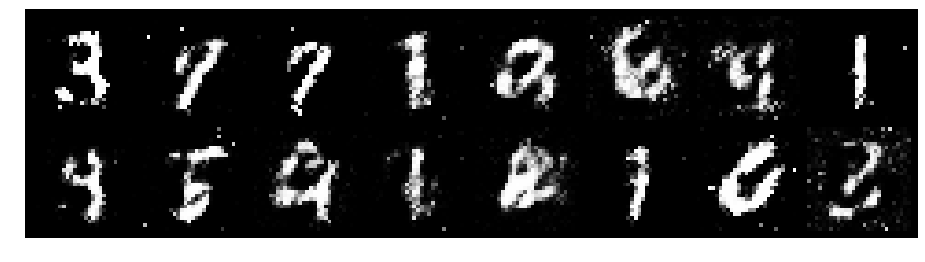

Epoch: [25/200], Batch Num: [400/600]
Discriminator Loss: 1.0816, Generator Loss: 1.3701
D(x): 0.6380, D(G(z)): 0.3609


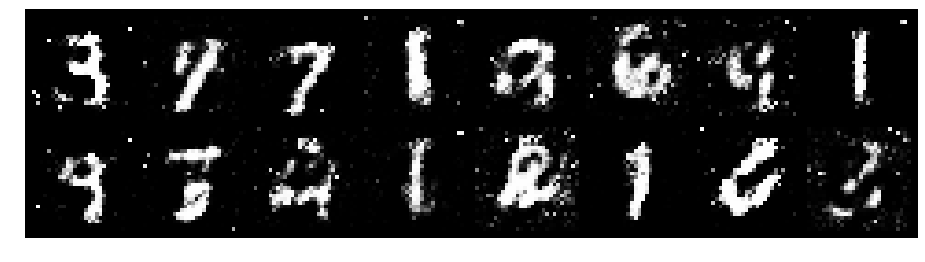

Epoch: [25/200], Batch Num: [500/600]
Discriminator Loss: 0.9206, Generator Loss: 1.4049
D(x): 0.6278, D(G(z)): 0.2848


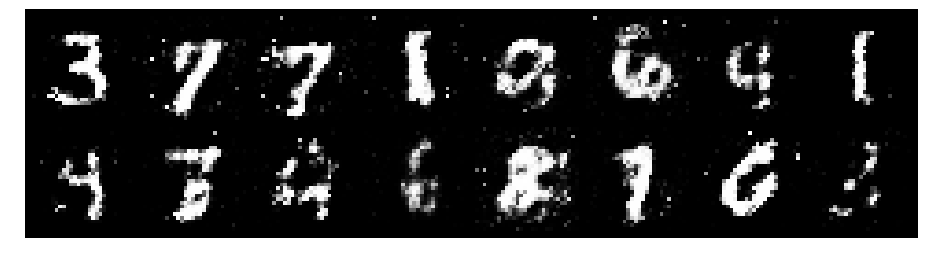

Epoch: [26/200], Batch Num: [0/600]
Discriminator Loss: 0.9750, Generator Loss: 1.9108
D(x): 0.6461, D(G(z)): 0.2807


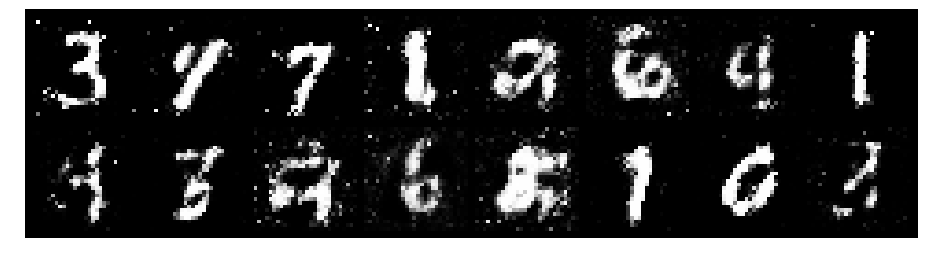

Epoch: [26/200], Batch Num: [100/600]
Discriminator Loss: 0.9679, Generator Loss: 1.3423
D(x): 0.7072, D(G(z)): 0.3624


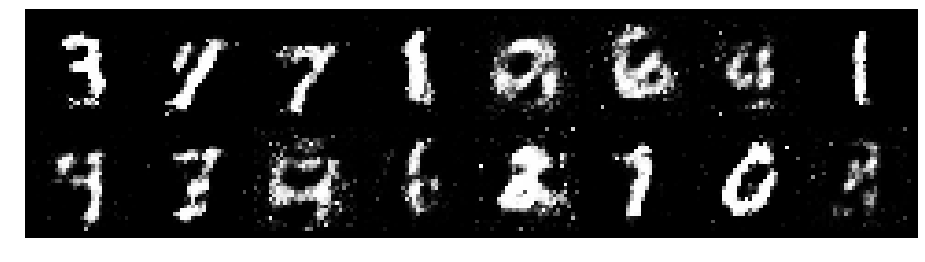

Epoch: [26/200], Batch Num: [200/600]
Discriminator Loss: 0.9986, Generator Loss: 1.4928
D(x): 0.6398, D(G(z)): 0.3235


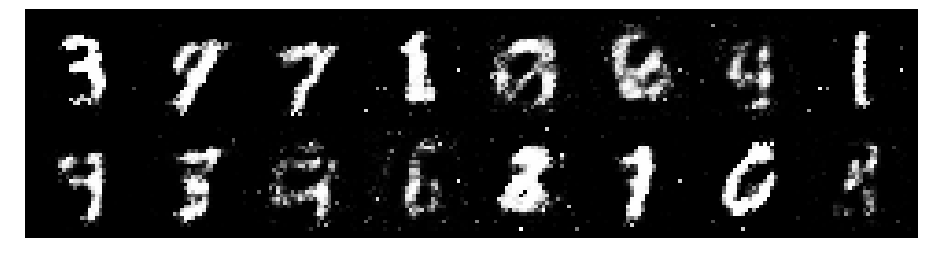

Epoch: [26/200], Batch Num: [300/600]
Discriminator Loss: 0.8699, Generator Loss: 1.3850
D(x): 0.7422, D(G(z)): 0.3354


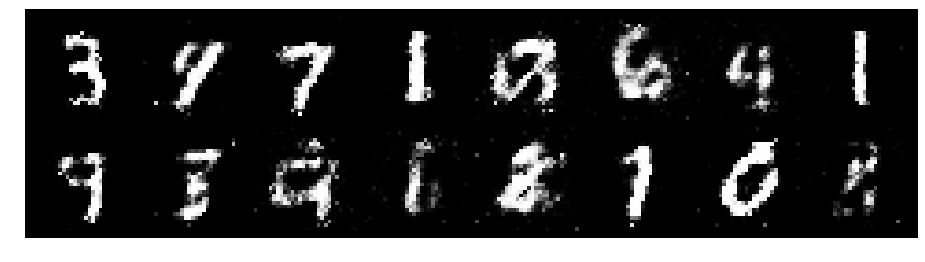

Epoch: [26/200], Batch Num: [400/600]
Discriminator Loss: 1.0078, Generator Loss: 1.2199
D(x): 0.7390, D(G(z)): 0.4000


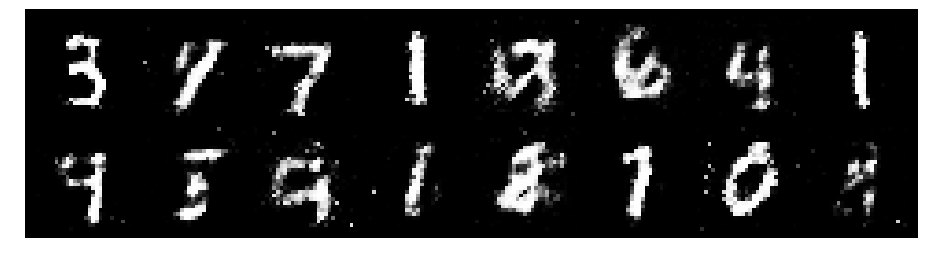

Epoch: [26/200], Batch Num: [500/600]
Discriminator Loss: 1.1684, Generator Loss: 1.4102
D(x): 0.6686, D(G(z)): 0.3456


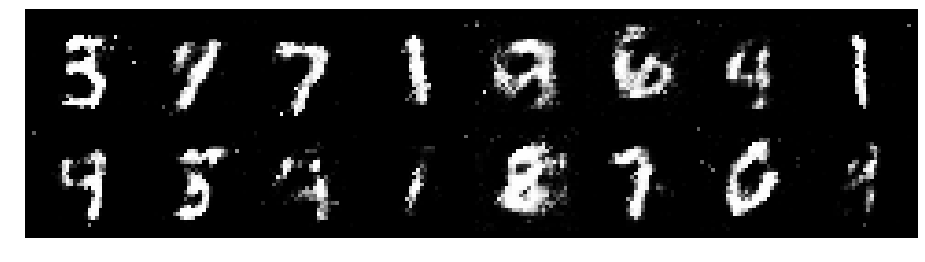

Epoch: [27/200], Batch Num: [0/600]
Discriminator Loss: 1.1047, Generator Loss: 1.2960
D(x): 0.6215, D(G(z)): 0.3366


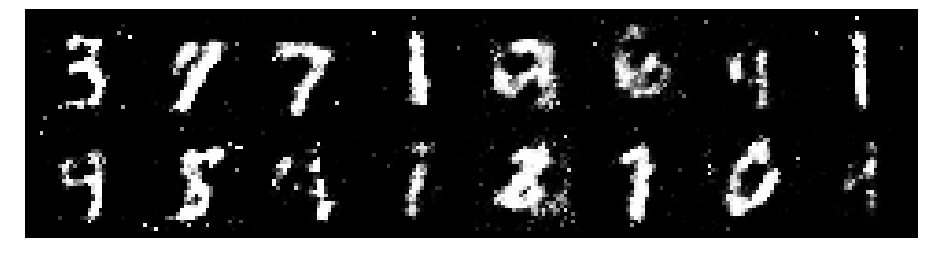

Epoch: [27/200], Batch Num: [100/600]
Discriminator Loss: 0.9229, Generator Loss: 1.7405
D(x): 0.6543, D(G(z)): 0.2720


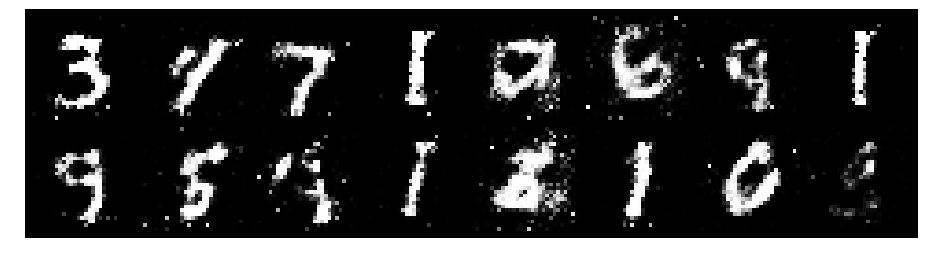

Epoch: [27/200], Batch Num: [200/600]
Discriminator Loss: 1.0013, Generator Loss: 1.2191
D(x): 0.6835, D(G(z)): 0.3605


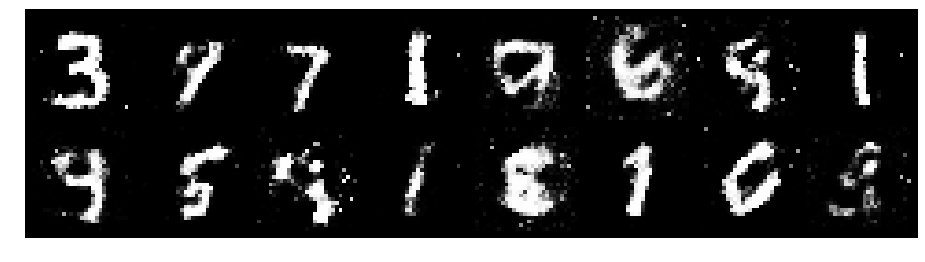

Epoch: [27/200], Batch Num: [300/600]
Discriminator Loss: 0.9370, Generator Loss: 1.7309
D(x): 0.6474, D(G(z)): 0.2495


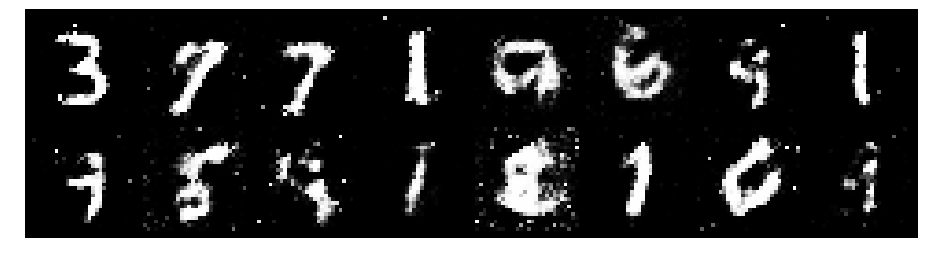

Epoch: [27/200], Batch Num: [400/600]
Discriminator Loss: 0.9284, Generator Loss: 1.5782
D(x): 0.7415, D(G(z)): 0.3673


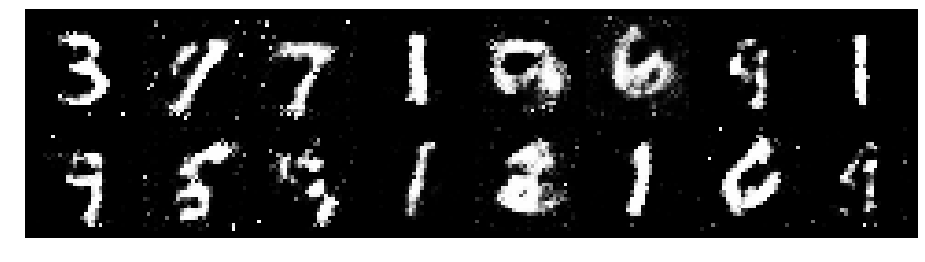

Epoch: [27/200], Batch Num: [500/600]
Discriminator Loss: 0.9105, Generator Loss: 1.3393
D(x): 0.6941, D(G(z)): 0.3110


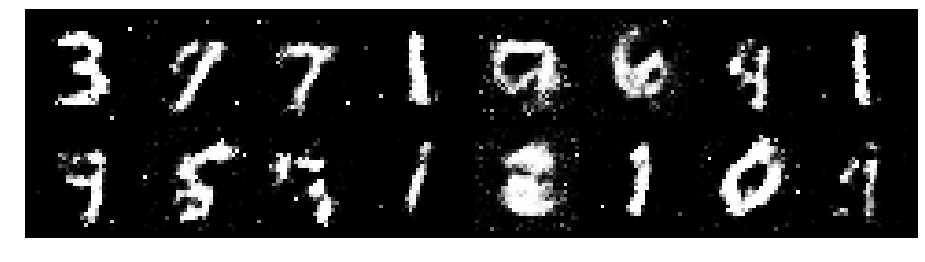

Epoch: [28/200], Batch Num: [0/600]
Discriminator Loss: 0.9588, Generator Loss: 1.3779
D(x): 0.6261, D(G(z)): 0.2567


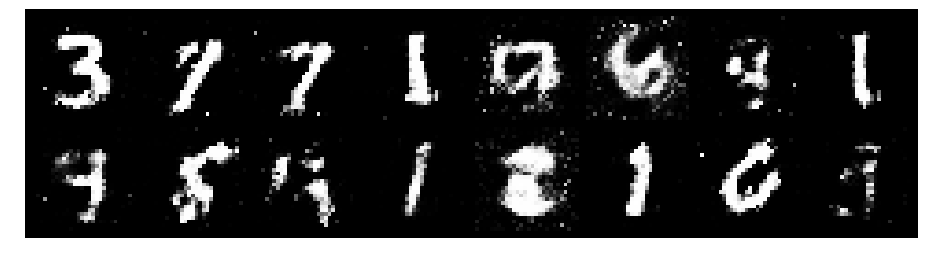

Epoch: [28/200], Batch Num: [100/600]
Discriminator Loss: 1.1596, Generator Loss: 1.7042
D(x): 0.6024, D(G(z)): 0.2931


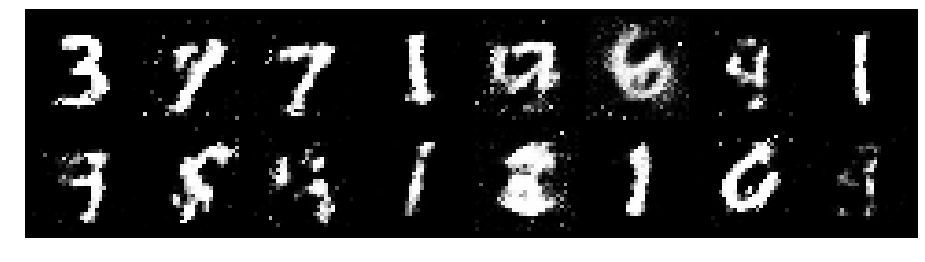

Epoch: [28/200], Batch Num: [200/600]
Discriminator Loss: 0.9235, Generator Loss: 1.5814
D(x): 0.7111, D(G(z)): 0.3058


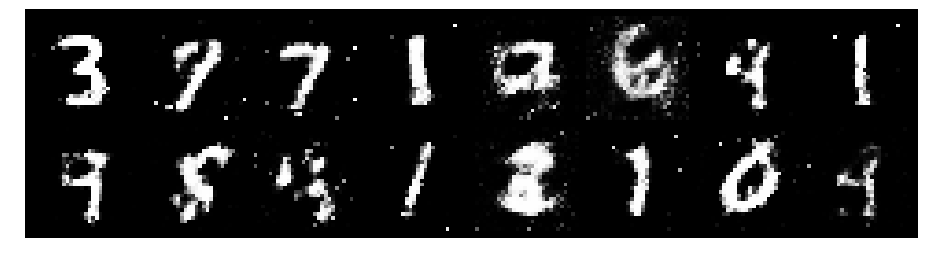

Epoch: [28/200], Batch Num: [300/600]
Discriminator Loss: 1.0142, Generator Loss: 1.3761
D(x): 0.6776, D(G(z)): 0.3496


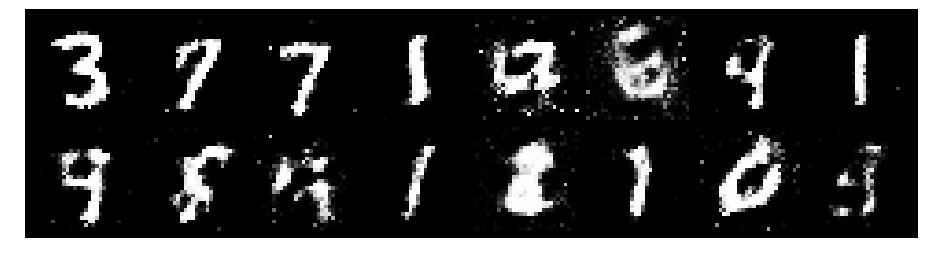

Epoch: [28/200], Batch Num: [400/600]
Discriminator Loss: 1.0598, Generator Loss: 1.0857
D(x): 0.6495, D(G(z)): 0.3372


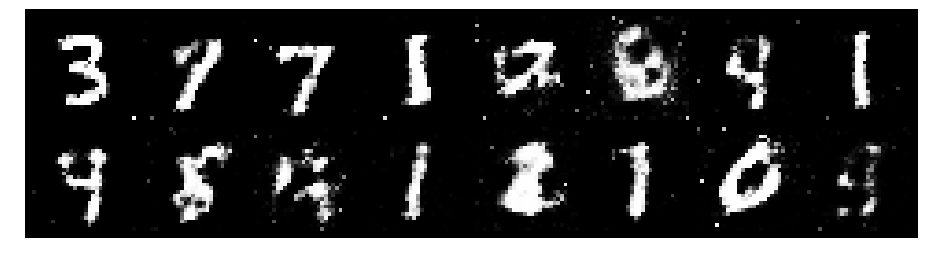

Epoch: [28/200], Batch Num: [500/600]
Discriminator Loss: 0.9066, Generator Loss: 1.5401
D(x): 0.7019, D(G(z)): 0.3065


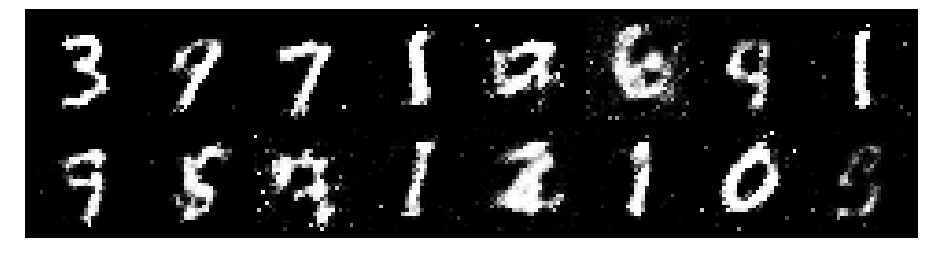

Epoch: [29/200], Batch Num: [0/600]
Discriminator Loss: 0.8941, Generator Loss: 1.4229
D(x): 0.6581, D(G(z)): 0.2656


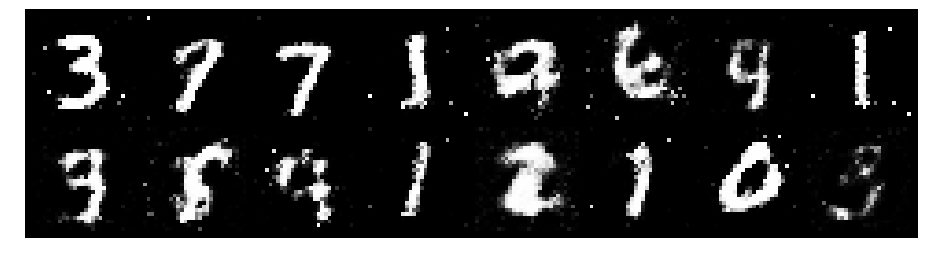

Epoch: [29/200], Batch Num: [100/600]
Discriminator Loss: 1.1535, Generator Loss: 1.4587
D(x): 0.6633, D(G(z)): 0.3937


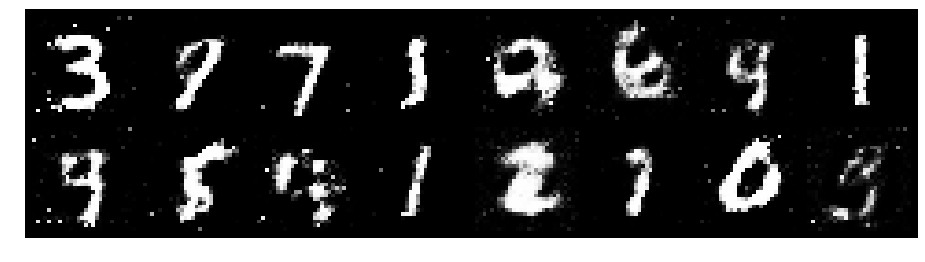

Epoch: [29/200], Batch Num: [200/600]
Discriminator Loss: 1.1225, Generator Loss: 1.4329
D(x): 0.6444, D(G(z)): 0.3774


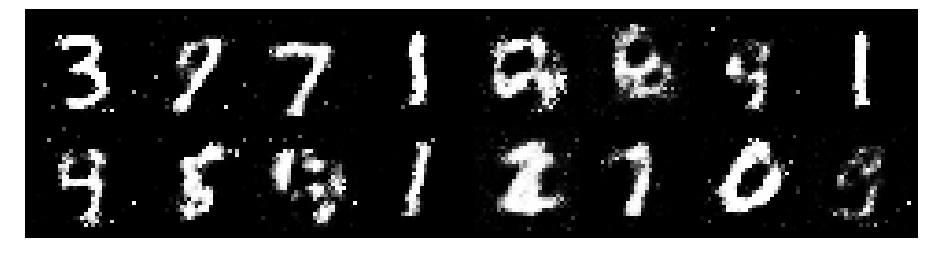

Epoch: [29/200], Batch Num: [300/600]
Discriminator Loss: 1.0252, Generator Loss: 1.2962
D(x): 0.6456, D(G(z)): 0.3609


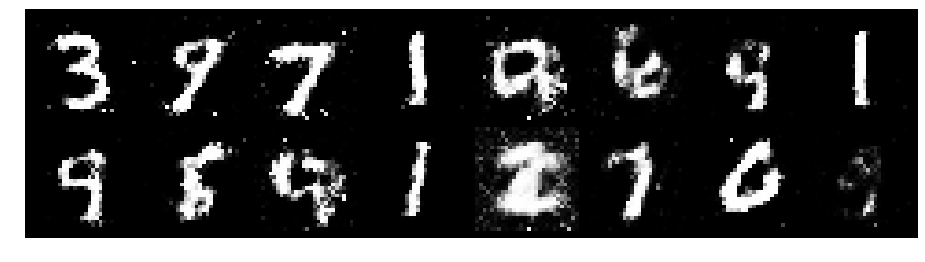

Epoch: [29/200], Batch Num: [400/600]
Discriminator Loss: 0.8989, Generator Loss: 1.2793
D(x): 0.7403, D(G(z)): 0.3576


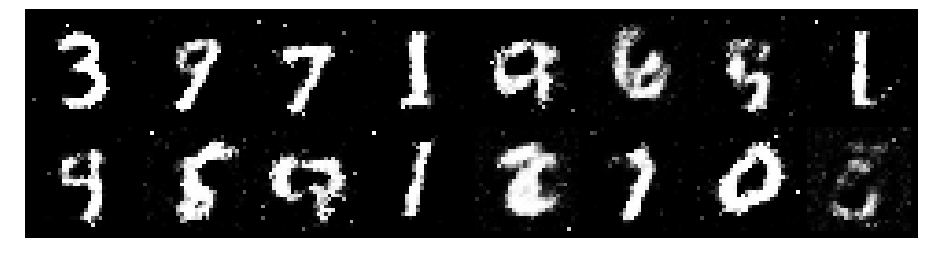

Epoch: [29/200], Batch Num: [500/600]
Discriminator Loss: 1.1368, Generator Loss: 1.6681
D(x): 0.6209, D(G(z)): 0.2627


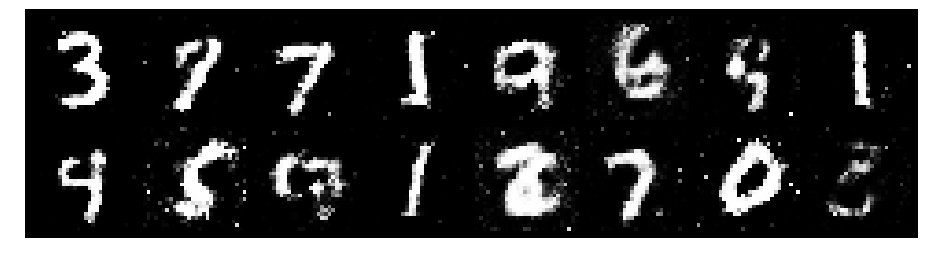

Epoch: [30/200], Batch Num: [0/600]
Discriminator Loss: 1.1338, Generator Loss: 1.0590
D(x): 0.6778, D(G(z)): 0.4403


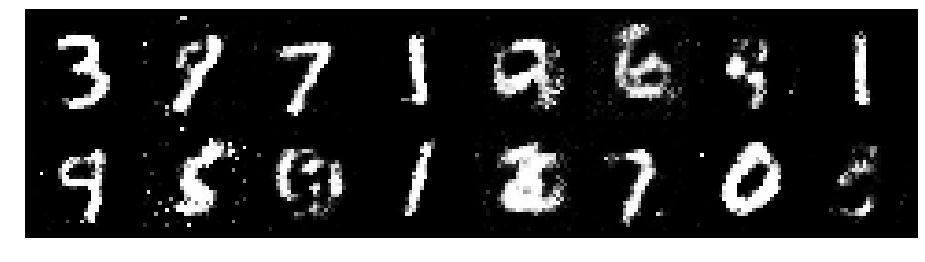

Epoch: [30/200], Batch Num: [100/600]
Discriminator Loss: 1.0627, Generator Loss: 1.3471
D(x): 0.6802, D(G(z)): 0.4030


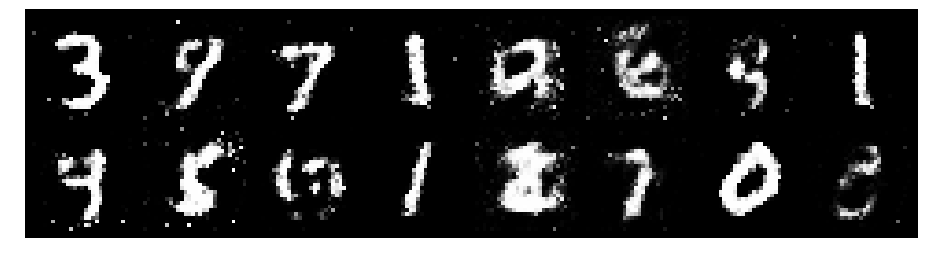

Epoch: [30/200], Batch Num: [200/600]
Discriminator Loss: 1.0044, Generator Loss: 1.3237
D(x): 0.6313, D(G(z)): 0.3435


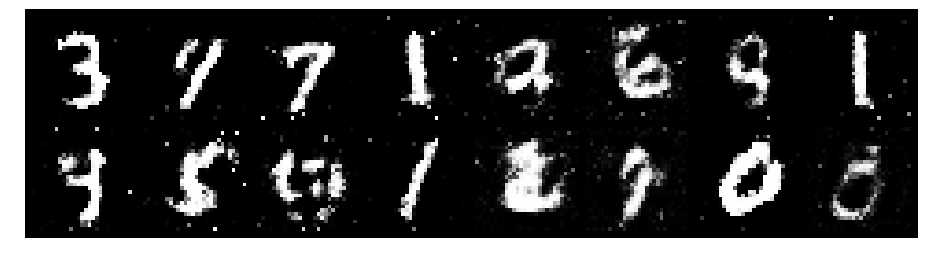

Epoch: [30/200], Batch Num: [300/600]
Discriminator Loss: 1.1183, Generator Loss: 1.2043
D(x): 0.6552, D(G(z)): 0.3990


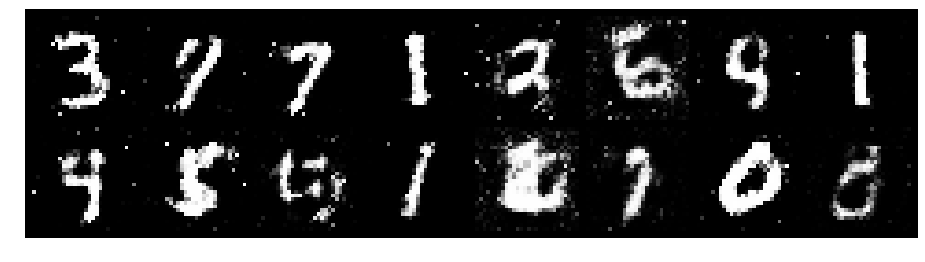

Epoch: [30/200], Batch Num: [400/600]
Discriminator Loss: 0.9768, Generator Loss: 1.2428
D(x): 0.6205, D(G(z)): 0.3080


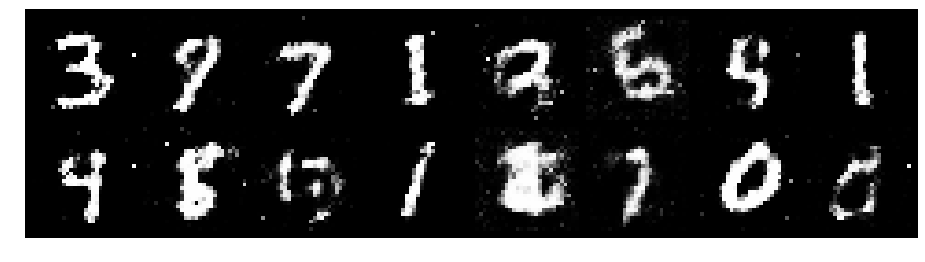

Epoch: [30/200], Batch Num: [500/600]
Discriminator Loss: 0.9283, Generator Loss: 1.1504
D(x): 0.7514, D(G(z)): 0.3651


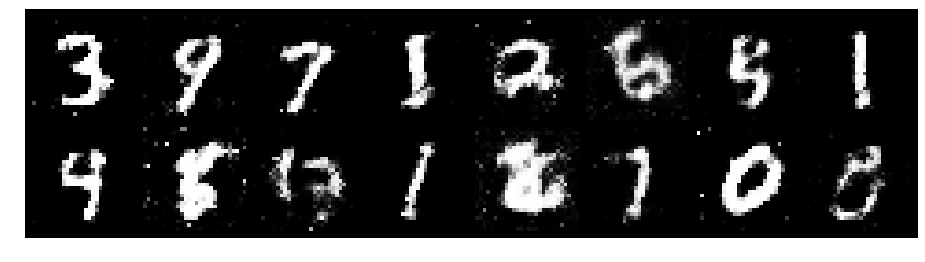

Epoch: [31/200], Batch Num: [0/600]
Discriminator Loss: 1.1874, Generator Loss: 1.1724
D(x): 0.6129, D(G(z)): 0.3783


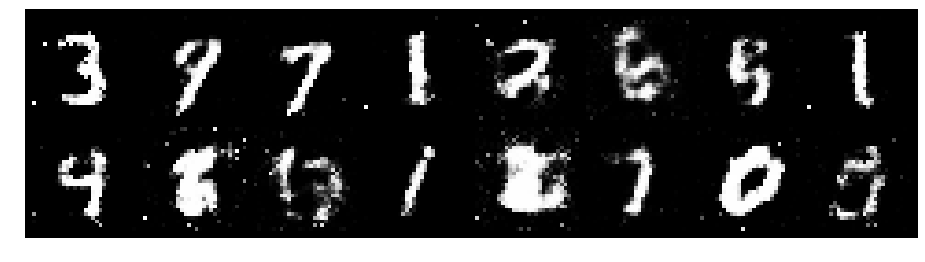

Epoch: [31/200], Batch Num: [100/600]
Discriminator Loss: 1.2002, Generator Loss: 1.1539
D(x): 0.5262, D(G(z)): 0.3165


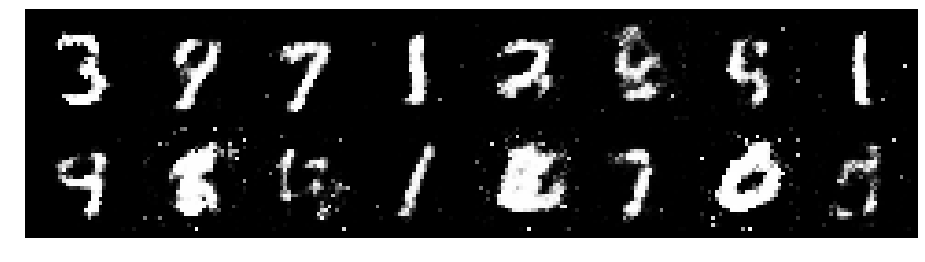

Epoch: [31/200], Batch Num: [200/600]
Discriminator Loss: 0.9436, Generator Loss: 1.2799
D(x): 0.6793, D(G(z)): 0.3434


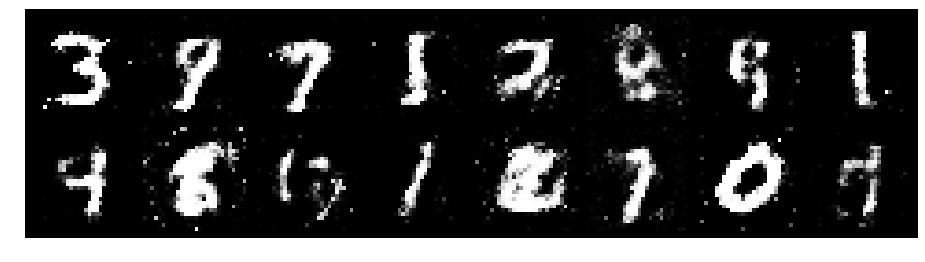

Epoch: [31/200], Batch Num: [300/600]
Discriminator Loss: 0.8742, Generator Loss: 1.3145
D(x): 0.7322, D(G(z)): 0.3573


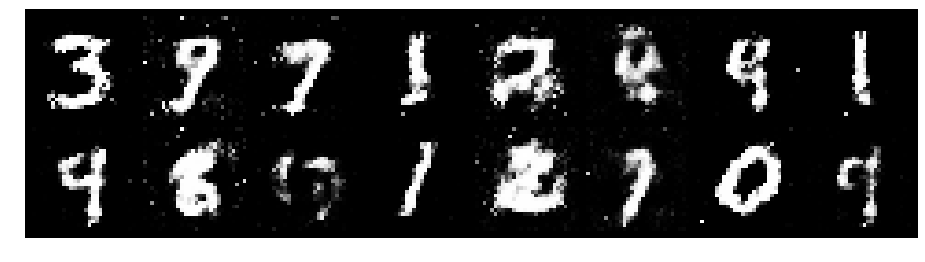

Epoch: [31/200], Batch Num: [400/600]
Discriminator Loss: 1.0205, Generator Loss: 1.3144
D(x): 0.6826, D(G(z)): 0.3385


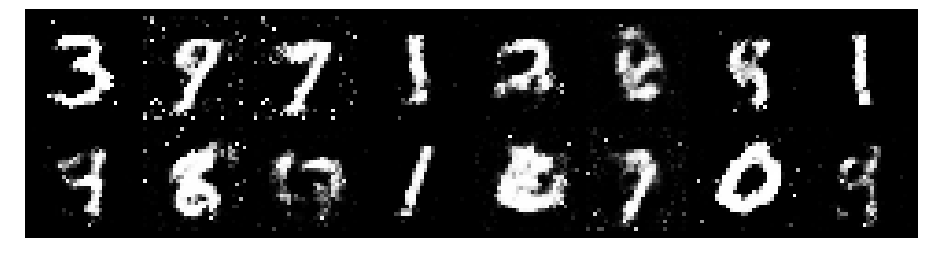

Epoch: [31/200], Batch Num: [500/600]
Discriminator Loss: 0.9394, Generator Loss: 1.3668
D(x): 0.6441, D(G(z)): 0.2906


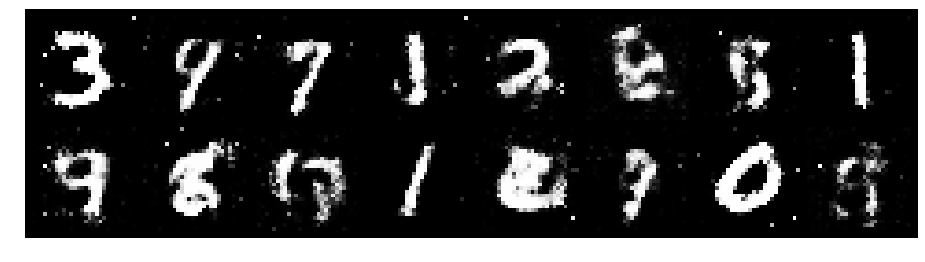

Epoch: [32/200], Batch Num: [0/600]
Discriminator Loss: 0.9942, Generator Loss: 1.1821
D(x): 0.6954, D(G(z)): 0.3572


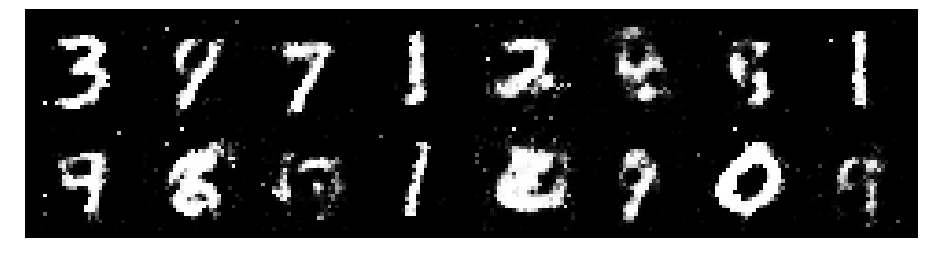

Epoch: [32/200], Batch Num: [100/600]
Discriminator Loss: 1.0317, Generator Loss: 1.3787
D(x): 0.6716, D(G(z)): 0.3656


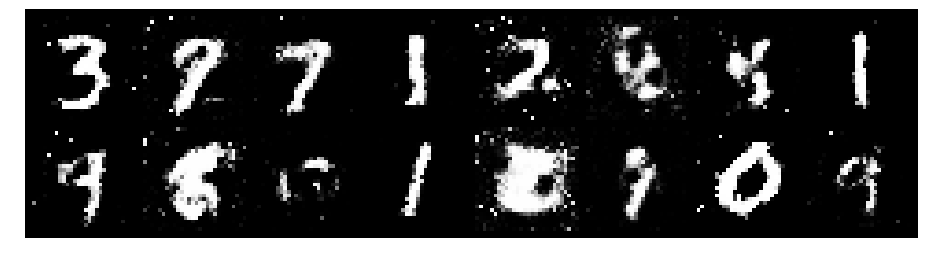

Epoch: [32/200], Batch Num: [200/600]
Discriminator Loss: 1.1121, Generator Loss: 1.1199
D(x): 0.6842, D(G(z)): 0.4152


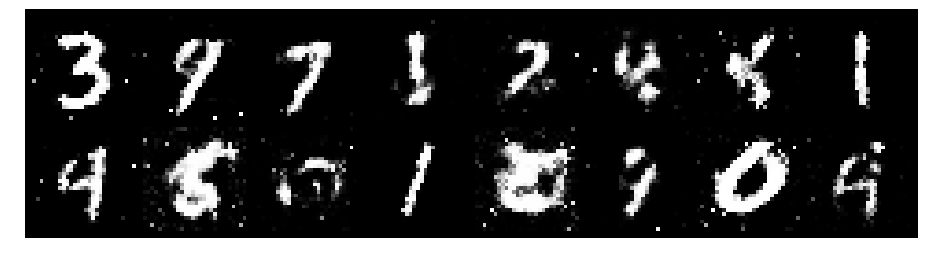

Epoch: [32/200], Batch Num: [300/600]
Discriminator Loss: 1.0454, Generator Loss: 1.2723
D(x): 0.6033, D(G(z)): 0.3365


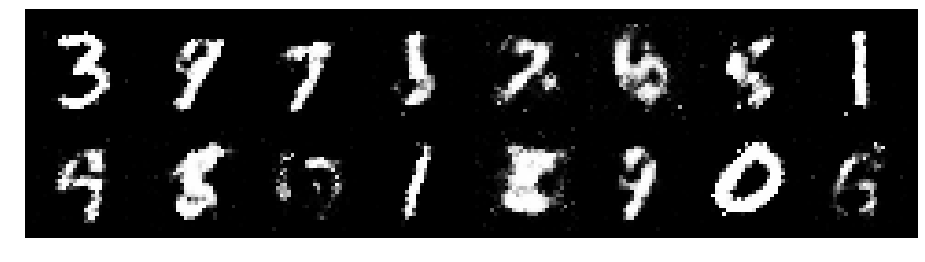

Epoch: [32/200], Batch Num: [400/600]
Discriminator Loss: 0.9368, Generator Loss: 1.4279
D(x): 0.6520, D(G(z)): 0.3105


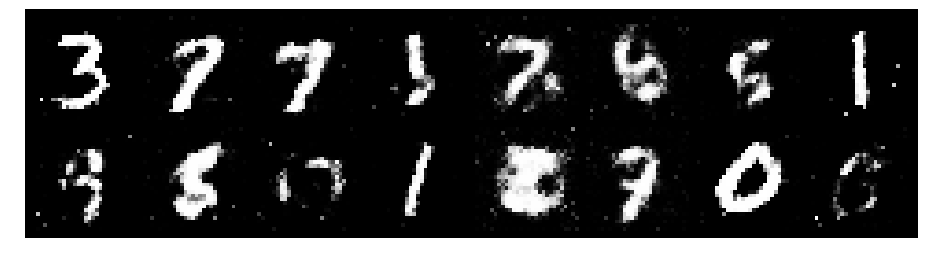

Epoch: [32/200], Batch Num: [500/600]
Discriminator Loss: 0.9814, Generator Loss: 1.3486
D(x): 0.6927, D(G(z)): 0.3443


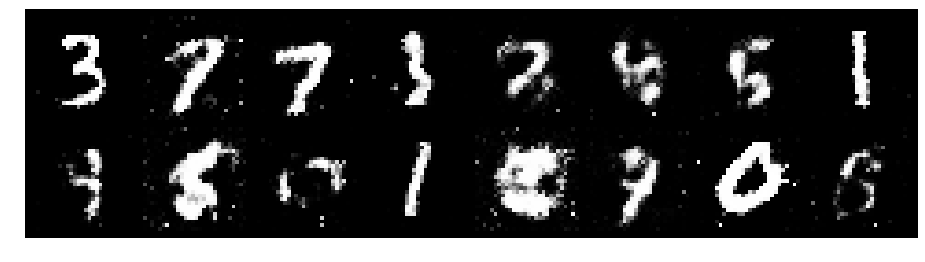

Epoch: [33/200], Batch Num: [0/600]
Discriminator Loss: 1.0159, Generator Loss: 1.4301
D(x): 0.6458, D(G(z)): 0.3232


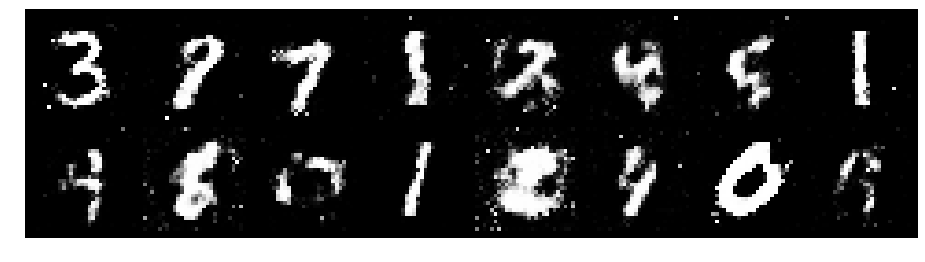

Epoch: [33/200], Batch Num: [100/600]
Discriminator Loss: 1.2145, Generator Loss: 1.0252
D(x): 0.6454, D(G(z)): 0.3975


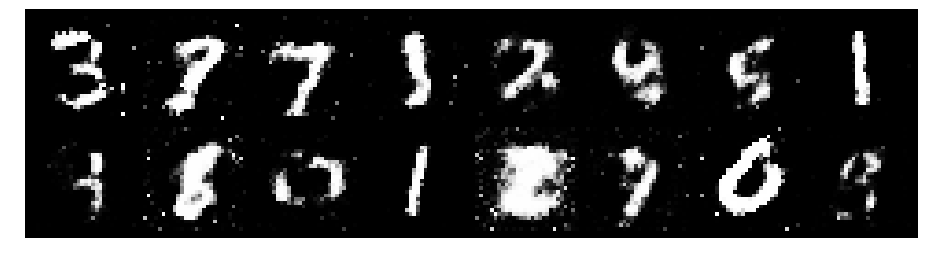

Epoch: [33/200], Batch Num: [200/600]
Discriminator Loss: 0.9705, Generator Loss: 1.3580
D(x): 0.6782, D(G(z)): 0.3522


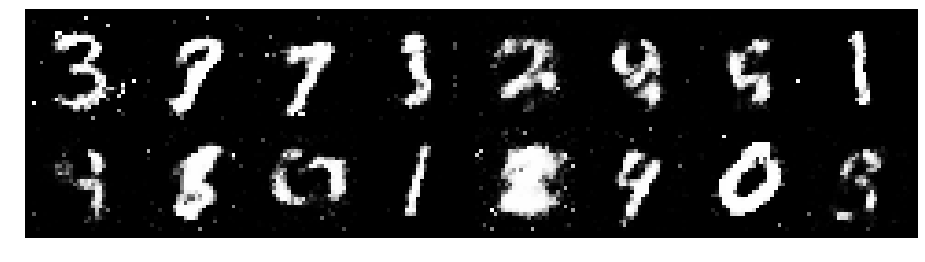

Epoch: [33/200], Batch Num: [300/600]
Discriminator Loss: 1.0742, Generator Loss: 1.1653
D(x): 0.6483, D(G(z)): 0.3442


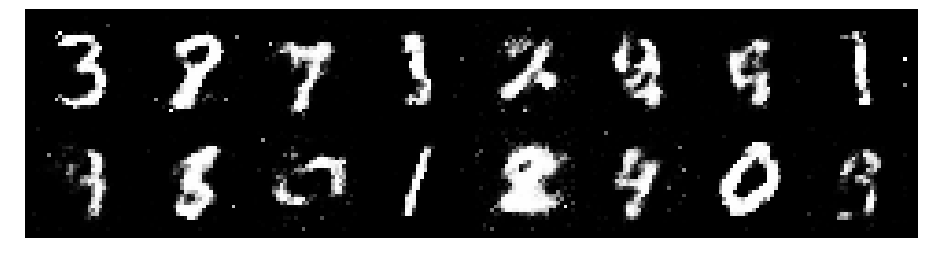

Epoch: [33/200], Batch Num: [400/600]
Discriminator Loss: 1.0276, Generator Loss: 1.4303
D(x): 0.6435, D(G(z)): 0.3204


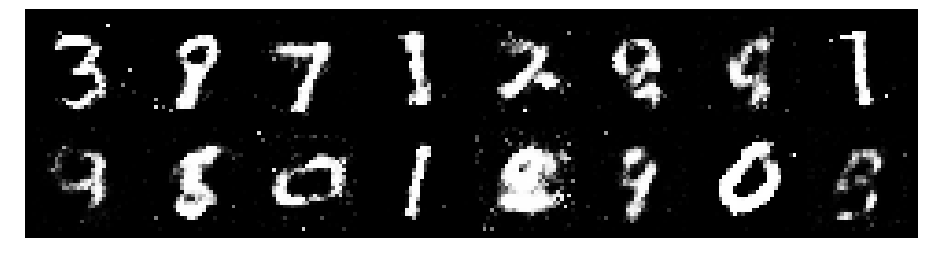

Epoch: [33/200], Batch Num: [500/600]
Discriminator Loss: 1.0183, Generator Loss: 1.5419
D(x): 0.7580, D(G(z)): 0.3911


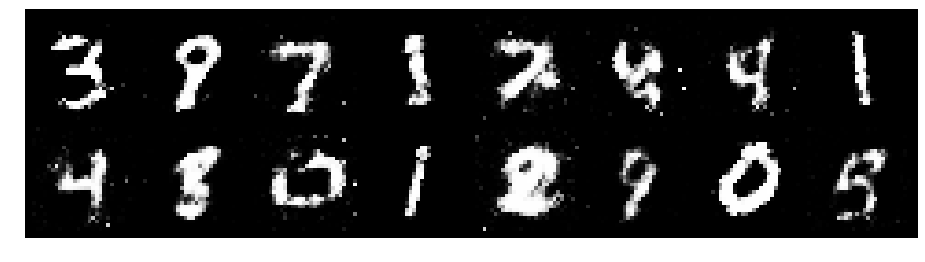

Epoch: [34/200], Batch Num: [0/600]
Discriminator Loss: 0.9601, Generator Loss: 1.1333
D(x): 0.6982, D(G(z)): 0.3591


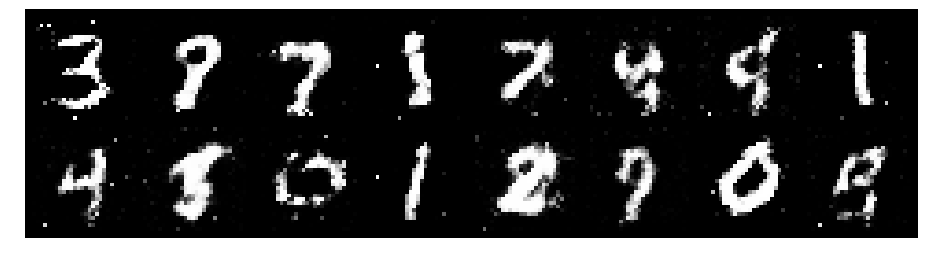

Epoch: [34/200], Batch Num: [100/600]
Discriminator Loss: 1.2325, Generator Loss: 1.3322
D(x): 0.6318, D(G(z)): 0.3914


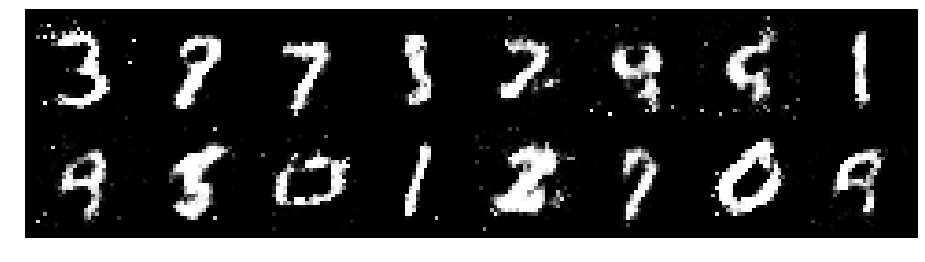

Epoch: [34/200], Batch Num: [200/600]
Discriminator Loss: 1.1268, Generator Loss: 1.0954
D(x): 0.6476, D(G(z)): 0.4198


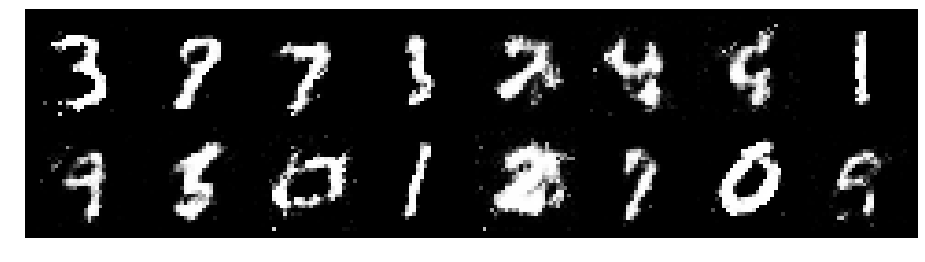

Epoch: [34/200], Batch Num: [300/600]
Discriminator Loss: 1.0666, Generator Loss: 1.3158
D(x): 0.6059, D(G(z)): 0.3173


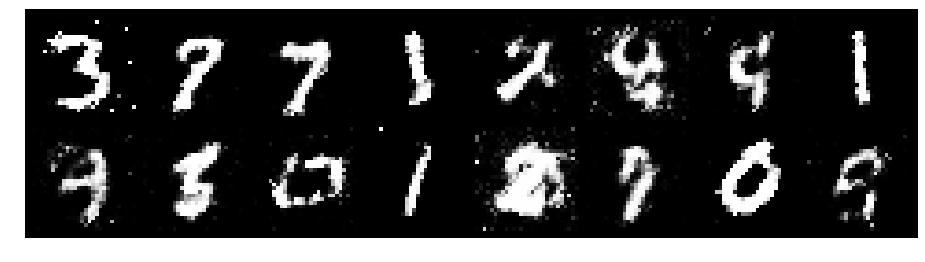

Epoch: [34/200], Batch Num: [400/600]
Discriminator Loss: 1.0438, Generator Loss: 1.3223
D(x): 0.6031, D(G(z)): 0.3043


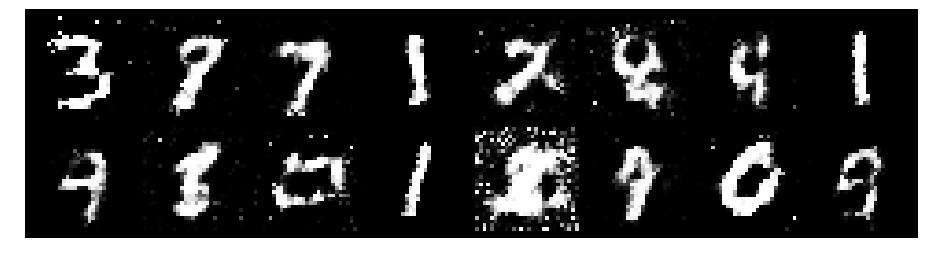

Epoch: [34/200], Batch Num: [500/600]
Discriminator Loss: 1.0242, Generator Loss: 1.2051
D(x): 0.6320, D(G(z)): 0.3544


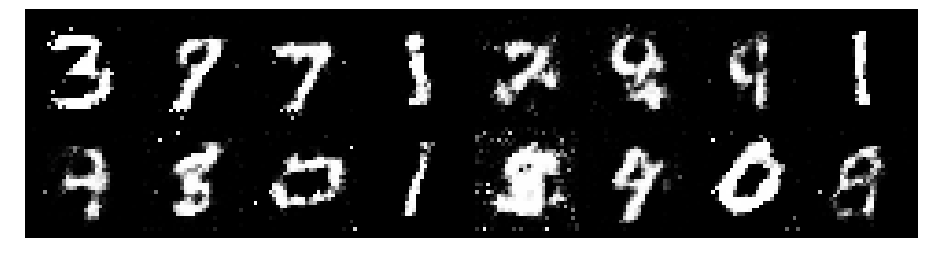

Epoch: [35/200], Batch Num: [0/600]
Discriminator Loss: 0.9643, Generator Loss: 1.2263
D(x): 0.6644, D(G(z)): 0.3638


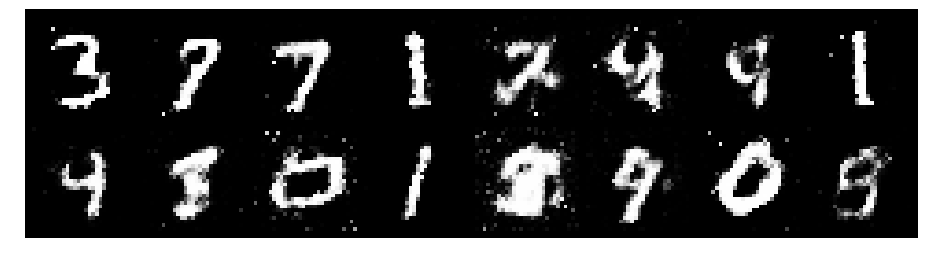

Epoch: [35/200], Batch Num: [100/600]
Discriminator Loss: 0.9943, Generator Loss: 1.3432
D(x): 0.7078, D(G(z)): 0.3872


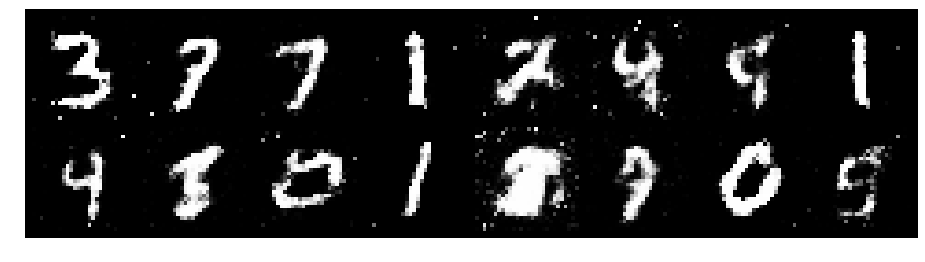

Epoch: [35/200], Batch Num: [200/600]
Discriminator Loss: 1.0380, Generator Loss: 1.2914
D(x): 0.6365, D(G(z)): 0.3463


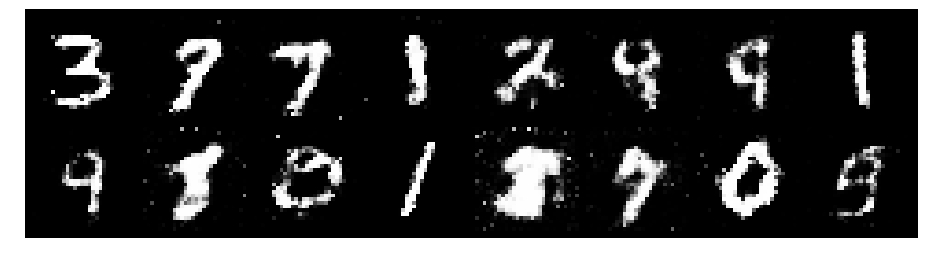

Epoch: [35/200], Batch Num: [300/600]
Discriminator Loss: 1.1955, Generator Loss: 1.1725
D(x): 0.6328, D(G(z)): 0.4190


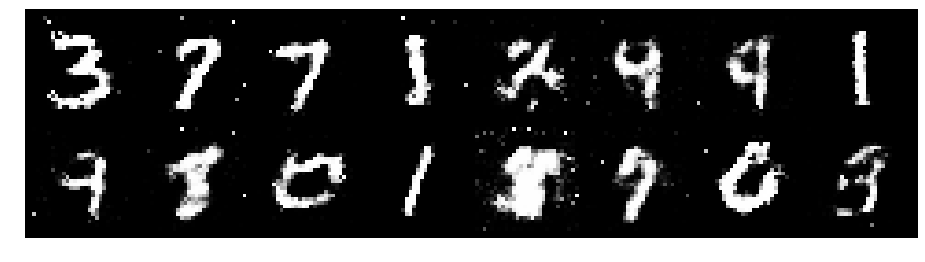

Epoch: [35/200], Batch Num: [400/600]
Discriminator Loss: 1.0147, Generator Loss: 1.0673
D(x): 0.6843, D(G(z)): 0.3999


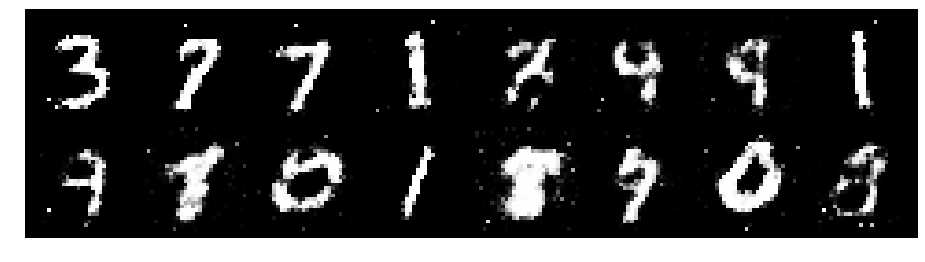

Epoch: [35/200], Batch Num: [500/600]
Discriminator Loss: 0.9738, Generator Loss: 1.3841
D(x): 0.6456, D(G(z)): 0.3259


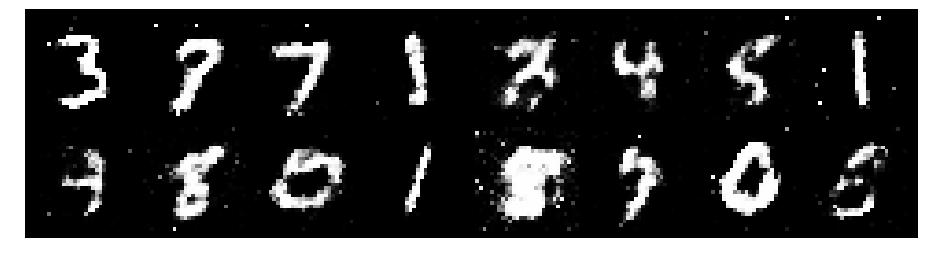

Epoch: [36/200], Batch Num: [0/600]
Discriminator Loss: 1.0071, Generator Loss: 1.4454
D(x): 0.6480, D(G(z)): 0.3450


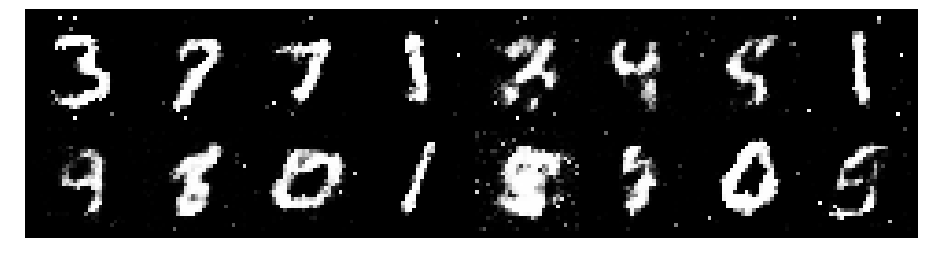

Epoch: [36/200], Batch Num: [100/600]
Discriminator Loss: 1.0669, Generator Loss: 1.2349
D(x): 0.6611, D(G(z)): 0.3598


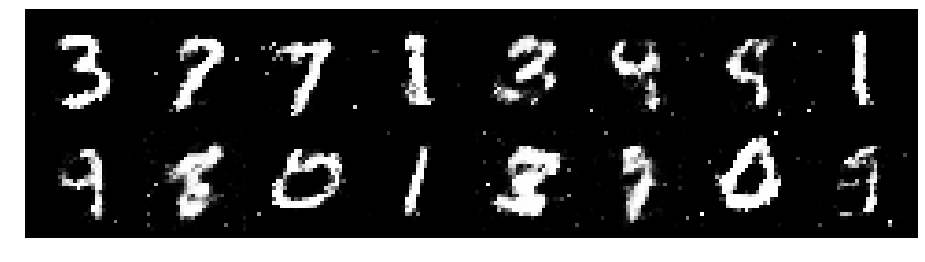

Epoch: [36/200], Batch Num: [200/600]
Discriminator Loss: 0.8713, Generator Loss: 1.2776
D(x): 0.7362, D(G(z)): 0.3584


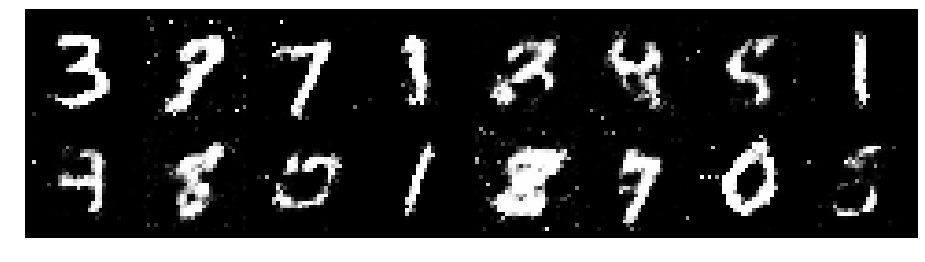

Epoch: [36/200], Batch Num: [300/600]
Discriminator Loss: 0.9815, Generator Loss: 1.2421
D(x): 0.6641, D(G(z)): 0.3663


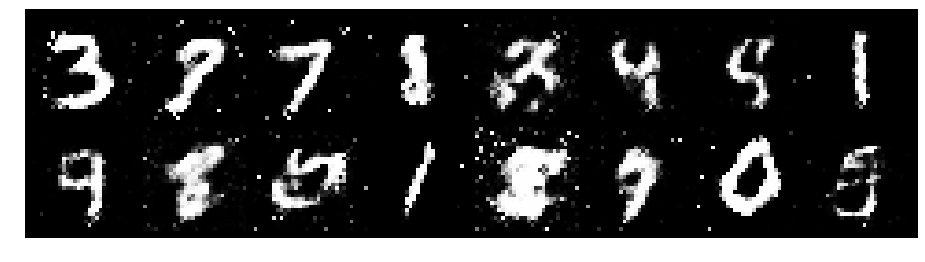

Epoch: [36/200], Batch Num: [400/600]
Discriminator Loss: 0.8846, Generator Loss: 1.5173
D(x): 0.7053, D(G(z)): 0.3381


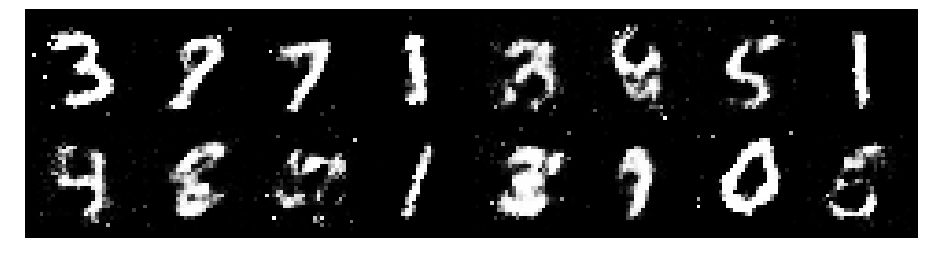

Epoch: [36/200], Batch Num: [500/600]
Discriminator Loss: 1.0337, Generator Loss: 1.4165
D(x): 0.7257, D(G(z)): 0.3817


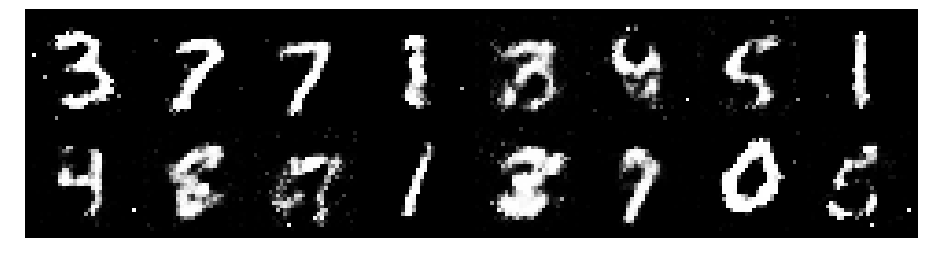

Epoch: [37/200], Batch Num: [0/600]
Discriminator Loss: 1.0760, Generator Loss: 1.4258
D(x): 0.6371, D(G(z)): 0.3260


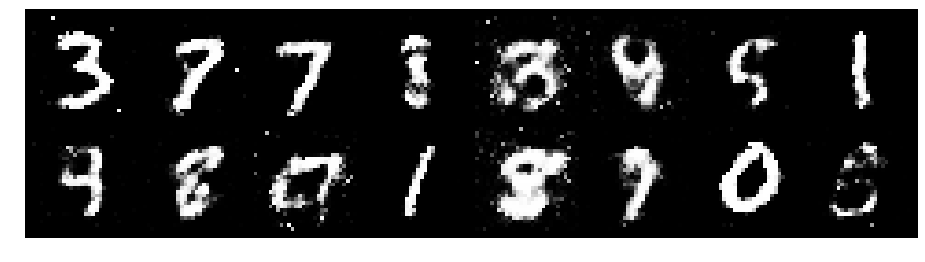

Epoch: [37/200], Batch Num: [100/600]
Discriminator Loss: 0.9840, Generator Loss: 1.2334
D(x): 0.6422, D(G(z)): 0.3289


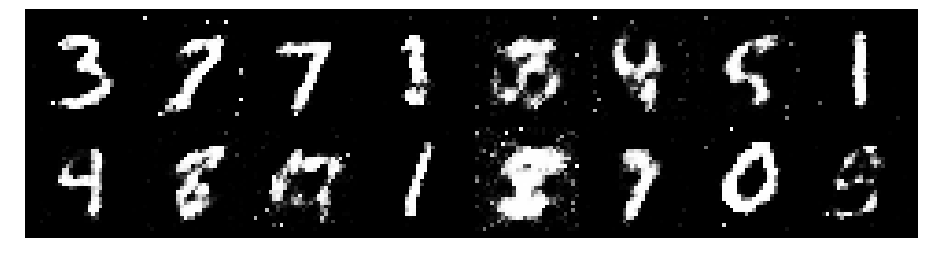

Epoch: [37/200], Batch Num: [200/600]
Discriminator Loss: 0.8622, Generator Loss: 1.4575
D(x): 0.6956, D(G(z)): 0.3159


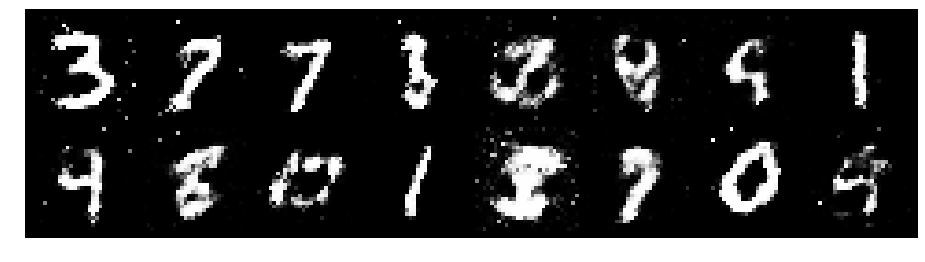

Epoch: [37/200], Batch Num: [300/600]
Discriminator Loss: 1.0132, Generator Loss: 1.5268
D(x): 0.7056, D(G(z)): 0.3852


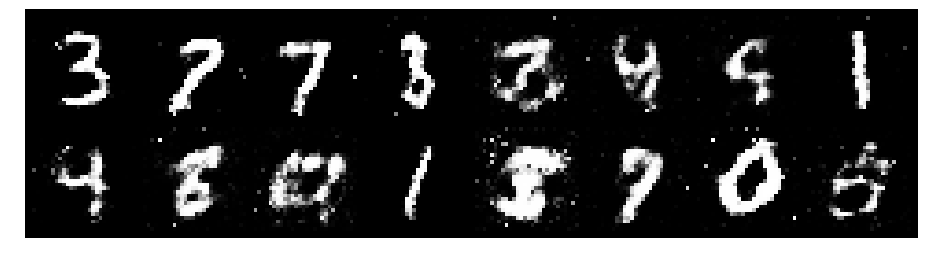

Epoch: [37/200], Batch Num: [400/600]
Discriminator Loss: 1.2738, Generator Loss: 1.0541
D(x): 0.6004, D(G(z)): 0.3717


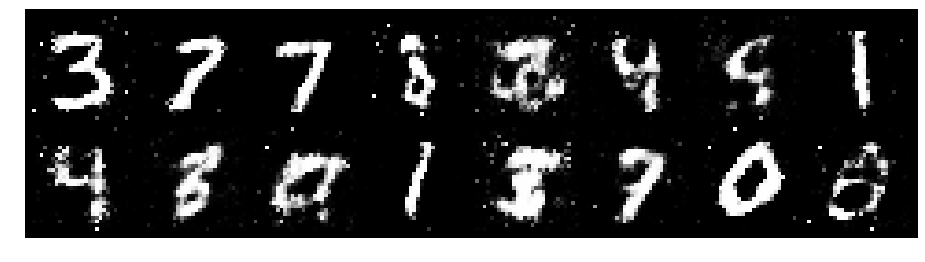

Epoch: [37/200], Batch Num: [500/600]
Discriminator Loss: 1.1303, Generator Loss: 1.1794
D(x): 0.6041, D(G(z)): 0.3621


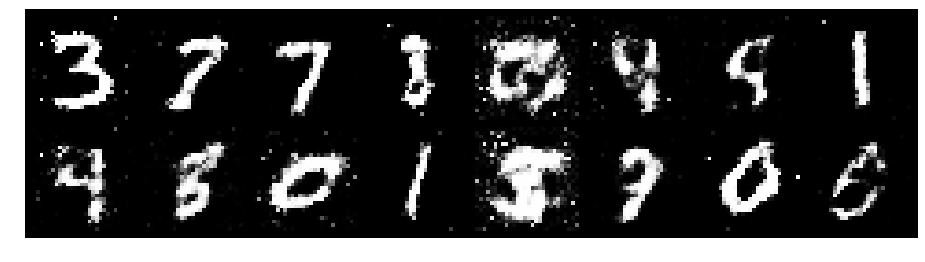

Epoch: [38/200], Batch Num: [0/600]
Discriminator Loss: 1.0981, Generator Loss: 1.0258
D(x): 0.6442, D(G(z)): 0.3934


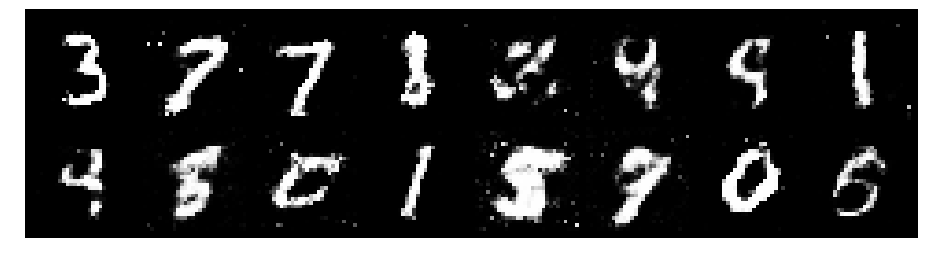

Epoch: [38/200], Batch Num: [100/600]
Discriminator Loss: 0.9546, Generator Loss: 1.6059
D(x): 0.6801, D(G(z)): 0.3233


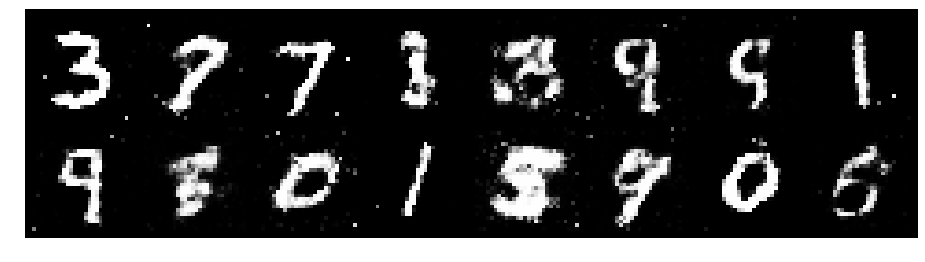

Epoch: [38/200], Batch Num: [200/600]
Discriminator Loss: 1.1250, Generator Loss: 1.3240
D(x): 0.5951, D(G(z)): 0.3198


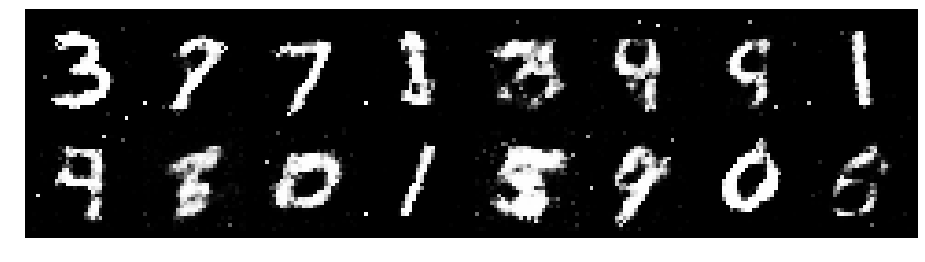

Epoch: [38/200], Batch Num: [300/600]
Discriminator Loss: 1.1618, Generator Loss: 1.5683
D(x): 0.5802, D(G(z)): 0.3339


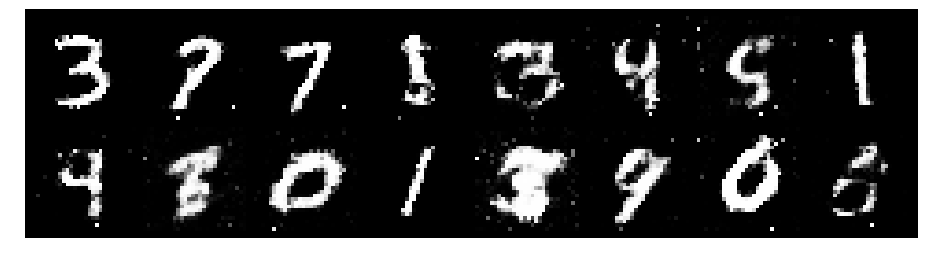

Epoch: [38/200], Batch Num: [400/600]
Discriminator Loss: 1.0552, Generator Loss: 1.1488
D(x): 0.6623, D(G(z)): 0.3841


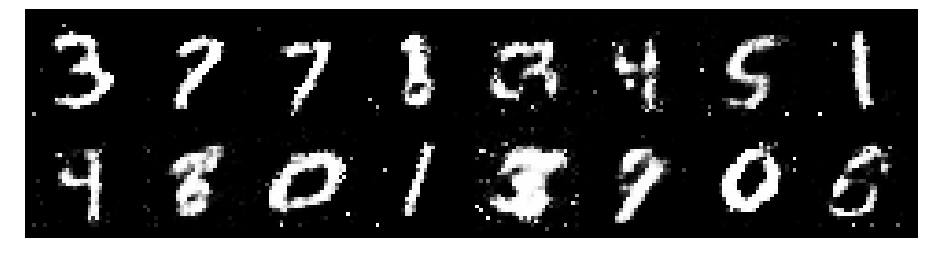

Epoch: [38/200], Batch Num: [500/600]
Discriminator Loss: 1.1658, Generator Loss: 1.2663
D(x): 0.6671, D(G(z)): 0.4169


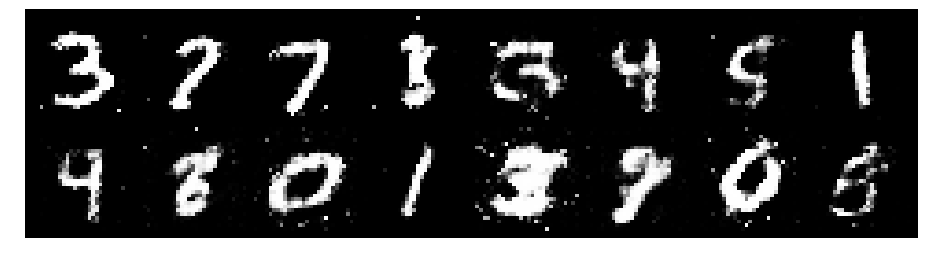

Epoch: [39/200], Batch Num: [0/600]
Discriminator Loss: 1.2457, Generator Loss: 1.1216
D(x): 0.6177, D(G(z)): 0.4380


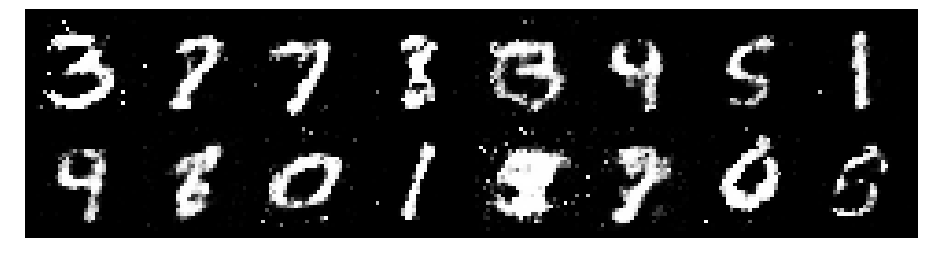

Epoch: [39/200], Batch Num: [100/600]
Discriminator Loss: 1.0752, Generator Loss: 1.6366
D(x): 0.6785, D(G(z)): 0.3860


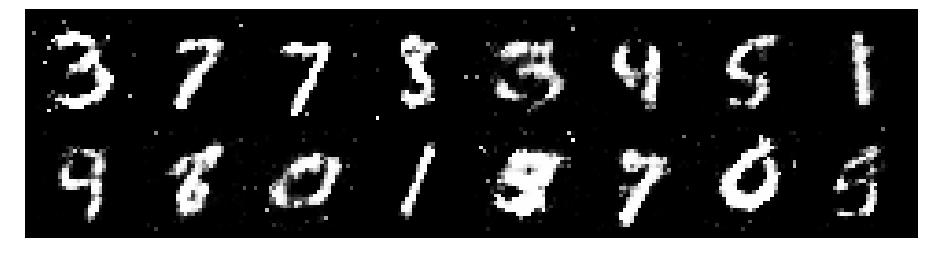

Epoch: [39/200], Batch Num: [200/600]
Discriminator Loss: 0.9052, Generator Loss: 1.2525
D(x): 0.6983, D(G(z)): 0.3461


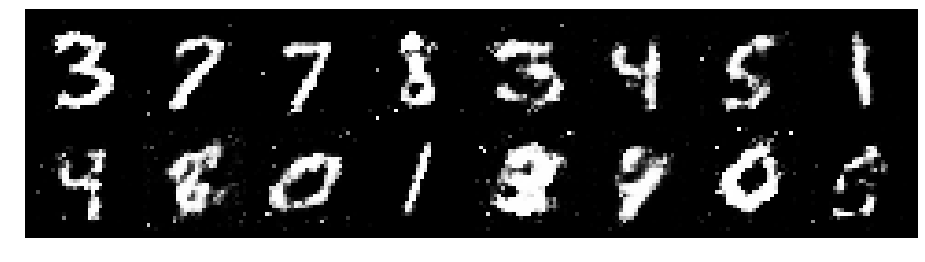

Epoch: [39/200], Batch Num: [300/600]
Discriminator Loss: 1.1735, Generator Loss: 0.9987
D(x): 0.6651, D(G(z)): 0.4552


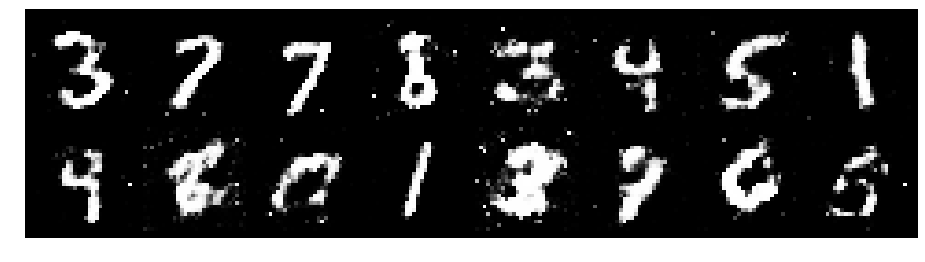

Epoch: [39/200], Batch Num: [400/600]
Discriminator Loss: 1.1920, Generator Loss: 1.0104
D(x): 0.5965, D(G(z)): 0.4061


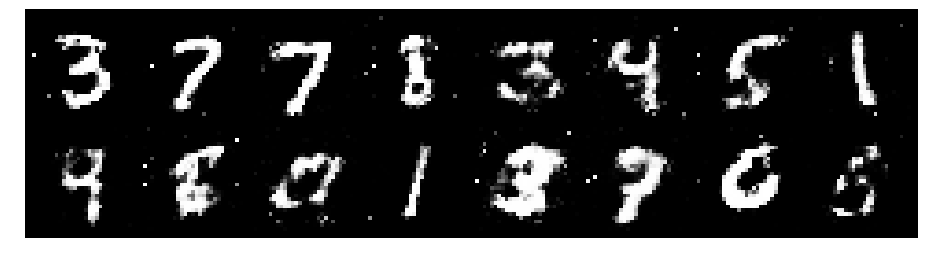

Epoch: [39/200], Batch Num: [500/600]
Discriminator Loss: 1.0959, Generator Loss: 1.4261
D(x): 0.6981, D(G(z)): 0.4107


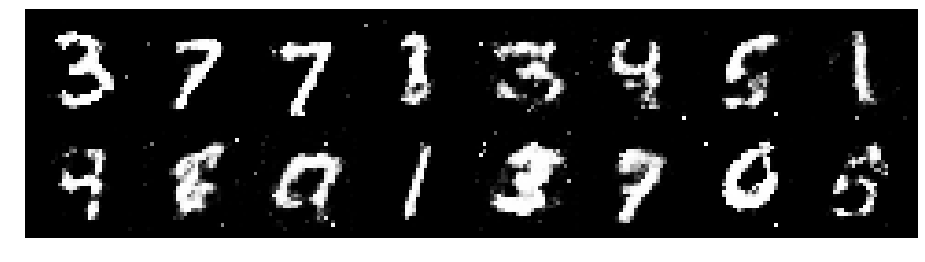

Epoch: [40/200], Batch Num: [0/600]
Discriminator Loss: 1.1453, Generator Loss: 1.1002
D(x): 0.5319, D(G(z)): 0.3164


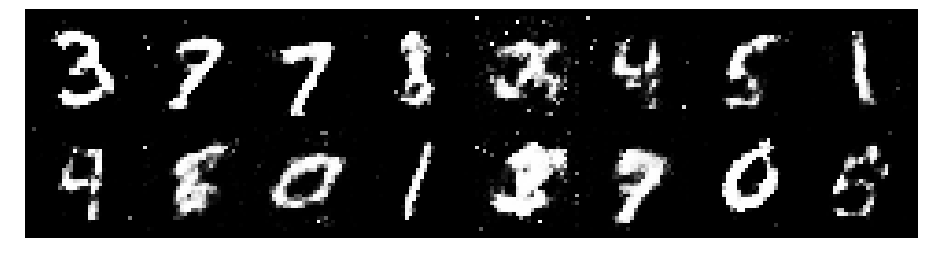

Epoch: [40/200], Batch Num: [100/600]
Discriminator Loss: 1.2517, Generator Loss: 1.3446
D(x): 0.5811, D(G(z)): 0.3866


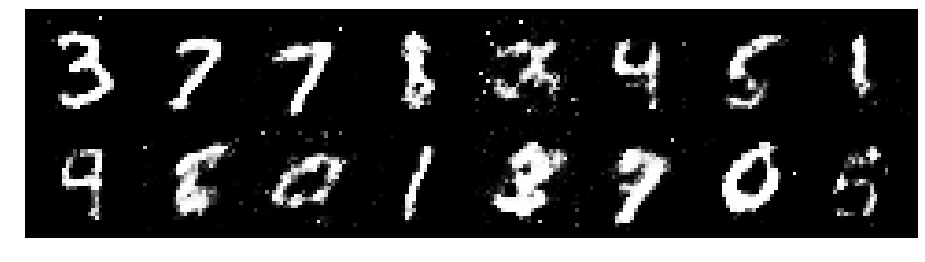

Epoch: [40/200], Batch Num: [200/600]
Discriminator Loss: 1.0533, Generator Loss: 1.0024
D(x): 0.6058, D(G(z)): 0.3443


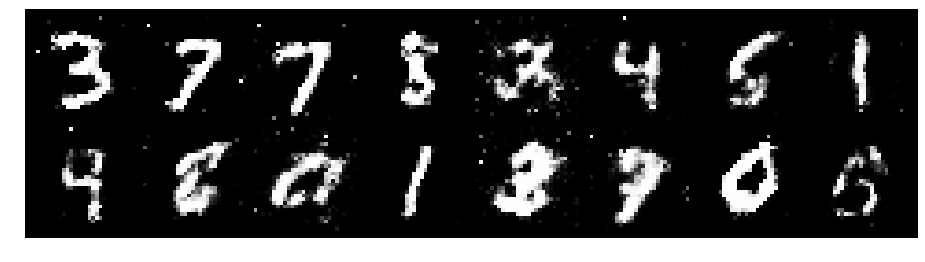

Epoch: [40/200], Batch Num: [300/600]
Discriminator Loss: 1.1332, Generator Loss: 1.0158
D(x): 0.6368, D(G(z)): 0.4181


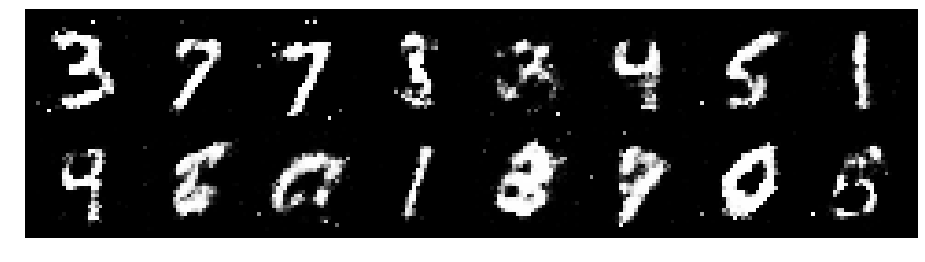

Epoch: [40/200], Batch Num: [400/600]
Discriminator Loss: 1.0177, Generator Loss: 1.2935
D(x): 0.6349, D(G(z)): 0.3441


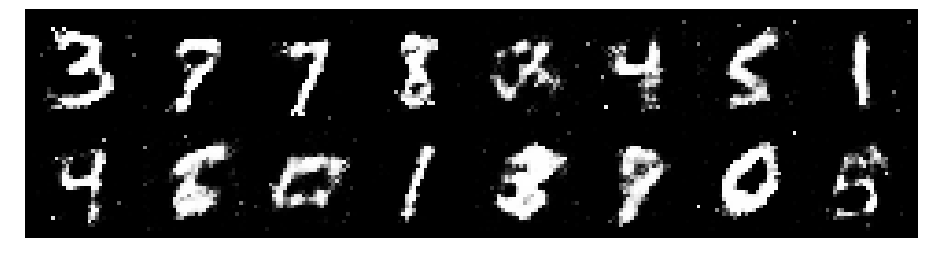

Epoch: [40/200], Batch Num: [500/600]
Discriminator Loss: 1.1369, Generator Loss: 1.2819
D(x): 0.7021, D(G(z)): 0.4051


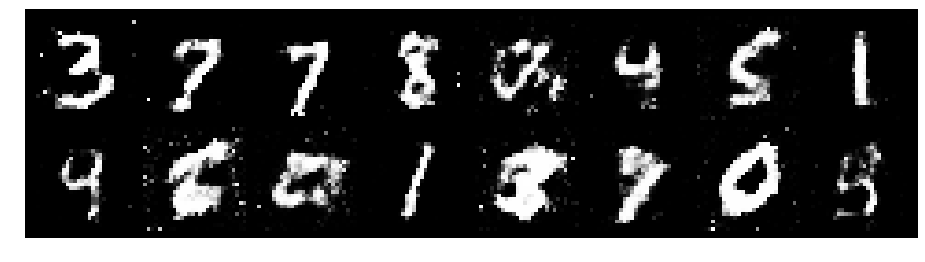

Epoch: [41/200], Batch Num: [0/600]
Discriminator Loss: 1.1236, Generator Loss: 1.5082
D(x): 0.6431, D(G(z)): 0.3849


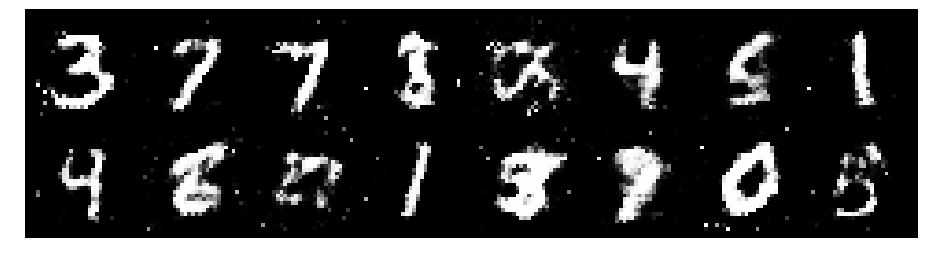

Epoch: [41/200], Batch Num: [100/600]
Discriminator Loss: 1.0425, Generator Loss: 1.2794
D(x): 0.6430, D(G(z)): 0.3622


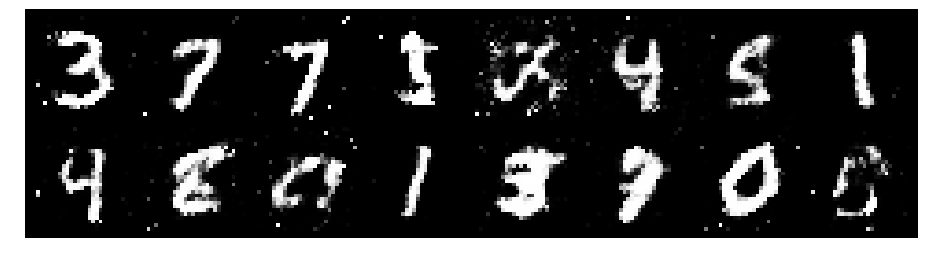

Epoch: [41/200], Batch Num: [200/600]
Discriminator Loss: 1.1876, Generator Loss: 1.0166
D(x): 0.6409, D(G(z)): 0.4339


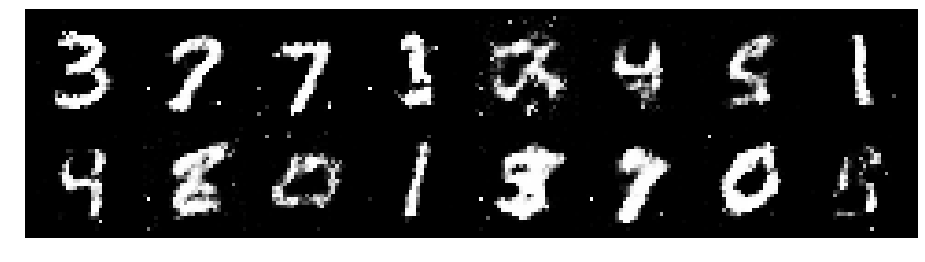

Epoch: [41/200], Batch Num: [300/600]
Discriminator Loss: 1.0409, Generator Loss: 1.4151
D(x): 0.6096, D(G(z)): 0.3357


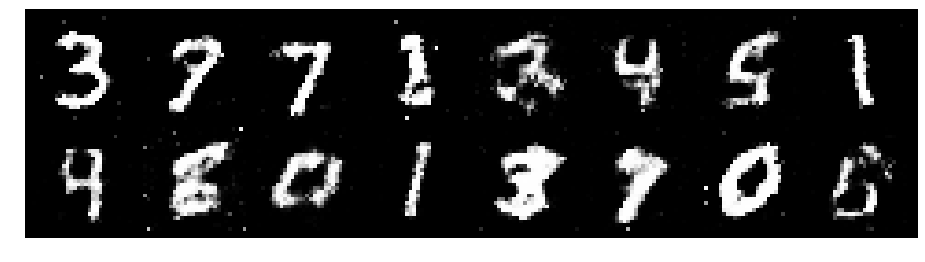

Epoch: [41/200], Batch Num: [400/600]
Discriminator Loss: 0.9791, Generator Loss: 1.5160
D(x): 0.6402, D(G(z)): 0.3313


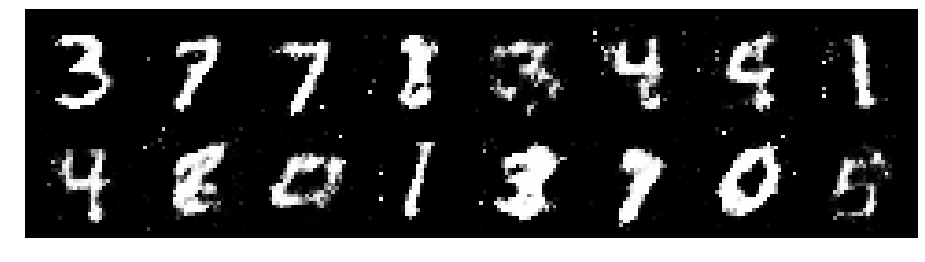

Epoch: [41/200], Batch Num: [500/600]
Discriminator Loss: 1.1630, Generator Loss: 1.2415
D(x): 0.6389, D(G(z)): 0.4154


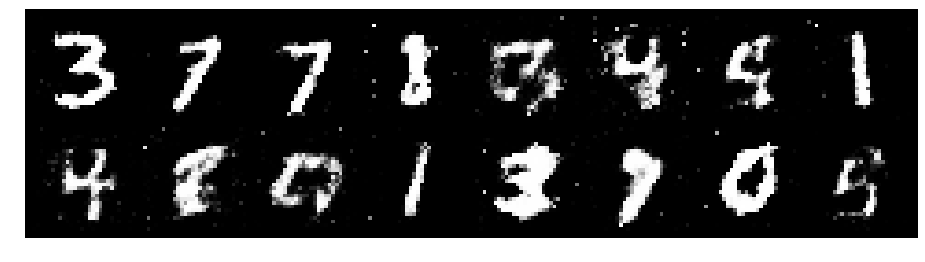

Epoch: [42/200], Batch Num: [0/600]
Discriminator Loss: 1.0850, Generator Loss: 1.1355
D(x): 0.6129, D(G(z)): 0.3678


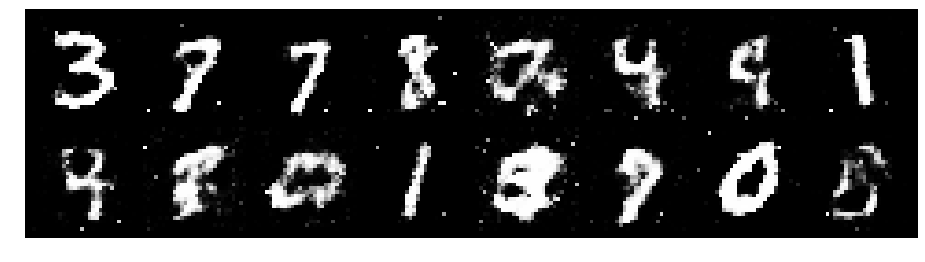

Epoch: [42/200], Batch Num: [100/600]
Discriminator Loss: 1.1072, Generator Loss: 1.2287
D(x): 0.5349, D(G(z)): 0.2940


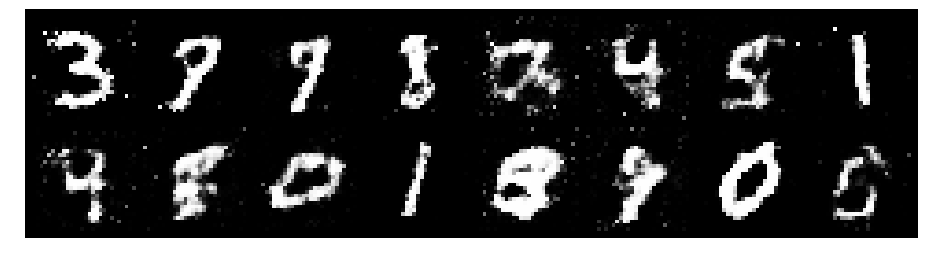

Epoch: [42/200], Batch Num: [200/600]
Discriminator Loss: 1.0373, Generator Loss: 1.2977
D(x): 0.6618, D(G(z)): 0.3575


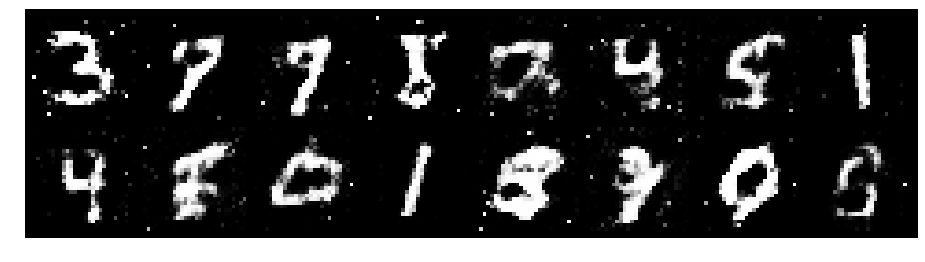

Epoch: [42/200], Batch Num: [300/600]
Discriminator Loss: 1.0796, Generator Loss: 1.3697
D(x): 0.6390, D(G(z)): 0.3690


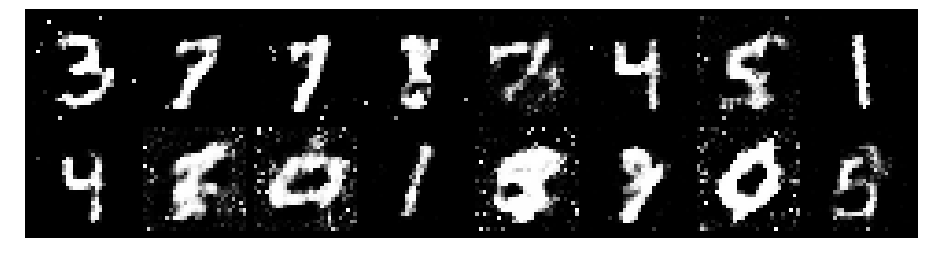

Epoch: [42/200], Batch Num: [400/600]
Discriminator Loss: 1.3378, Generator Loss: 1.0037
D(x): 0.5387, D(G(z)): 0.4238


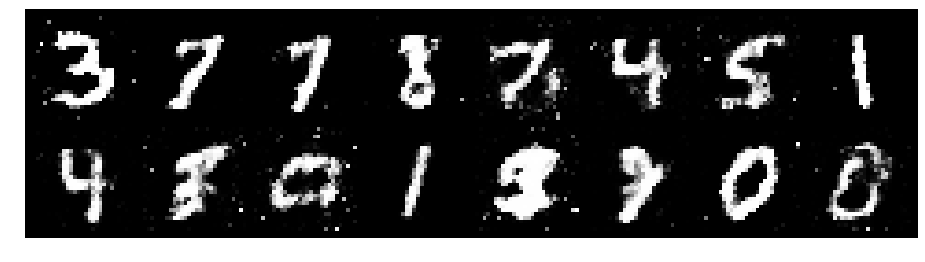

Epoch: [42/200], Batch Num: [500/600]
Discriminator Loss: 1.1558, Generator Loss: 1.0700
D(x): 0.5791, D(G(z)): 0.3767


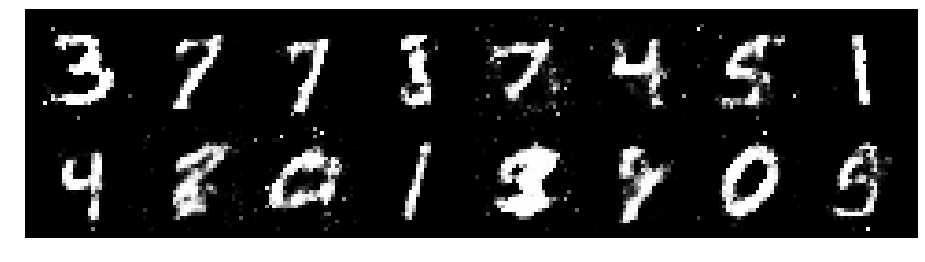

Epoch: [43/200], Batch Num: [0/600]
Discriminator Loss: 1.1019, Generator Loss: 0.9993
D(x): 0.5683, D(G(z)): 0.3362


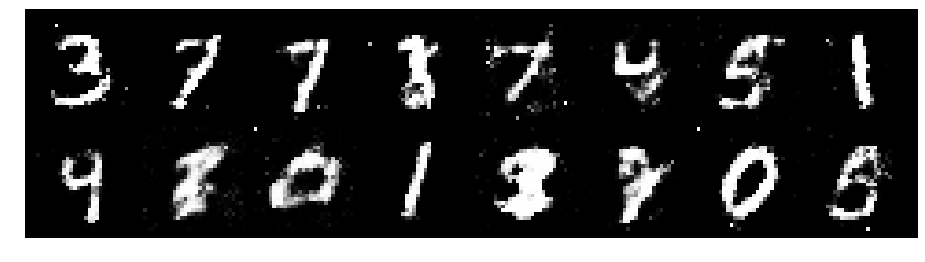

Epoch: [43/200], Batch Num: [100/600]
Discriminator Loss: 1.0491, Generator Loss: 1.0808
D(x): 0.6343, D(G(z)): 0.3854


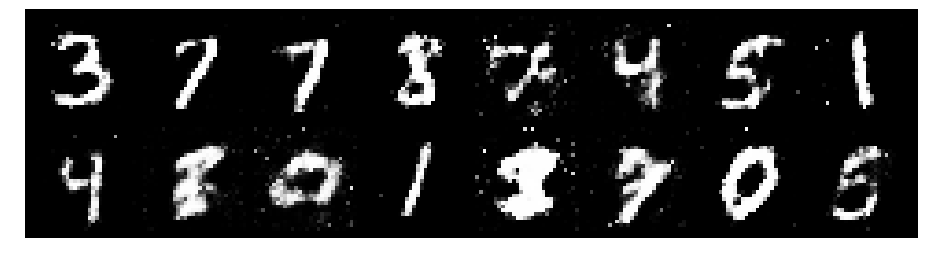

Epoch: [43/200], Batch Num: [200/600]
Discriminator Loss: 1.0263, Generator Loss: 1.0705
D(x): 0.6349, D(G(z)): 0.3631


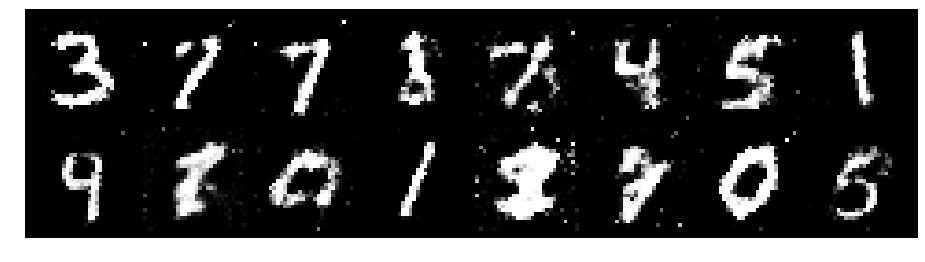

Epoch: [43/200], Batch Num: [300/600]
Discriminator Loss: 1.0952, Generator Loss: 1.2415
D(x): 0.5830, D(G(z)): 0.3390


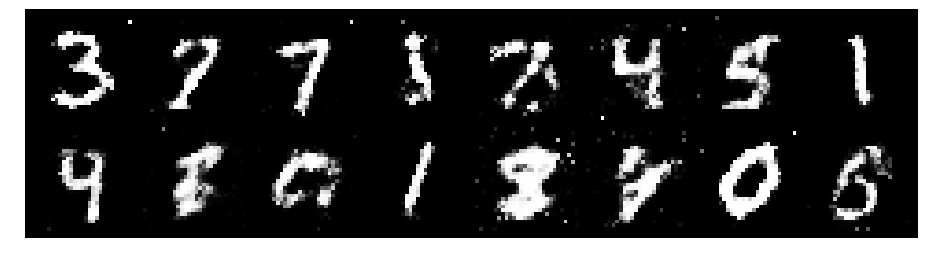

Epoch: [43/200], Batch Num: [400/600]
Discriminator Loss: 0.9983, Generator Loss: 1.4021
D(x): 0.6321, D(G(z)): 0.3388


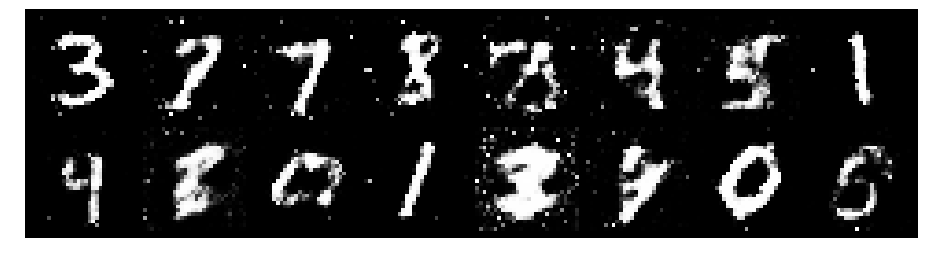

Epoch: [43/200], Batch Num: [500/600]
Discriminator Loss: 1.1157, Generator Loss: 1.3932
D(x): 0.6101, D(G(z)): 0.3792


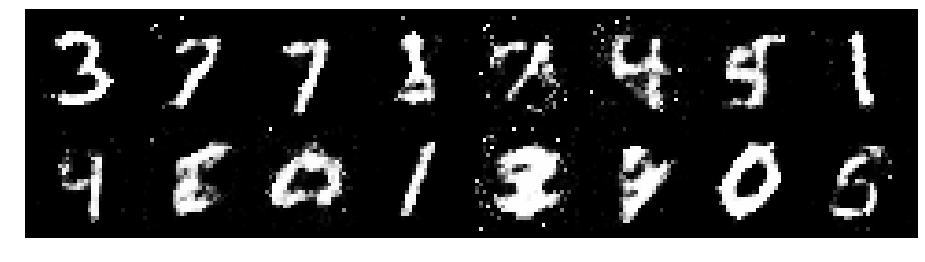

Epoch: [44/200], Batch Num: [0/600]
Discriminator Loss: 1.0288, Generator Loss: 1.1072
D(x): 0.6453, D(G(z)): 0.3913


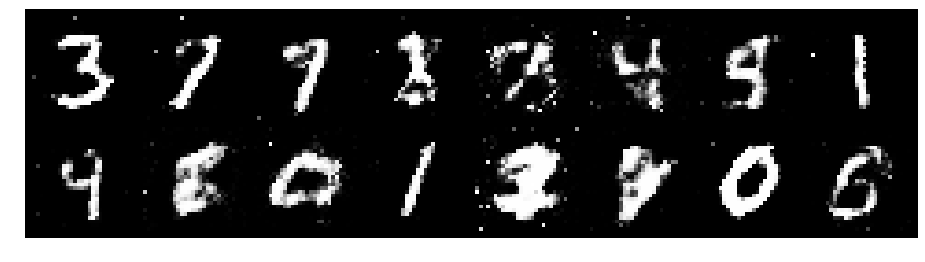

Epoch: [44/200], Batch Num: [100/600]
Discriminator Loss: 1.0326, Generator Loss: 1.2709
D(x): 0.6808, D(G(z)): 0.3878


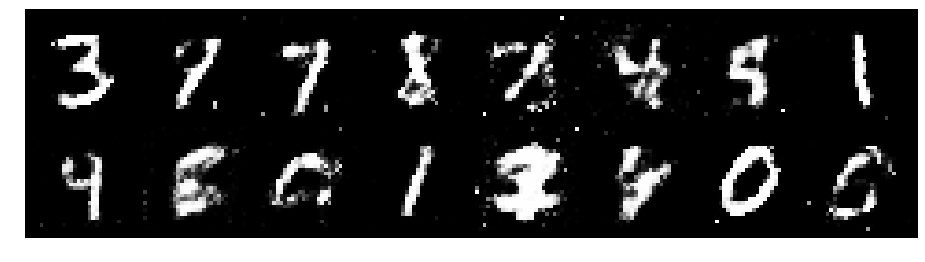

Epoch: [44/200], Batch Num: [200/600]
Discriminator Loss: 1.1697, Generator Loss: 1.1657
D(x): 0.6575, D(G(z)): 0.4264


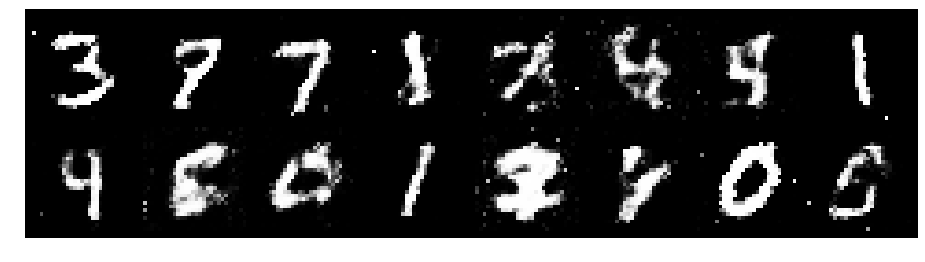

Epoch: [44/200], Batch Num: [300/600]
Discriminator Loss: 1.2641, Generator Loss: 1.1224
D(x): 0.5778, D(G(z)): 0.4209


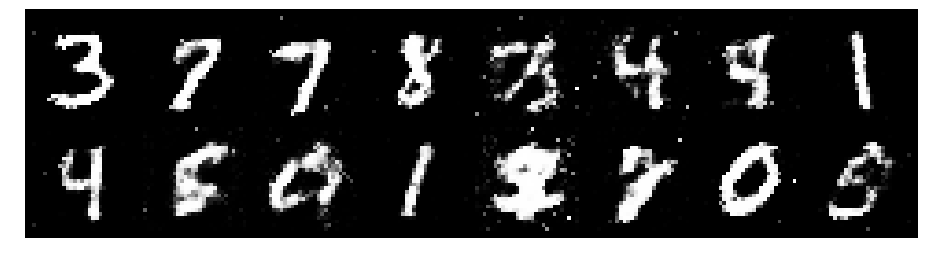

Epoch: [44/200], Batch Num: [400/600]
Discriminator Loss: 1.1098, Generator Loss: 1.0118
D(x): 0.6429, D(G(z)): 0.4109


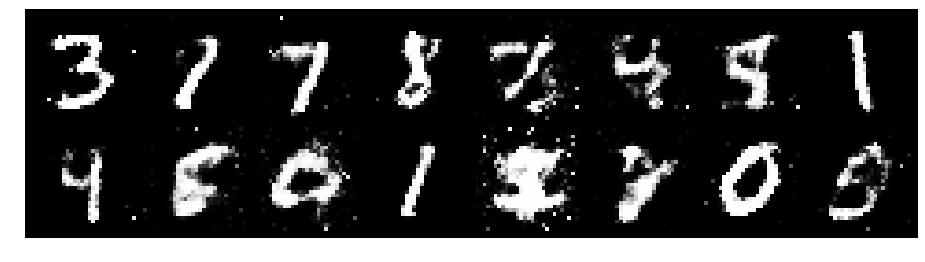

Epoch: [44/200], Batch Num: [500/600]
Discriminator Loss: 1.2994, Generator Loss: 1.0724
D(x): 0.5523, D(G(z)): 0.3909


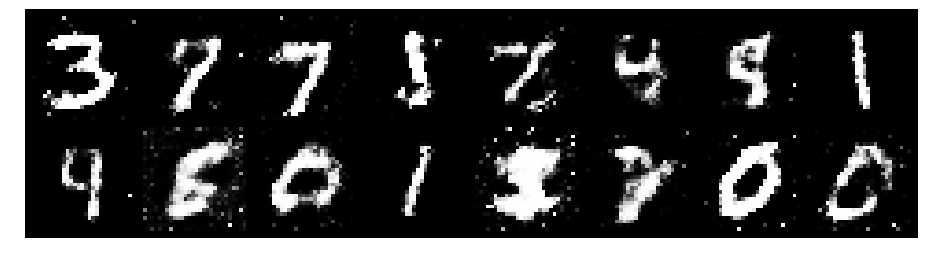

Epoch: [45/200], Batch Num: [0/600]
Discriminator Loss: 1.2277, Generator Loss: 0.9271
D(x): 0.6122, D(G(z)): 0.4526


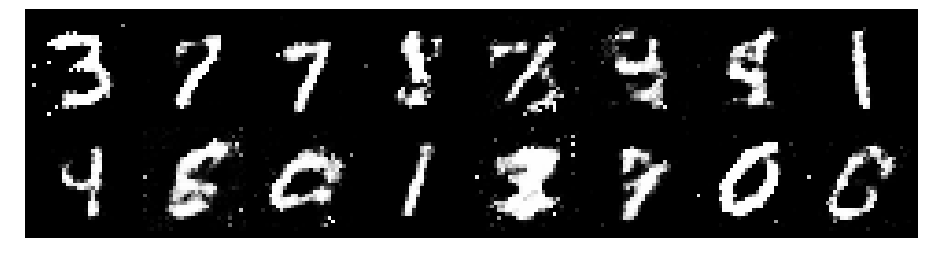

Epoch: [45/200], Batch Num: [100/600]
Discriminator Loss: 1.0996, Generator Loss: 0.9528
D(x): 0.6669, D(G(z)): 0.4323


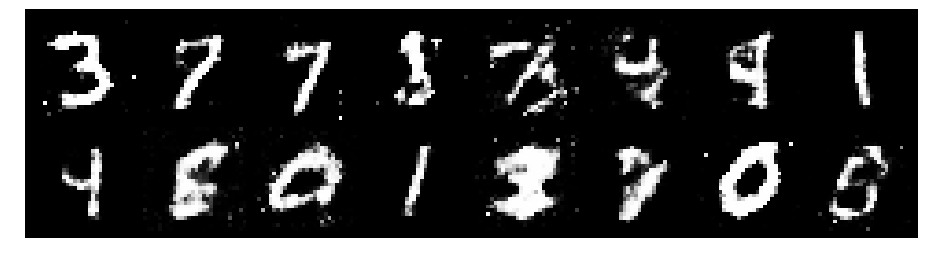

Epoch: [45/200], Batch Num: [200/600]
Discriminator Loss: 1.1496, Generator Loss: 1.2282
D(x): 0.6214, D(G(z)): 0.3704


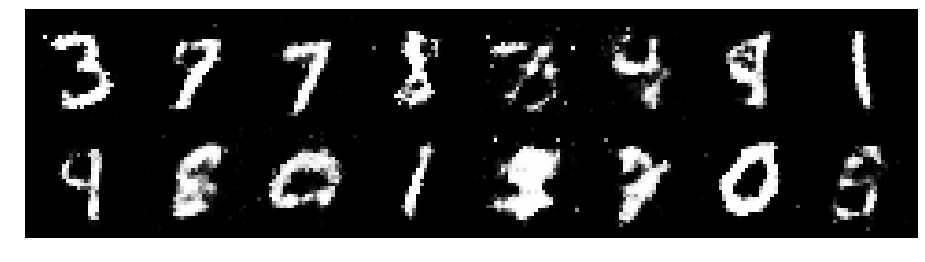

Epoch: [45/200], Batch Num: [300/600]
Discriminator Loss: 1.0998, Generator Loss: 0.9748
D(x): 0.6122, D(G(z)): 0.3742


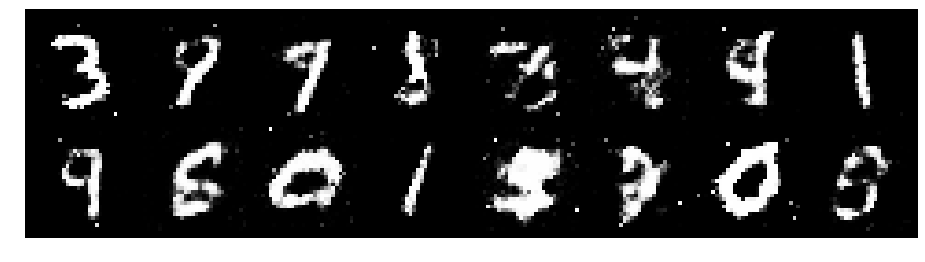

Epoch: [45/200], Batch Num: [400/600]
Discriminator Loss: 1.1146, Generator Loss: 1.0402
D(x): 0.5833, D(G(z)): 0.3987


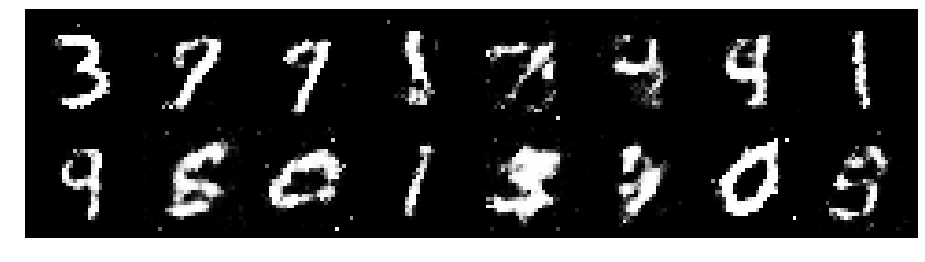

Epoch: [45/200], Batch Num: [500/600]
Discriminator Loss: 1.0758, Generator Loss: 1.2034
D(x): 0.5700, D(G(z)): 0.3363


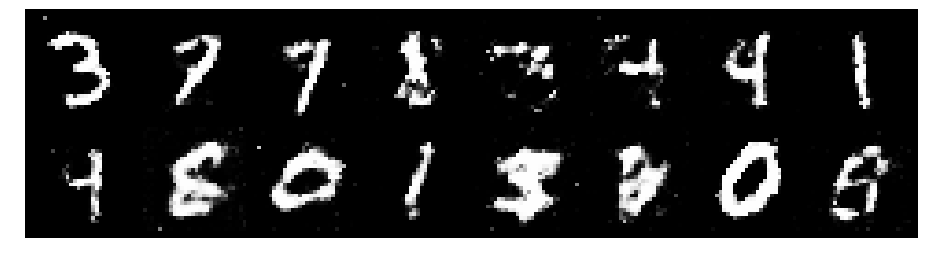

Epoch: [46/200], Batch Num: [0/600]
Discriminator Loss: 1.1276, Generator Loss: 1.1292
D(x): 0.6077, D(G(z)): 0.3683


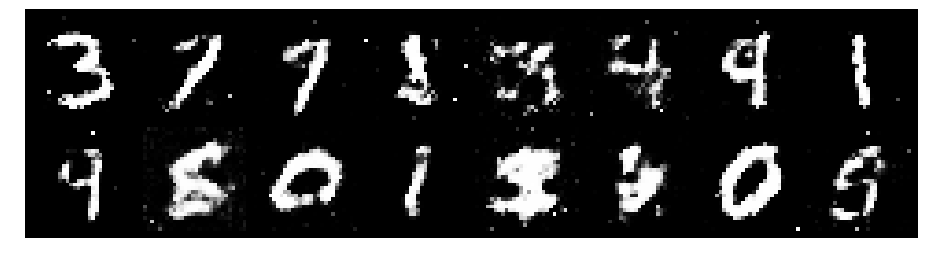

Epoch: [46/200], Batch Num: [100/600]
Discriminator Loss: 1.0624, Generator Loss: 1.5574
D(x): 0.6293, D(G(z)): 0.3361


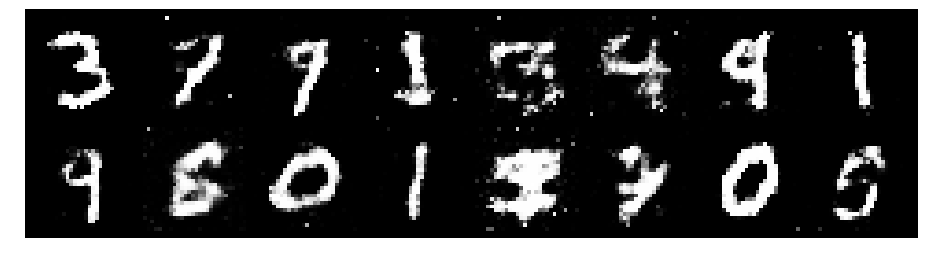

Epoch: [46/200], Batch Num: [200/600]
Discriminator Loss: 1.0708, Generator Loss: 1.6305
D(x): 0.6061, D(G(z)): 0.3256


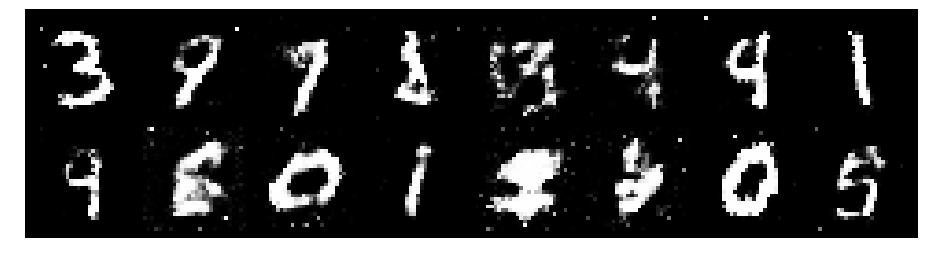

Epoch: [46/200], Batch Num: [300/600]
Discriminator Loss: 1.0326, Generator Loss: 1.1935
D(x): 0.6140, D(G(z)): 0.3431


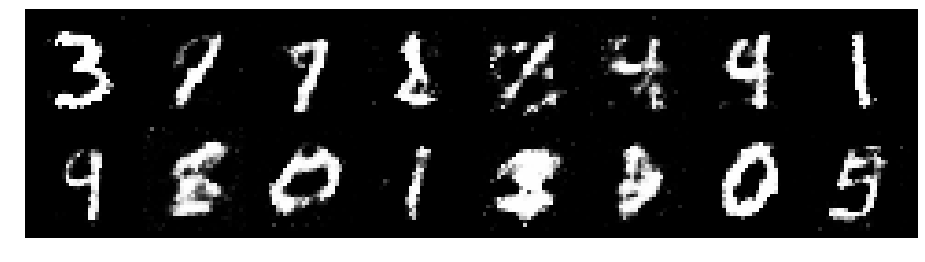

Epoch: [46/200], Batch Num: [400/600]
Discriminator Loss: 1.1186, Generator Loss: 1.1297
D(x): 0.6070, D(G(z)): 0.3693


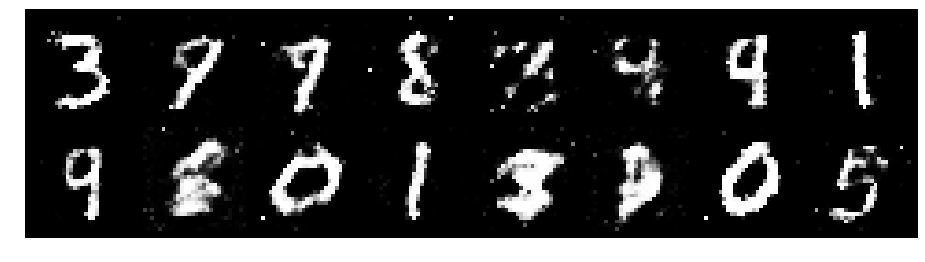

Epoch: [46/200], Batch Num: [500/600]
Discriminator Loss: 1.1060, Generator Loss: 1.1357
D(x): 0.6048, D(G(z)): 0.3759


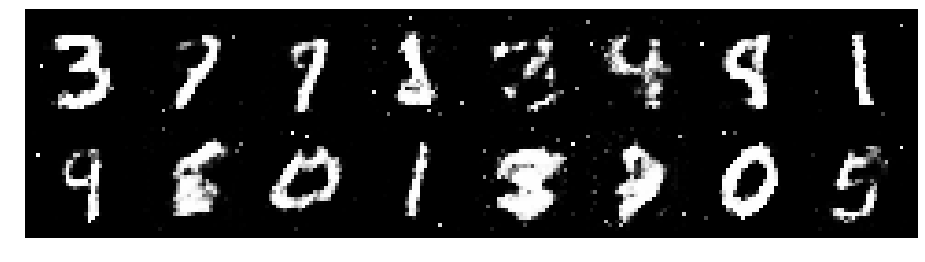

Epoch: [47/200], Batch Num: [0/600]
Discriminator Loss: 1.3707, Generator Loss: 1.0550
D(x): 0.5885, D(G(z)): 0.4717


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 23.4K of output have been discarded. 

Epoch: [47/200], Batch Num: [100/600]
Discriminator Loss: 1.1824, Generator Loss: 0.8288
D(x): 0.6057, D(G(z)): 0.4280


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 25.7K of output have been discarded. 

Epoch: [47/200], Batch Num: [200/600]
Discriminator Loss: 1.1046, Generator Loss: 0.9809
D(x): 0.6350, D(G(z)): 0.3953


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 26.8K of output have been discarded. 

Epoch: [47/200], Batch Num: [300/600]
Discriminator Loss: 1.3459, Generator Loss: 0.9549
D(x): 0.5060, D(G(z)): 0.4154


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 26.9K of output have been discarded. 

Epoch: [47/200], Batch Num: [400/600]
Discriminator Loss: 1.2230, Generator Loss: 1.0608
D(x): 0.5621, D(G(z)): 0.4153


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 24.8K of output have been discarded. 

Epoch: [47/200], Batch Num: [500/600]
Discriminator Loss: 1.1959, Generator Loss: 0.9559
D(x): 0.6030, D(G(z)): 0.4340


Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 1M of output have been discarded. 

In [0]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )